# UrbanSound8K DeepLearning Classification

In [3]:
!pip install --break-system-packages -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


### Importing Important Library

In [4]:
import os
import struct
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import numpy as np
import librosa
from scipy.signal import chirp
import soundfile as sf

### Getting  Metadata

In [5]:
data = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
print(data.shape)

(8732, 8)


In [6]:
data.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [7]:
appended = []
for i in range(1,11):
    appended.append(data[data.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

class   index  jackhammer  dog_bark  drilling  children_playing  \
0       fold1         120       100       100               100   
1       fold2         120       100       100               100   
2       fold3         120       100       100               100   
3       fold4         120       100       100               100   
4       fold5         120       100       100               100   
5       fold6          68       100       100               100   
6       fold7          76       100       100               100   
7       fold8          78       100       100               100   
8       fold9          82       100       100               100   
9      fold10          96       100       100               100   

class  air_conditioner  street_music  engine_idling  siren  car_horn  gun_shot  
0                  100           100             96     86        36        35  
1                  100           100            100     91        42        35  
2                  100           100            107    119        43        36  
3                  100           100            107    166        59        38  
4                  100           100            107     71        98        40  
5                  100           100            107     74        28        46  
6                  100           100            106     77        28        51  
7                  100           100             88     80        30        30  
8                  100           100             89     82        32        31  
9                  100           100             93     83        33        32

In [8]:
print(data['class'].value_counts(normalize=True))

class
dog_bark            0.114521
children_playing    0.114521
air_conditioner     0.114521
street_music        0.114521
jackhammer          0.114521
engine_idling       0.114521
drilling            0.114521
siren               0.106390
car_horn            0.049130
gun_shot            0.042831
Name: proportion, dtype: float64


### Plotting wave



In [9]:
def path_class(filename):
    excerpt = data[data['slice_file_name'] == filename]
    path_name = os.path.join('UrbanSound8K/audio', 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['class'].values[0]

In [10]:
def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('number of channels: ',wav_sample.shape[1])
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

sampling rate:  44100 Hz
bit depth:  16
number of channels:  2
duration:  4.0  second
number of samples:  176400
class:  children_playing


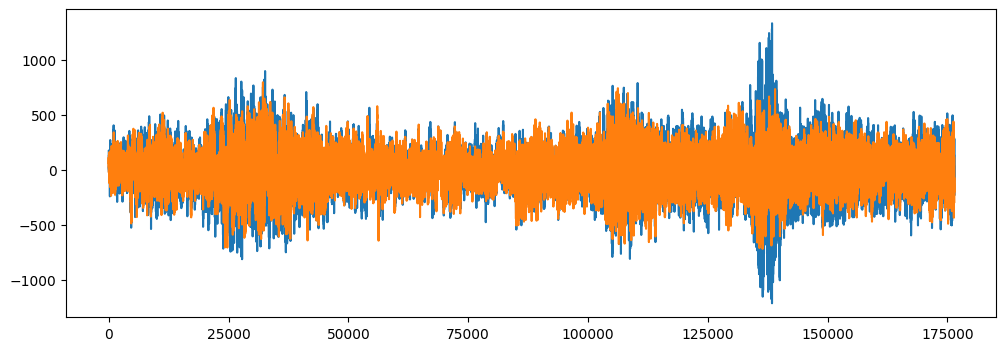

In [11]:
fullpath, label = path_class('100263-2-0-117.wav')
wav_plotter(fullpath,label)

In [12]:
def wav_fmt_parser(file_name):
    full_path, _ = path_class(file_name)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    n_channels_string = riff_fmt[22:24]
    n_channels = struct.unpack("H",n_channels_string)[0]
    s_rate_string = riff_fmt[24:28]
    s_rate = struct.unpack("I",s_rate_string)[0]
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    return (n_channels,s_rate,bit_depth)

In [13]:
wav_fmt_data = [wav_fmt_parser(i) for i in data.slice_file_name]
data[['n_channels','sampling_rate','bit_depth']] = pd.DataFrame(wav_fmt_data)
print(data.head())

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  n_channels  sampling_rate  bit_depth  
0          dog_bark           2          44100         16  
1  children_playing           2          44100         16  
2  children_playing           2          44100         16  
3  children_playing           2          44100         16  
4  children_playing           2          44100         16  


In [14]:
print(data.n_channels.value_counts(),end = "\n\n\n")
print(data.bit_depth.value_counts())

n_channels
2    7993
1     739
Name: count, dtype: int64


bit_depth
16    5758
24    2753
32     169
8       43
4        9
Name: count, dtype: int64


## Nyquist Sampling Theorem Example ############

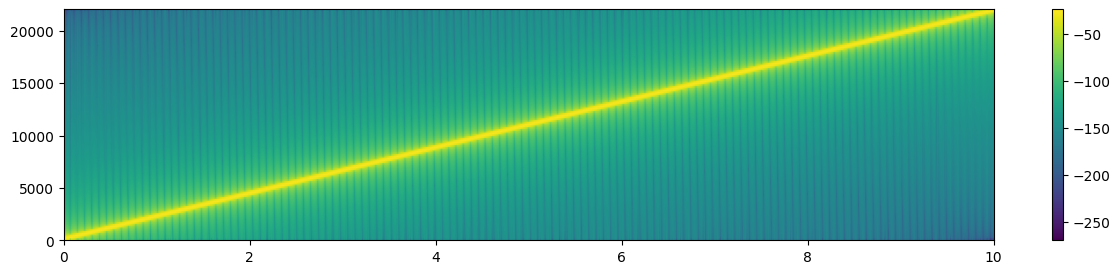

In [15]:
fs = 44100
T = 10
t = np.linspace(0, T, T*fs, endpoint=False)

w = chirp(t, f0=20, f1=22050, t1=T, method='linear')
sf.write('sine_sweep_44100.wav', w, fs)

plt.figure(figsize=(15,3))
plt.specgram(w, Fs=44100)
plt.colorbar()
_=plt.axis((0,10,0,22050))
ipd.Audio('sine_sweep_44100.wav')

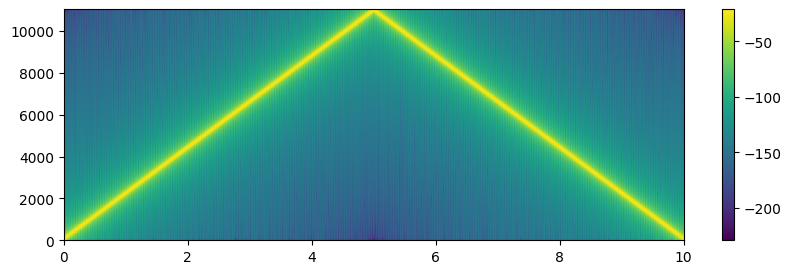

In [16]:
down_sampled = w[::2]
sf.write('sine_sweep_downsampled.wav', down_sampled, 22050)

plt.figure(figsize=(10,3))
plt.specgram(down_sampled, Fs=22050)
plt.colorbar()
_=plt.axis((0,10,0,11050))
ipd.Audio('sine_sweep_downsampled.wav')

###### END of Example
###     
###  
##### Why Librosa is better than scipy

In [17]:
data[data.slice_file_name == '100652-3-0-1.wav']

slice_file_name    fsID  start  end  salience  fold  classID     class  \
15  100652-3-0-1.wav  100652    0.5  4.5         1     2        3  dog_bark   

    n_channels  sampling_rate  bit_depth  
15           2          44100         16

In [18]:
fullpath,_ = path_class('100652-3-0-1.wav')
librosa_load, librosa_sampling_rate = librosa.load(fullpath)
scipy_sampling_rate, scipy_load = wav.read(fullpath)
print('original sample rate:',scipy_sampling_rate)
print('converted sample rate:',librosa_sampling_rate,end = "\n\n")
print('original wav file min~max range:',np.min(scipy_load),'~',np.max(scipy_load))
print('converted wav file min~max range:',np.min(librosa_load),'~',np.max(librosa_load))

original sample rate: 44100
converted sample rate: 22050

original wav file min~max range: -30926 ~ 30119
converted wav file min~max range: -0.72961366 ~ 0.7433088


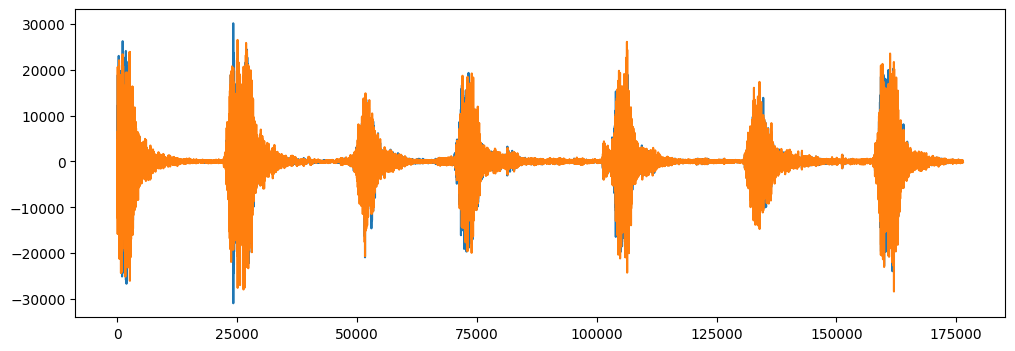

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_load)

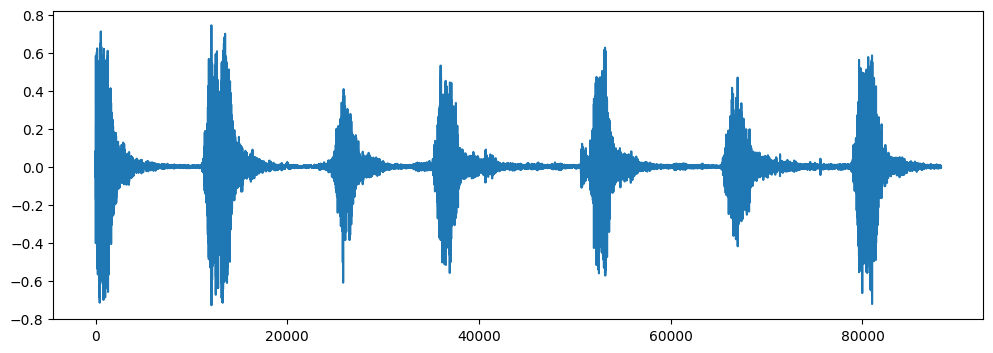

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(librosa_load)

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')

In [22]:
METADATA_PATH = 'UrbanSound8K/metadata/UrbanSound8K.csv'
AUDIO_BASE_PATH = 'UrbanSound8K/audio'

In [23]:
def dataset_overview(df):
    """Print comprehensive dataset statistics"""
    print("=" * 60)
    print("URBANSOUND8K DATASET OVERVIEW")
    print("=" * 60)
    print(f"Total samples: {len(df)}")
    print(f"Number of classes: {df['classID'].nunique()}")
    print(f"Number of folds: {df['fold'].nunique()}")
    print(f"\nClass distribution:")
    print(df['class'].value_counts().sort_index())
    print(f"\nSamples per fold:")
    print(df['fold'].value_counts().sort_index())
    print("=" * 60)

def basic_statistics(df):
    """Calculate and display basic statistical measures"""
    stats_dict = {
        'Mean': df.groupby('class')['classID'].count().mean(),
        'Median': df.groupby('class')['classID'].count().median(),
        'Std Dev': df.groupby('class')['classID'].count().std(),
        'Min': df.groupby('class')['classID'].count().min(),
        'Max': df.groupby('class')['classID'].count().max()
    }
    
    print("\nDataset Statistics:")
    for key, value in stats_dict.items():
        print(f"{key}: {value:.2f}")
    
    return stats_dict

In [24]:
def plot_class_distribution(df):
    """Plot class distribution with counts"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Bar plot
    class_counts = df['class'].value_counts().sort_index()
    ax1.bar(range(len(class_counts)), class_counts.values, color='steelblue')
    ax1.set_xlabel('Class', fontsize=12)
    ax1.set_ylabel('Number of Samples', fontsize=12)
    ax1.set_title('Class Distribution - Bar Chart', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(class_counts)))
    ax1.set_xticklabels(class_counts.index, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    
    # Pie chart
    ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette('Set3', len(class_counts)))
    ax2.set_title('Class Distribution - Percentage', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_fold_distribution(df):
    """Plot distribution across folds"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    fold_counts = df['fold'].value_counts().sort_index()
    bars = ax.bar(fold_counts.index, fold_counts.values, color='coral')
    
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('Number of Samples', fontsize=12)
    ax.set_title('Sample Distribution Across Folds', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_class_fold_heatmap(df):
    """Create heatmap showing class distribution across folds"""
    pivot_table = df.pivot_table(
        values='slice_file_name',
        index='class',
        columns='fold',
        aggfunc='count',
        fill_value=0
    )
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd', 
                cbar_kws={'label': 'Number of Samples'})
    plt.title('Class Distribution Across Folds', fontsize=14, fontweight='bold')
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Class', fontsize=12)
    plt.tight_layout()
    plt.show()

In [25]:
def load_audio(file_path, sr=22050):
    """Load audio file and return signal and sample rate"""
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

def plot_waveform(y, sr, title="Audio Waveform"):
    """Plot audio waveform"""
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y, sr=sr, alpha=0.6)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_spectrogram(y, sr, title="Spectrogram"):
    """Plot spectrogram"""
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Frequency (Hz)', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_mel_spectrogram(y, sr, title="Mel Spectrogram"):
    """Plot mel-scaled spectrogram"""
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Mel Frequency', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_mfcc(y, sr, n_mfcc=13, title="MFCC Features"):
    """Plot Mel-frequency cepstral coefficients"""
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    plt.figure(figsize=(14, 6))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='RdBu_r')
    plt.colorbar(label='MFCC Coefficient Value')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('MFCC Coefficients', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_chromagram(y, sr, title="Chromagram"):
    """Plot chromagram"""
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='plasma')
    plt.colorbar(label='Magnitude')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Pitch Class', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_spectral_centroid(y, sr, title="Spectral Centroid"):
    """Plot spectral centroid over time"""
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    times = librosa.times_like(cent, sr=sr)
    
    plt.figure(figsize=(14, 4))
    plt.plot(times, cent.T, color='steelblue', linewidth=1.5)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Frequency (Hz)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_zero_crossing_rate(y, title="Zero Crossing Rate"):
    """Plot zero crossing rate over time"""
    zcr = librosa.feature.zero_crossing_rate(y)
    frames = range(len(zcr[0]))
    
    plt.figure(figsize=(14, 4))
    plt.plot(frames, zcr[0], color='green', linewidth=1.5)
    plt.xlabel('Frame', fontsize=12)
    plt.ylabel('Zero Crossing Rate', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_spectral_rolloff(y, sr, title="Spectral Rolloff"):
    """Plot spectral rolloff over time"""
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    times = librosa.times_like(rolloff, sr=sr)
    
    plt.figure(figsize=(14, 4))
    plt.plot(times, rolloff.T, color='purple', linewidth=1.5)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Frequency (Hz)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [26]:
def analyze_audio_comprehensive(file_path, class_name="Unknown", sr=22050):
    """Perform comprehensive analysis on a single audio file"""
    y, sr = load_audio(file_path, sr)
    
    print(f"\n{'='*60}")
    print(f"Audio Analysis: {class_name}")
    print(f"{'='*60}")
    print(f"Duration: {len(y)/sr:.2f} seconds")
    print(f"Sample rate: {sr} Hz")
    print(f"Number of samples: {len(y)}")
    print(f"Max amplitude: {np.max(np.abs(y)):.4f}")
    print(f"Mean amplitude: {np.mean(np.abs(y)):.4f}")
    
    # Plot all visualizations
    plot_waveform(y, sr, f"Waveform - {class_name}")
    plot_spectrogram(y, sr, f"Spectrogram - {class_name}")
    plot_mel_spectrogram(y, sr, f"Mel Spectrogram - {class_name}")
    plot_mfcc(y, sr, title=f"MFCC - {class_name}")
    plot_chromagram(y, sr, f"Chromagram - {class_name}")
    plot_spectral_centroid(y, sr, f"Spectral Centroid - {class_name}")
    plot_zero_crossing_rate(y, f"Zero Crossing Rate - {class_name}")
    plot_spectral_rolloff(y, sr, f"Spectral Rolloff - {class_name}")

def extract_features(y, sr):
    """Extract multiple audio features"""
    features = {}
    
    # Temporal features
    features['duration'] = len(y) / sr
    features['mean_amplitude'] = np.mean(np.abs(y))
    features['max_amplitude'] = np.max(np.abs(y))
    features['rms_energy'] = np.sqrt(np.mean(y**2))
    
    # Spectral features
    features['zcr_mean'] = np.mean(librosa.feature.zero_crossing_rate(y))
    features['zcr_std'] = np.std(librosa.feature.zero_crossing_rate(y))
    
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)
    features['spectral_centroid_std'] = np.std(spectral_centroids)
    
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)
    
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)
    
    # MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i}_std'] = np.std(mfccs[i])
    
    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_mean'] = np.mean(chroma)
    features['chroma_std'] = np.std(chroma)
    
    return features

def compare_classes_features(file_paths, class_names, sr=22050):
    """Compare features across multiple audio classes"""
    all_features = []
    
    for file_path, class_name in zip(file_paths, class_names):
        y, sr = load_audio(file_path, sr)
        features = extract_features(y, sr)
        features['class'] = class_name
        all_features.append(features)
    
    features_df = pd.DataFrame(all_features)
    
    # Plot comparison
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns[:8]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_cols):
        axes[idx].bar(features_df['class'], features_df[col], color=sns.color_palette('husl', len(class_names)))
        axes[idx].set_title(col.replace('_', ' ').title(), fontsize=10, fontweight='bold')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return features_df

In [27]:
def analyze_class_samples(df, audio_base_path, class_name, num_samples=3, sr=22050):
    """Analyze multiple samples from a specific class"""
    class_df = df[df['class'] == class_name].head(num_samples)
    
    for idx, row in class_df.iterrows():
        file_path = f"{audio_base_path}/fold{row['fold']}/{row['slice_file_name']}"
        y, sr = load_audio(file_path, sr)
        
        print(f"\n--- Sample {idx+1} ---")
        print(f"File: {row['slice_file_name']}")
        
        plot_waveform(y, sr, f"{class_name} - Sample {idx+1}")
        plot_mel_spectrogram(y, sr, f"{class_name} Mel Spectrogram - Sample {idx+1}")

In [28]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

df = pd.read_csv(METADATA_PATH)

In [29]:
dataset_overview(df)
basic_statistics(df)

URBANSOUND8K DATASET OVERVIEW
Total samples: 8732
Number of classes: 10
Number of folds: 10

Class distribution:
class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: count, dtype: int64

Samples per fold:
fold
1     873
2     888
3     925
4     990
5     936
6     823
7     838
8     806
9     816
10    837
Name: count, dtype: int64

Dataset Statistics:
Mean: 873.20
Median: 1000.00
Std Dev: 249.93
Min: 374.00
Max: 1000.00


{'Mean': np.float64(873.2),
 'Median': np.float64(1000.0),
 'Std Dev': np.float64(249.92790071449718),
 'Min': np.int64(374),
 'Max': np.int64(1000)}

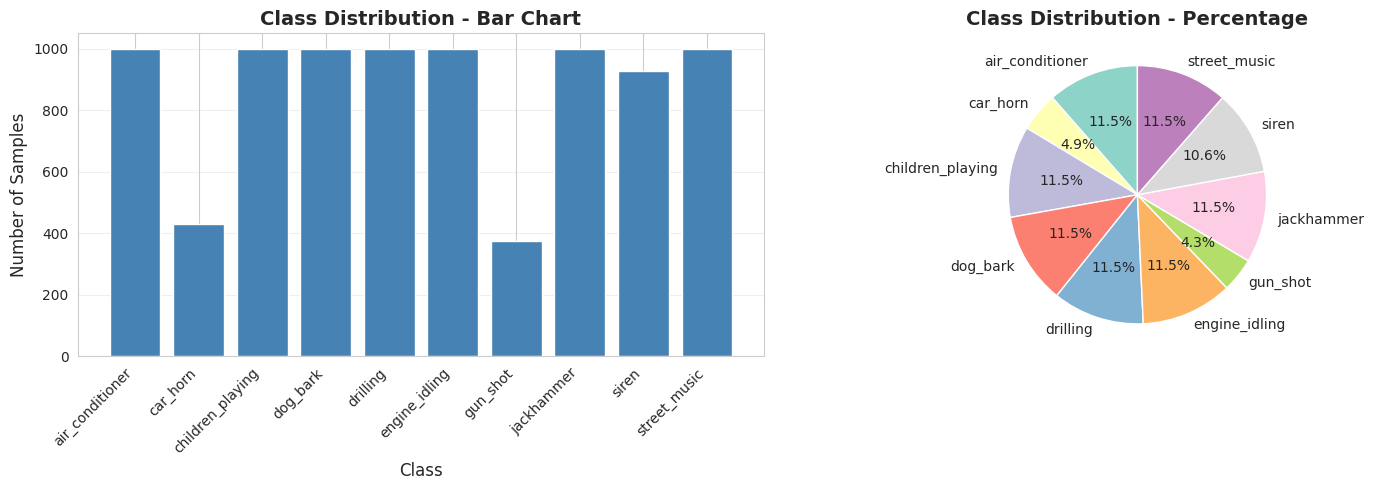

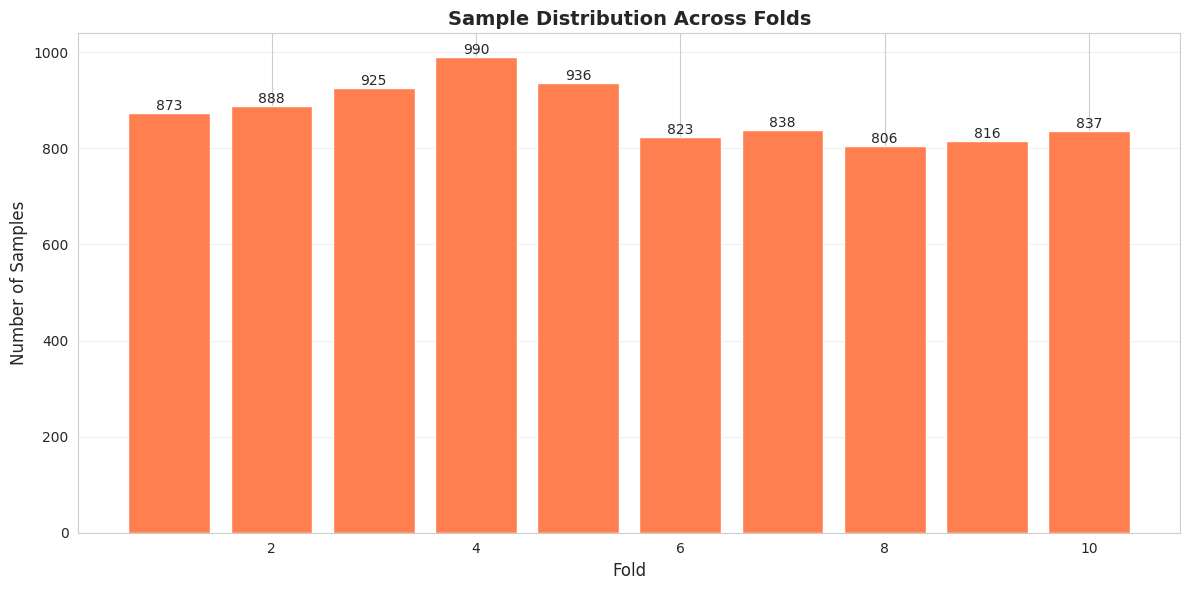

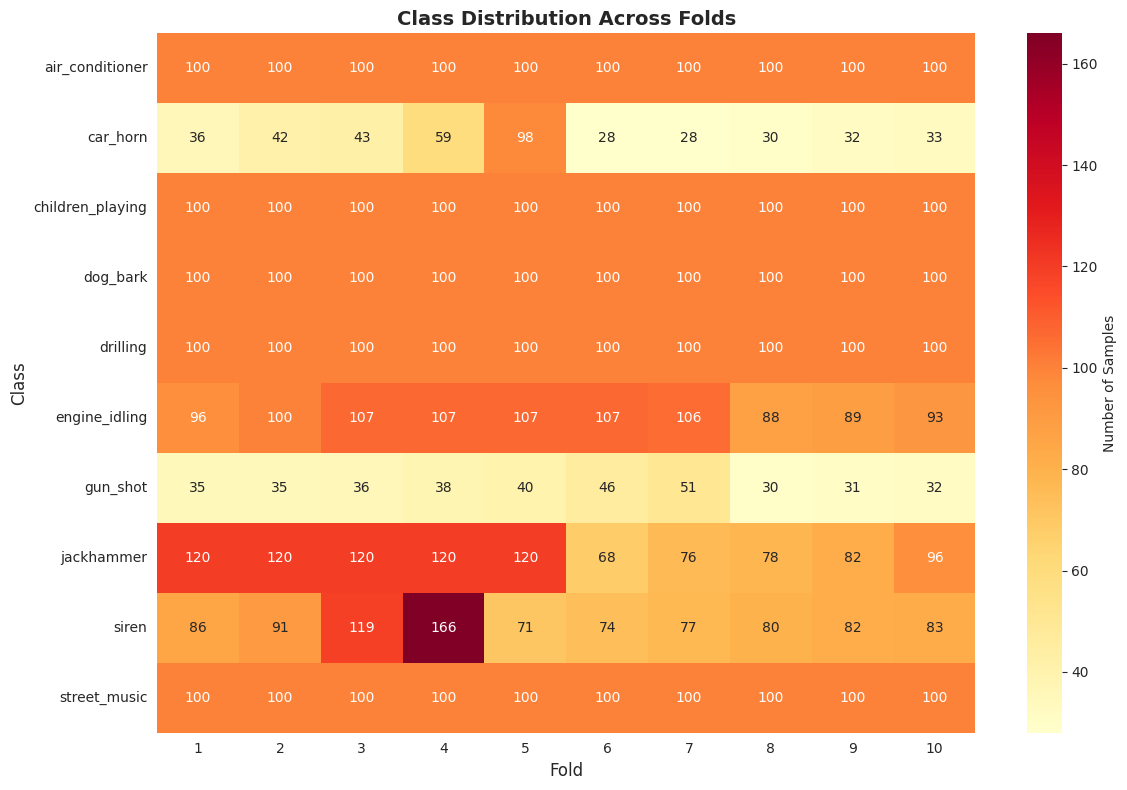

In [30]:
plot_class_distribution(df)
plot_fold_distribution(df)
plot_class_fold_heatmap(df)

In [31]:
def get_audio_path(df, audio_base_path, index=0):
    """
        Helper function to get a valid audio file path from the dataframe
        """
    row = df.iloc[index]
    file_path = os.path.join(audio_base_path, f"fold{row['fold']}", row['slice_file_name'])
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Audio file not found: {file_path}")
    
    return file_path, row['class']

def get_class_audio_path(df, audio_base_path, class_name, index=0):
    """
        Get audio file path for a specific class
        """
    class_df = df[df['class'] == class_name]
    
    if len(class_df) == 0:
        raise ValueError(f"No samples found for class: {class_name}")
    
    if index >= len(class_df):
        raise ValueError(f"Index {index} out of range. Class has {len(class_df)} samples")
    
    row = class_df.iloc[index]
    file_path = os.path.join(audio_base_path, f"fold{row['fold']}", row['slice_file_name'])
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Audio file not found: {file_path}")
    
    return file_path, row['class']


Audio Analysis: dog_bark
Duration: 0.32 seconds
Sample rate: 22050 Hz
Number of samples: 7002
Max amplitude: 0.9859
Mean amplitude: 0.0901


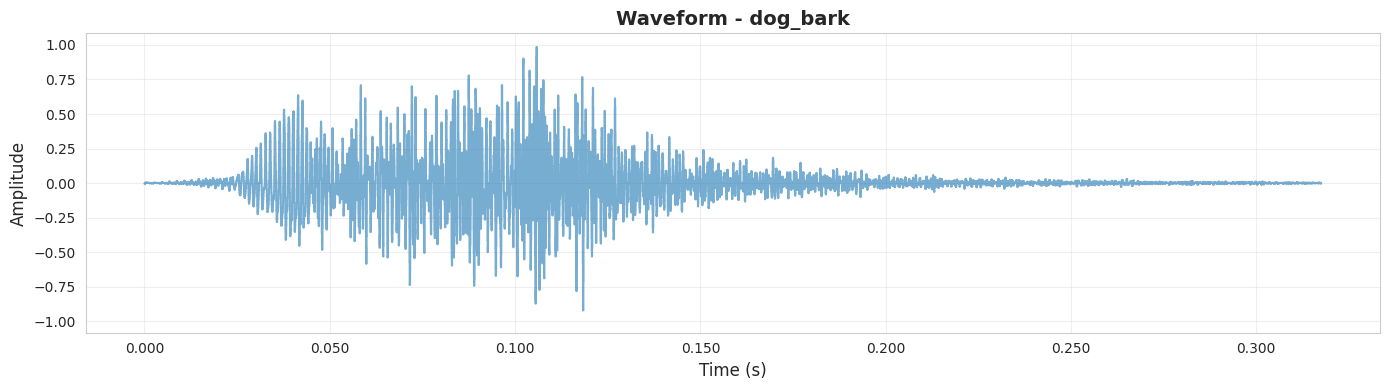

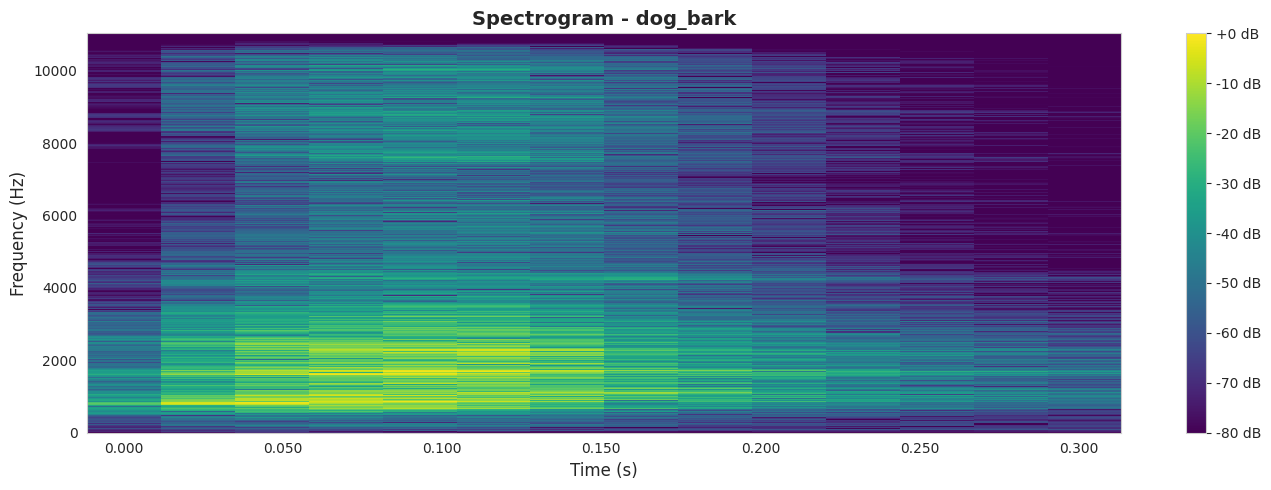

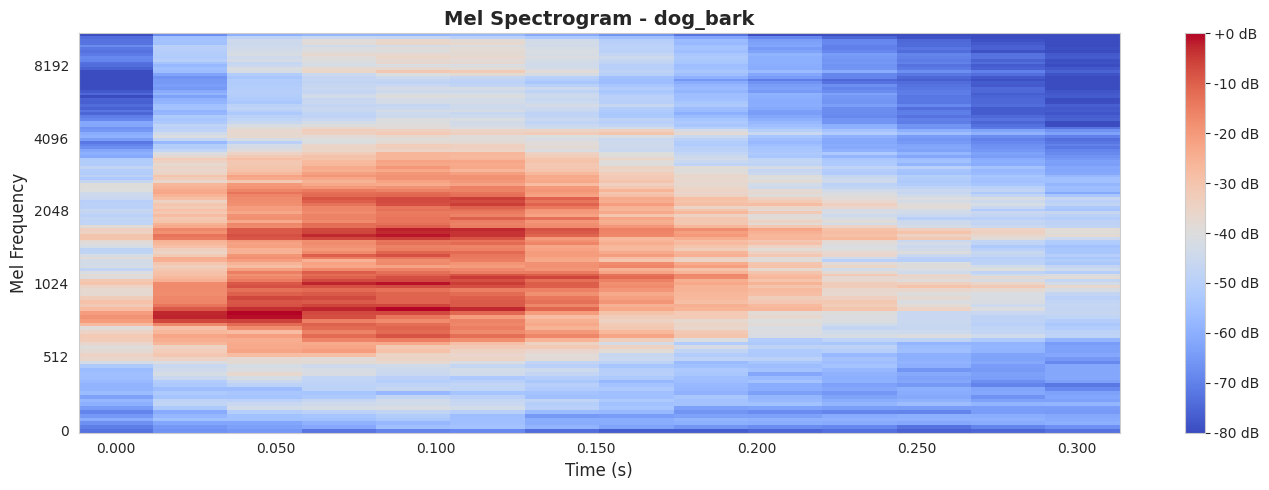

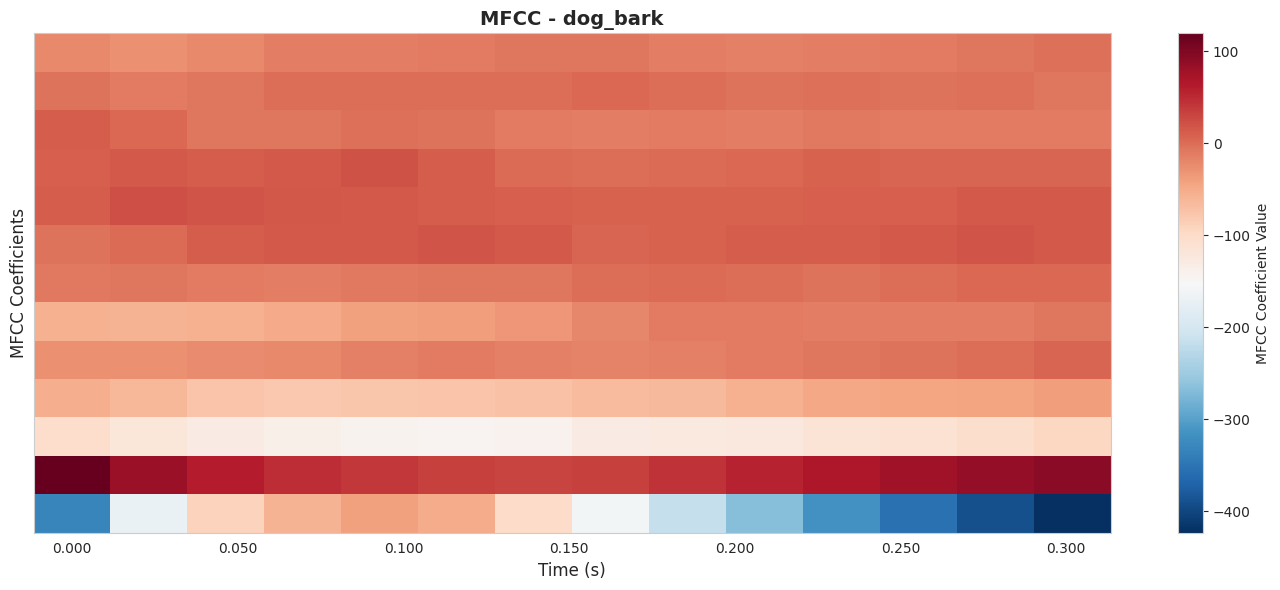

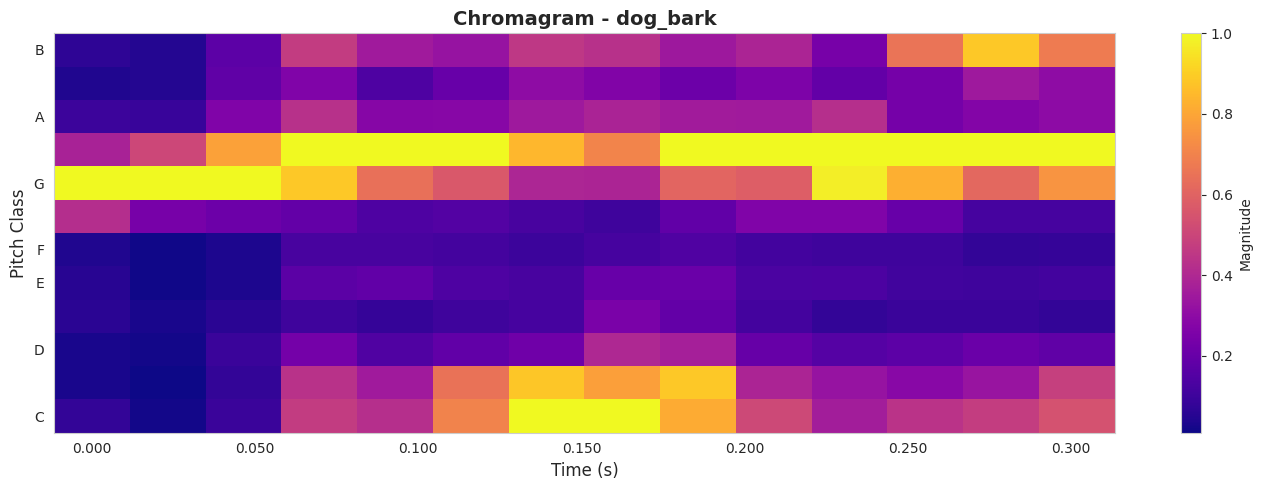

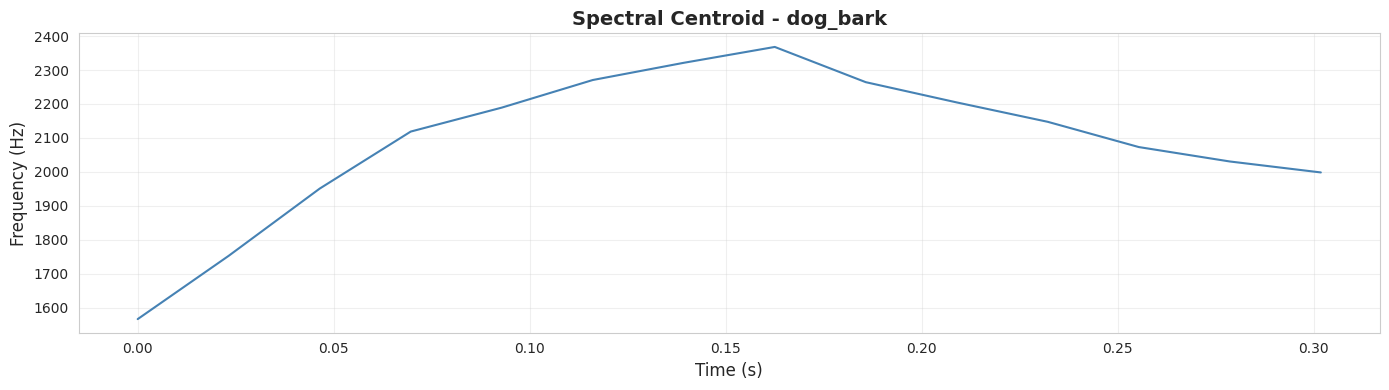

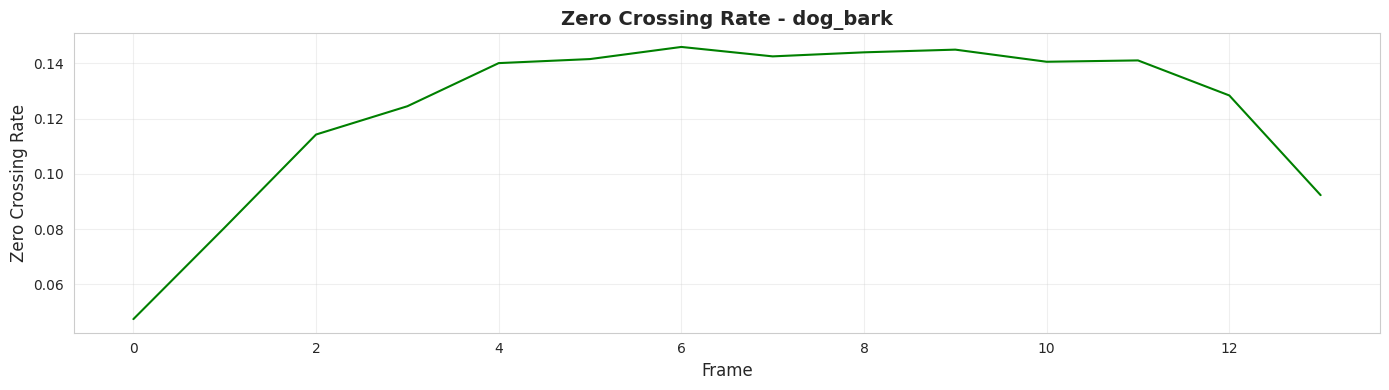

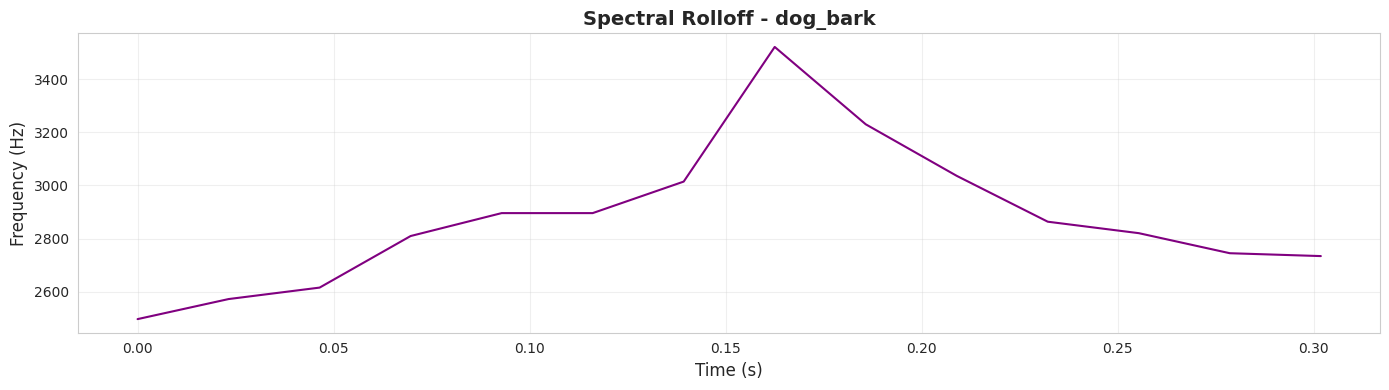

In [32]:
file_path, class_name = get_class_audio_path(df, AUDIO_BASE_PATH, 'dog_bark', index=0)
analyze_audio_comprehensive(file_path, class_name=class_name)

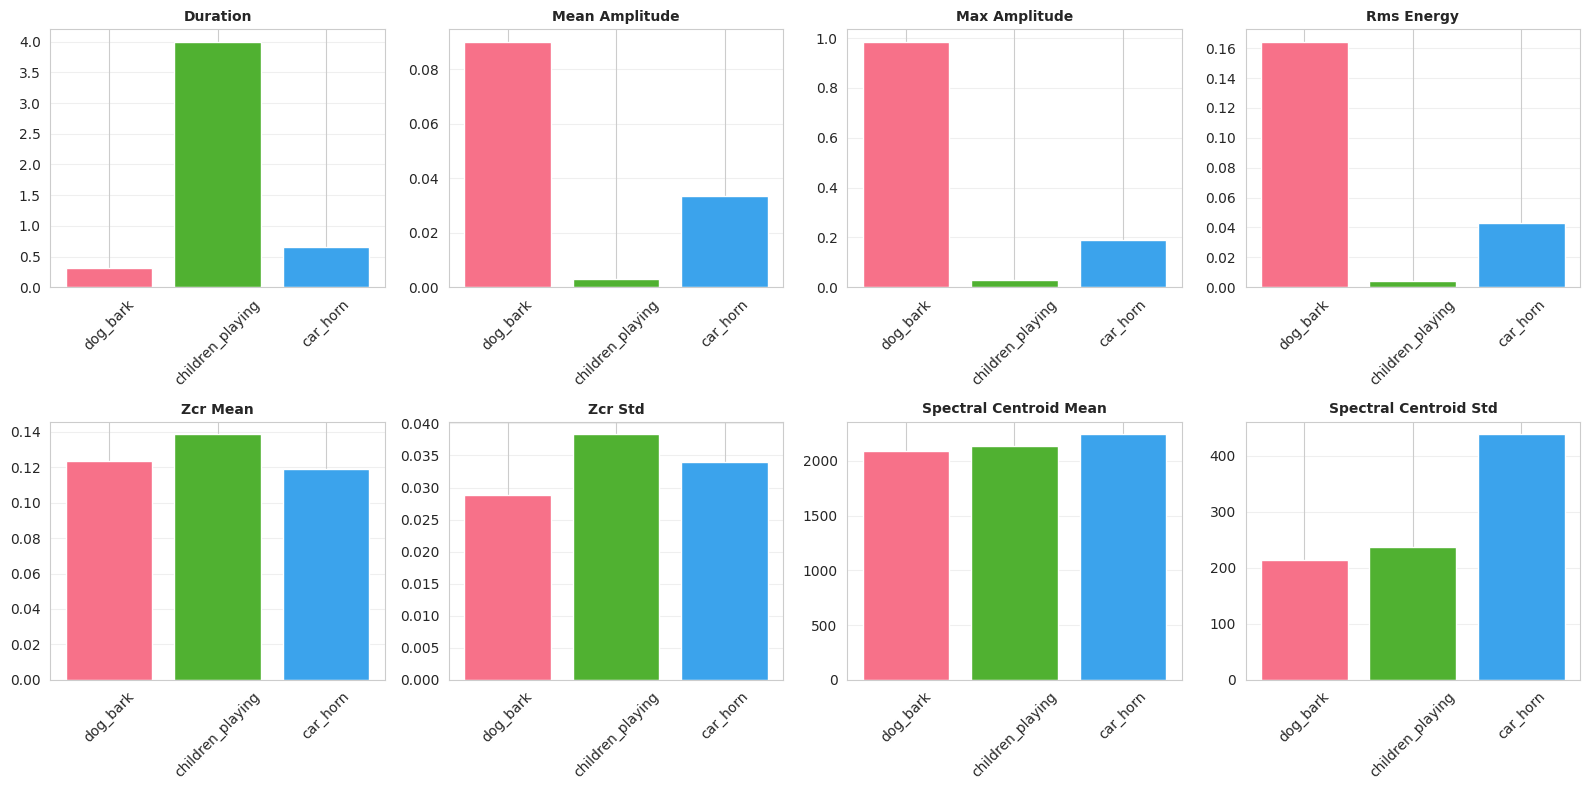

   duration  mean_amplitude  max_amplitude  rms_energy  zcr_mean   zcr_std  \
0  0.317551        0.090059       0.985863    0.164392  0.123465  0.028894   
1  4.000000        0.003199       0.027128    0.004148  0.138779  0.038332   
2  0.648526        0.033357       0.188049    0.043128  0.119106  0.033918   

   spectral_centroid_mean  spectral_centroid_std  spectral_rolloff_mean  \
0             2089.849972             213.673961            2875.451660   
1             2137.808991             238.140820            3996.089516   
2             2244.903034             439.042142            5062.225342   

   spectral_rolloff_std  ...  mfcc_9_std  mfcc_10_mean  mfcc_10_std  \
0            258.188926  ...    5.794312     -6.529818     6.873730   
1            203.105544  ...    7.748555     -3.584725     8.529496   
2           1358.936735  ...    9.620090    -10.587378     4.380539   

   mfcc_11_mean  mfcc_11_std  mfcc_12_mean  mfcc_12_std  chroma_mean  \
0     -2.996104     3.670339 

In [33]:
file_paths = []
class_names = []
for class_name in ['dog_bark', 'children_playing', 'car_horn']:
    fp, cn = get_class_audio_path(df, AUDIO_BASE_PATH, class_name, index=0)
    file_paths.append(fp)
    class_names.append(cn)

features_comparison = compare_classes_features(file_paths, class_names)
print(features_comparison)


--- Sample 115 ---
File: 102853-8-0-0.wav


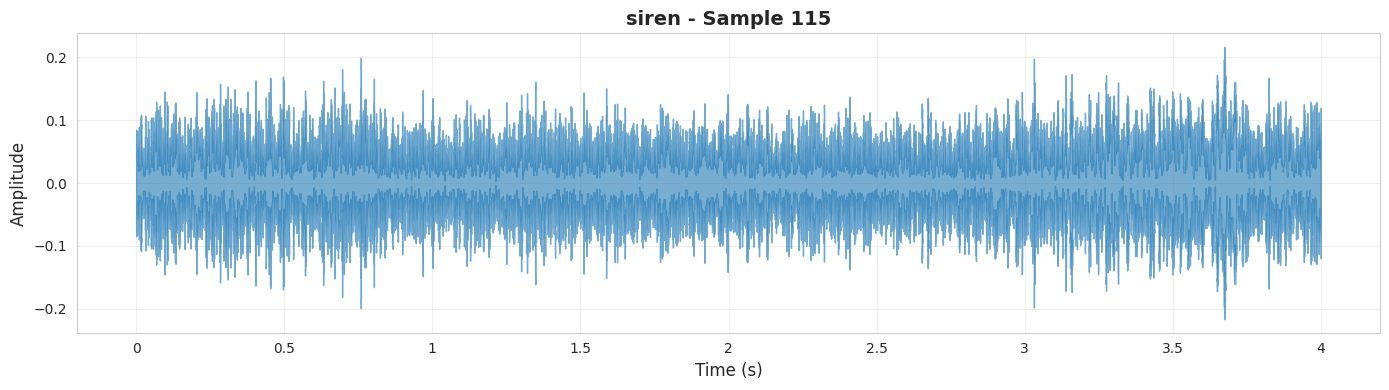

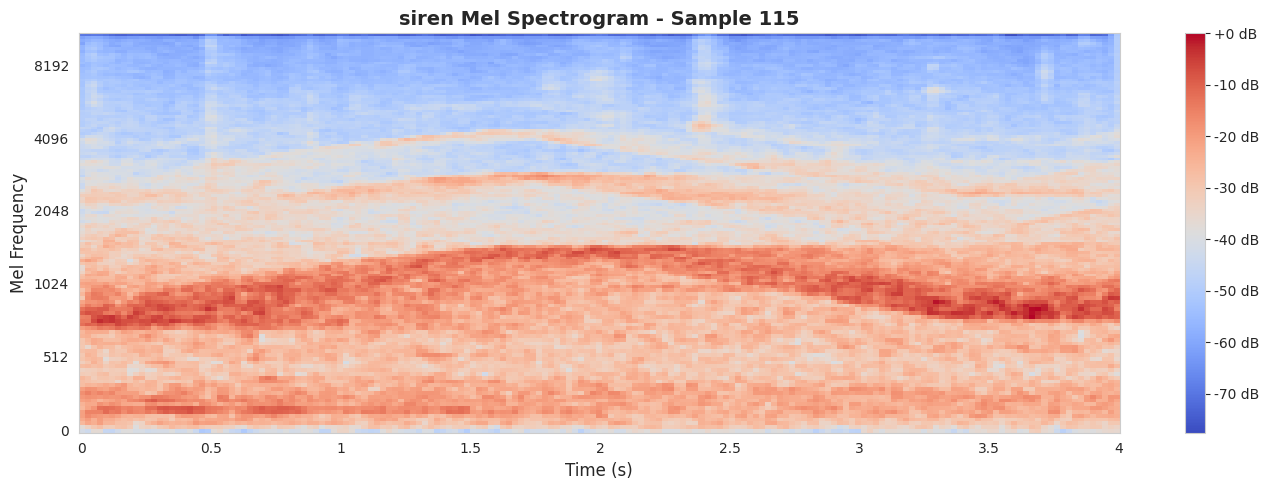


--- Sample 116 ---
File: 102853-8-0-1.wav


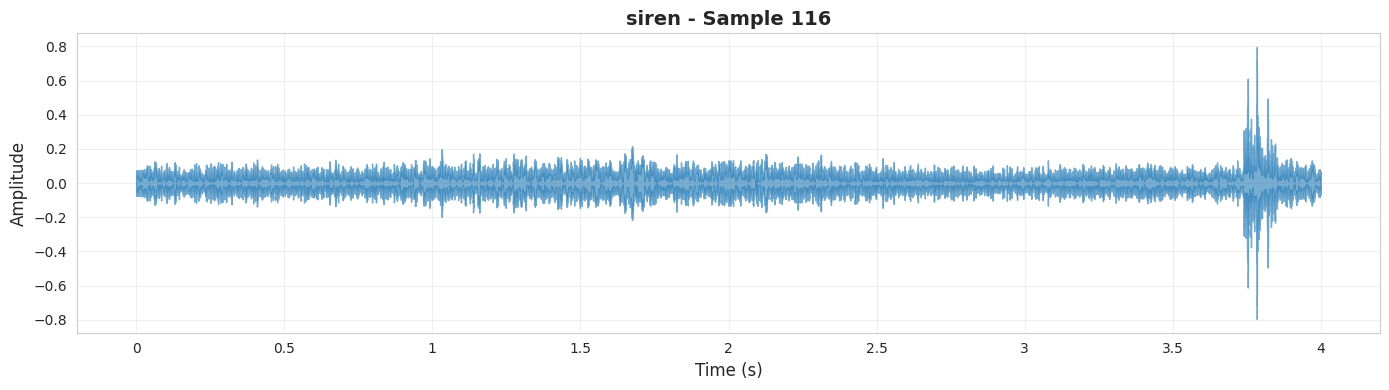

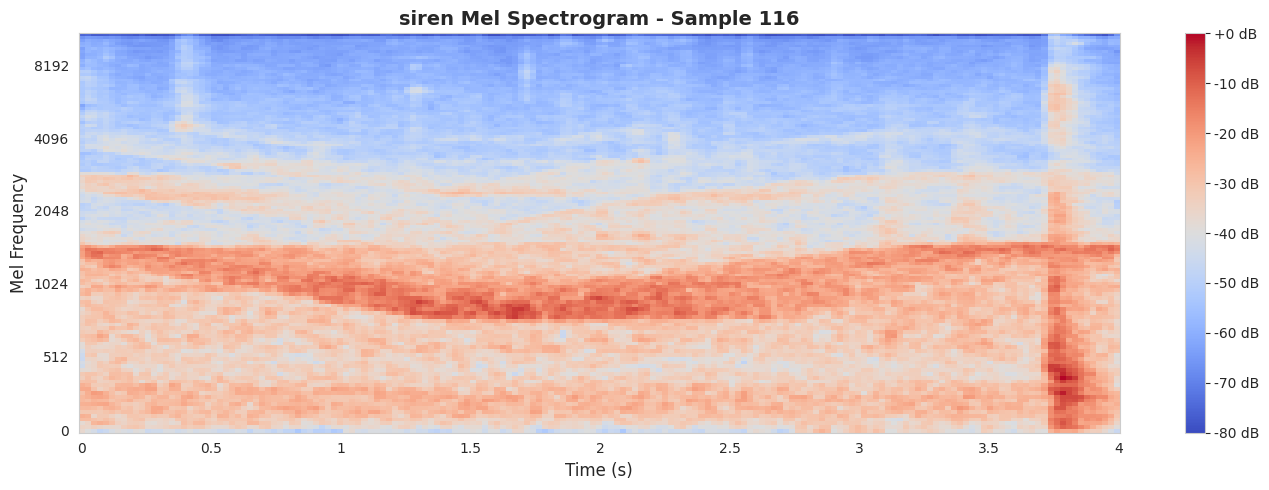


--- Sample 117 ---
File: 102853-8-0-2.wav


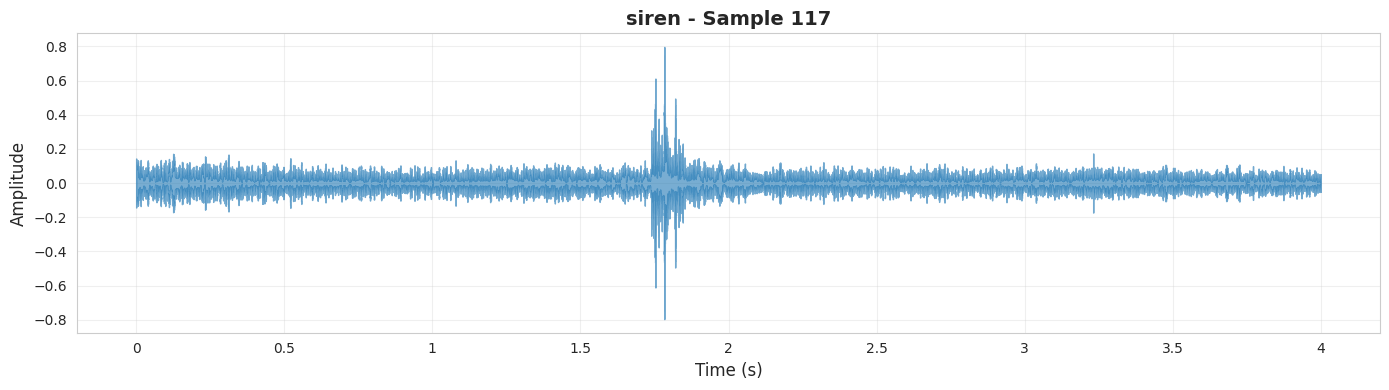

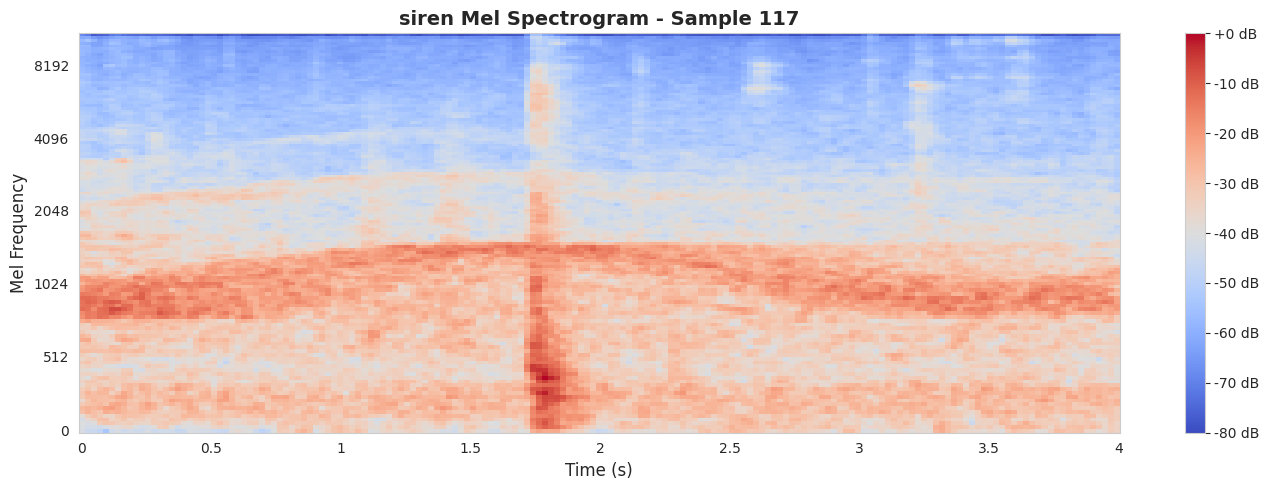

In [34]:
analyze_class_samples(df, 'UrbanSound8K/audio', 'siren', num_samples=3)

In [35]:
def process_channels(audio, mode='mono'):
    """
    Process audio channels (mono/stereo/average)
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio array, shape (samples,) or (samples, channels)
    mode : str
        'mono' - take first channel only
        'stereo' - convert to stereo (duplicate if mono)
        'avg' - average all channels
        'original' - keep as is
    
    Returns:
    --------
    np.ndarray : Processed audio
    """
    if mode == 'mono':
        new_audio = audio if audio.ndim == 1 else audio[:, :1]
    elif mode == 'stereo':
        new_audio = np.stack([audio]*2).T if audio.ndim == 1 else audio
    elif mode == 'avg':
        new_audio = audio.mean(axis=1) if audio.ndim > 1 else audio
        new_audio = new_audio[:, None]
    else:
        new_audio = audio
    return new_audio

In [36]:
def add_noise(audio, prob=0.5, noise_factor=0.005, noise_type='normal'):
    """
    Add random noise to audio signal
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    prob : float
        Probability of applying noise (0-1)
    noise_factor : float
        Standard deviation/range of noise
    noise_type : str
        'normal' - Gaussian noise
        'uniform' - Uniform noise
        'half' - Half-normal (non-negative) noise
    
    Returns:
    --------
    np.ndarray : Noisy audio
    """
    if np.random.rand() > prob:
        return audio
    
    length = audio.shape[0]
    
    if noise_type == 'normal':
        noise = np.random.normal(0, noise_factor, length)
    elif noise_type == 'uniform':
        noise = np.random.uniform(-noise_factor, noise_factor, length)
    elif noise_type == 'half':
        noise = np.clip(np.abs(np.random.normal(0, noise_factor, length)), 
                       a_min=0.0, a_max=0.8)
    else:
        raise ValueError(f'Unknown noise type: {noise_type}')
    
    noise = noise[:, None] if audio.ndim > 1 else noise
    return audio + noise.astype(np.float32)

In [37]:
def random_crop(audio, prob=0.5, max_crop_ratio=0.3):
    """
    Randomly crop audio to shorter duration
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    prob : float
        Probability of applying crop
    max_crop_ratio : float
        Maximum ratio to crop (0-0.9)
    
    Returns:
    --------
    np.ndarray : Cropped audio
    """
    if np.random.rand() > prob:
        return audio
    
    # Generate random crop ratio
    crop_ratio = np.random.uniform(0, max_crop_ratio)
    crop_ratio = np.clip(crop_ratio, 0, 0.9)
    
    # Calculate new length
    length = audio.shape[0]
    new_length = int(np.round(length * (1 - crop_ratio)))
    
    # Random start position
    max_start = length - new_length + 1
    ind_start = np.random.randint(0, max_start)
    ind_end = ind_start + new_length
    
    cropped = audio[ind_start:ind_end]
    
    # Avoid zero tensor
    if np.sum(np.abs(cropped)) == 0:
        cropped = cropped + 1e-8
    
    return cropped

In [38]:
def modify_duration(audio, target_duration):
    """
    Modify audio to target duration (crop or pad/repeat)
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    target_duration : int
        Target number of samples
    
    Returns:
    --------
    np.ndarray : Modified audio
    """
    current_length = len(audio)
    
    if target_duration < current_length:
        # Crop randomly
        max_index_start = current_length - target_duration
        index_start = np.random.randint(0, max_index_start + 1)
        index_end = index_start + target_duration
        new_audio = audio[index_start:index_end]
    else:
        # Pad by repeating
        ratio = target_duration / current_length
        full_reps = int(ratio)
        remaining = int(np.round(current_length * (ratio % 1)))
        
        repeated = [audio] * full_reps
        if remaining > 0:
            repeated.append(audio[:remaining])
        
        new_audio = np.concatenate(repeated, axis=0)
    
    return new_audio

In [39]:
def modify_duration(audio, target_duration):
    """
    Modify audio to target duration (crop or pad/repeat)
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    target_duration : int
        Target number of samples
    
    Returns:
    --------
    np.ndarray : Modified audio
    """
    current_length = len(audio)
    
    if target_duration < current_length:
        # Crop randomly
        max_index_start = current_length - target_duration
        index_start = np.random.randint(0, max_index_start + 1)
        index_end = index_start + target_duration
        new_audio = audio[index_start:index_end]
    else:
        # Pad by repeating
        ratio = target_duration / current_length
        full_reps = int(ratio)
        remaining = int(np.round(current_length * (ratio % 1)))
        
        repeated = [audio] * full_reps
        if remaining > 0:
            repeated.append(audio[:remaining])
        
        new_audio = np.concatenate(repeated, axis=0)
    
    return new_audio

In [40]:
def augment_audio(audio, prob=0.5, noise_factor=0.01, noise_type='uniform'):
    """
    Apply general augmentation (similar to AugmentationTransform)
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    prob : float
        Probability of applying augmentation
    noise_factor : float
        Magnitude of augmentation
    noise_type : str
        Type of noise distribution
    
    Returns:
    --------
    np.ndarray : Augmented audio
    """
    if np.random.rand() > prob:
        return audio
    
    if noise_type == 'normal':
        noise = np.random.normal(0, noise_factor, audio.shape)
    elif noise_type == 'uniform':
        noise = np.random.uniform(-noise_factor, noise_factor, audio.shape)
    elif noise_type == 'half':
        noise = np.clip(np.abs(np.random.normal(0, noise_factor, audio.shape)),
                       a_min=0.0, a_max=0.8)
    else:
        raise ValueError(f'Unknown noise type: {noise_type}')
    
    return audio + noise.astype(np.float32)

In [41]:
def preprocess_audio_pipeline(audio, sr, mode='train', 
                              channel_mode='mono',
                              noise_prob=0.5, noise_factor=0.005, noise_type='normal',
                              crop_prob=0.5, max_crop_ratio=0.3,
                              augment_prob=0.5, augment_factor=0.01, augment_type='uniform',
                              target_duration=None):
    """
    Complete preprocessing pipeline for audio
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal from librosa.load
    sr : int
        Sample rate
    mode : str
        'train' - Apply all augmentations
        'val' or 'test' - Only channel processing
    channel_mode : str
        Channel processing mode
    noise_prob, noise_factor, noise_type : 
        Parameters for additive noise
    crop_prob, max_crop_ratio :
        Parameters for random cropping
    augment_prob, augment_factor, augment_type :
        Parameters for general augmentation
    target_duration : int or None
        If specified, resize to this many samples
    
    Returns:
    --------
    np.ndarray : Preprocessed audio
    """
    # Ensure 2D shape (samples, channels)
    if audio.ndim == 1:
        audio = audio[:, None]
    
    # Step 1: Process channels
    audio = process_channels(audio, mode=channel_mode)
    
    if mode == 'train':
        # Step 2: Add noise
        audio = add_noise(audio, prob=noise_prob, 
                         noise_factor=noise_factor, 
                         noise_type=noise_type)
        
        # Step 3: Random crop
        audio = random_crop(audio, prob=crop_prob, 
                           max_crop_ratio=max_crop_ratio)
        
        # Step 4: General augmentation
        audio = augment_audio(audio, prob=augment_prob,
                            noise_factor=augment_factor,
                            noise_type=augment_type)
    
    # Step 5: Modify duration if specified
    if target_duration is not None:
        audio = modify_duration(audio, target_duration)
    
    return audio

In [42]:
def preprocess_dataset(df, audio_base_path, mode='train', 
                      channel_mode='mono', sr=22050,
                      noise_prob=0.5, noise_factor=0.005,
                      crop_prob=0.5, max_crop_ratio=0.3,
                      augment_prob=0.5, augment_factor=0.01,
                      target_duration=None,
                      num_samples=None):
    """
    Preprocess entire dataset or subset
    
    Parameters:
    -----------
    df : pd.DataFrame
        UrbanSound8K metadata
    audio_base_path : str
        Base path to audio files
    mode : str
        'train' or 'val'/'test'
    channel_mode : str
        Channel processing mode
    sr : int
        Sample rate for loading
    Other parameters : preprocessing parameters
    num_samples : int or None
        If specified, only process this many samples
    
    Returns:
    --------
    dict : {'audio': list of arrays, 'labels': list, 'original_sr': sr}
    """
    processed_data = {
        'audio': [],
        'labels': [],
        'filenames': [],
        'sample_rate': sr
    }
    
    # Select subset if specified
    df_subset = df.head(num_samples) if num_samples else df
    
    print(f"Processing {len(df_subset)} audio files in {mode} mode...")
    
    for idx, row in df_subset.iterrows():
        file_path = os.path.join(audio_base_path, 
                                f"fold{row['fold']}", 
                                row['slice_file_name'])
        
        if not os.path.exists(file_path):
            print(f"Warning: File not found - {file_path}")
            continue
        
        try:
            # Load audio
            y, _ = librosa.load(file_path, sr=sr)
            
            # Apply preprocessing pipeline
            y_processed = preprocess_audio_pipeline(
                y, sr, mode=mode,
                channel_mode=channel_mode,
                noise_prob=noise_prob,
                noise_factor=noise_factor,
                crop_prob=crop_prob,
                max_crop_ratio=max_crop_ratio,
                augment_prob=augment_prob,
                augment_factor=augment_factor,
                target_duration=target_duration
            )
            
            processed_data['audio'].append(y_processed)
            processed_data['labels'].append(row['classID'])
            processed_data['filenames'].append(row['slice_file_name'])
            
            if (idx + 1) % 100 == 0:
                print(f"Processed {idx + 1}/{len(df_subset)} files")
                
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            continue
    
    print(f"Successfully processed {len(processed_data['audio'])} files")
    return processed_data

In [43]:
def visualize_preprocessing_comparison(original_audio, processed_audio, sr, 
                                      original_label="Original", 
                                      processed_label="Processed"):
    """
    Visualize original vs preprocessed audio
    
    Parameters:
    -----------
    original_audio : np.ndarray
        Original audio signal
    processed_audio : np.ndarray
        Preprocessed audio signal
    sr : int
        Sample rate
    original_label, processed_label : str
        Labels for plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    
    # Flatten for mono comparison
    orig = original_audio.flatten() if original_audio.ndim > 1 else original_audio
    proc = processed_audio.flatten() if processed_audio.ndim > 1 else processed_audio
    
    # Waveforms
    librosa.display.waveshow(orig, sr=sr, ax=axes[0, 0], alpha=0.6, color='blue')
    axes[0, 0].set_title(f'Waveform - {original_label}', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude')
    
    librosa.display.waveshow(proc, sr=sr, ax=axes[0, 1], alpha=0.6, color='red')
    axes[0, 1].set_title(f'Waveform - {processed_label}', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Amplitude')
    
    # Spectrograms
    D_orig = librosa.amplitude_to_db(np.abs(librosa.stft(orig)), ref=np.max)
    D_proc = librosa.amplitude_to_db(np.abs(librosa.stft(proc)), ref=np.max)
    
    img1 = librosa.display.specshow(D_orig, sr=sr, x_axis='time', y_axis='hz', 
                                     ax=axes[1, 0], cmap='viridis')
    axes[1, 0].set_title(f'Spectrogram - {original_label}', fontsize=12, fontweight='bold')
    fig.colorbar(img1, ax=axes[1, 0], format='%+2.0f dB')
    
    img2 = librosa.display.specshow(D_proc, sr=sr, x_axis='time', y_axis='hz', 
                                     ax=axes[1, 1], cmap='viridis')
    axes[1, 1].set_title(f'Spectrogram - {processed_label}', fontsize=12, fontweight='bold')
    fig.colorbar(img2, ax=axes[1, 1], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

In [44]:
def analyze_preprocessing_effects(df, audio_base_path, num_samples=5, sr=22050):
    """
    Analyze effects of different preprocessing techniques
    
    Parameters:
    -----------
    df : pd.DataFrame
        Metadata dataframe
    audio_base_path : str
        Path to audio files
    num_samples : int
        Number of samples to analyze
    sr : int
        Sample rate
    """
    print("Analyzing preprocessing effects on sample audios...\n")
    
    for i in range(min(num_samples, len(df))):
        row = df.iloc[i]
        file_path = os.path.join(audio_base_path, f"fold{row['fold']}", row['slice_file_name'])
        
        if not os.path.exists(file_path):
            continue
        
        # Load original
        y_orig, _ = librosa.load(file_path, sr=sr)
        
        print(f"\n{'='*60}")
        print(f"Sample {i+1}: {row['class']} - {row['slice_file_name']}")
        print(f"{'='*60}")
        print(f"Original shape: {y_orig.shape}")
        print(f"Original duration: {len(y_orig)/sr:.2f}s")
        
        # Apply different preprocessing
        y_noise = add_noise(y_orig[:, None] if y_orig.ndim == 1 else y_orig, 
                           prob=1.0, noise_factor=0.01)
        print(f"After noise: shape {y_noise.shape}")
        
        y_crop = random_crop(y_orig[:, None] if y_orig.ndim == 1 else y_orig, 
                            prob=1.0, max_crop_ratio=0.3)
        print(f"After crop: shape {y_crop.shape}, duration {len(y_crop)/sr:.2f}s")
        
        y_full = preprocess_audio_pipeline(y_orig, sr, mode='train', 
                                          channel_mode='mono',
                                          noise_prob=1.0, crop_prob=1.0, 
                                          augment_prob=1.0)
        print(f"After full pipeline: shape {y_full.shape}")
        
        # Visualize
        visualize_preprocessing_comparison(y_orig, y_full.flatten(), sr,
                                          original_label=f"Original - {row['class']}",
                                          processed_label="Fully Preprocessed")

Analyzing preprocessing effects on sample audios...


Sample 1: dog_bark - 100032-3-0-0.wav
Original shape: (7002,)
Original duration: 0.32s
After noise: shape (7002, 1)
After crop: shape (5928, 1), duration 0.27s
After full pipeline: shape (5370, 1)


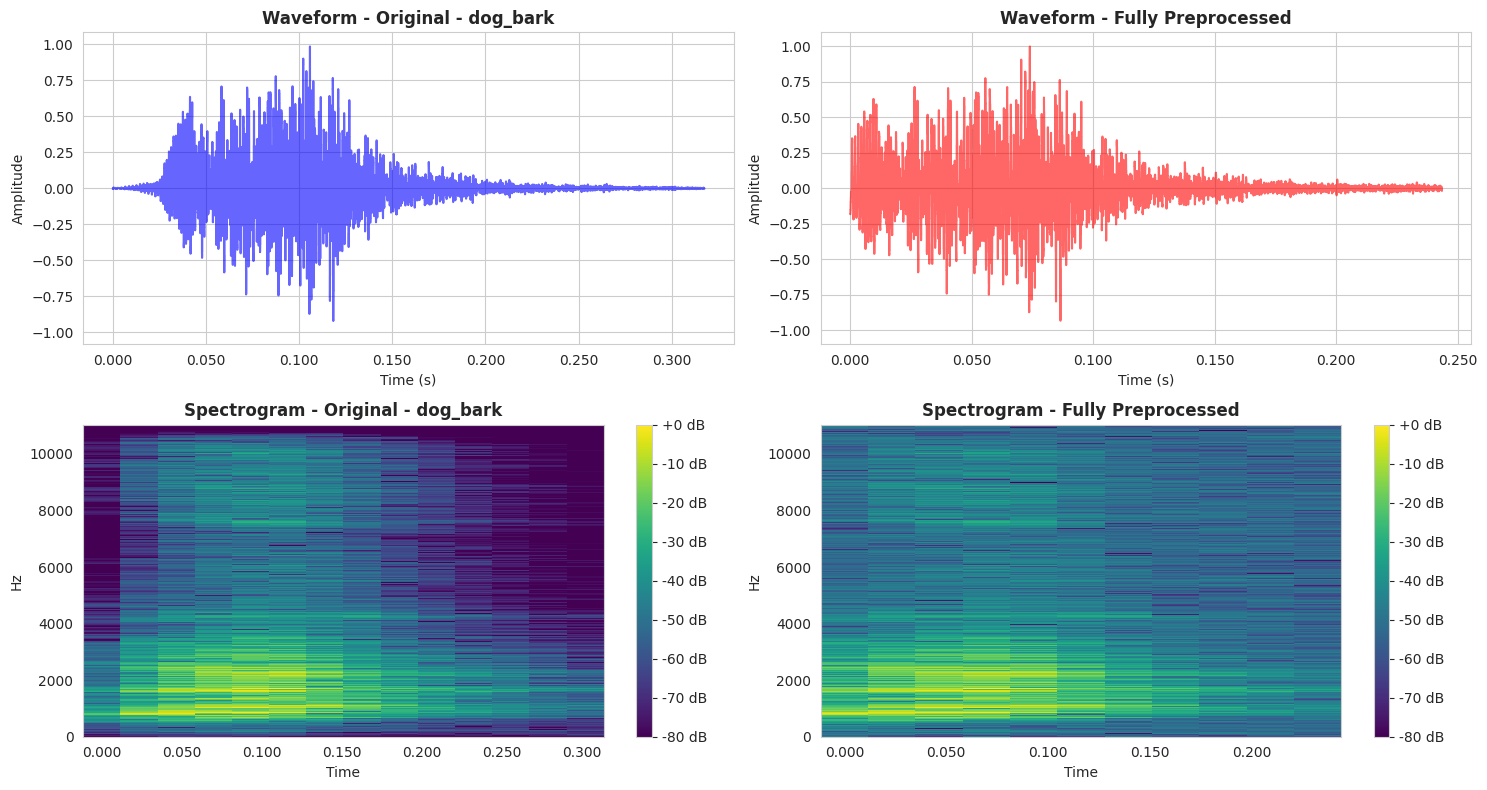


Sample 2: children_playing - 100263-2-0-117.wav
Original shape: (88200,)
Original duration: 4.00s
After noise: shape (88200, 1)
After crop: shape (63163, 1), duration 2.86s
After full pipeline: shape (71866, 1)


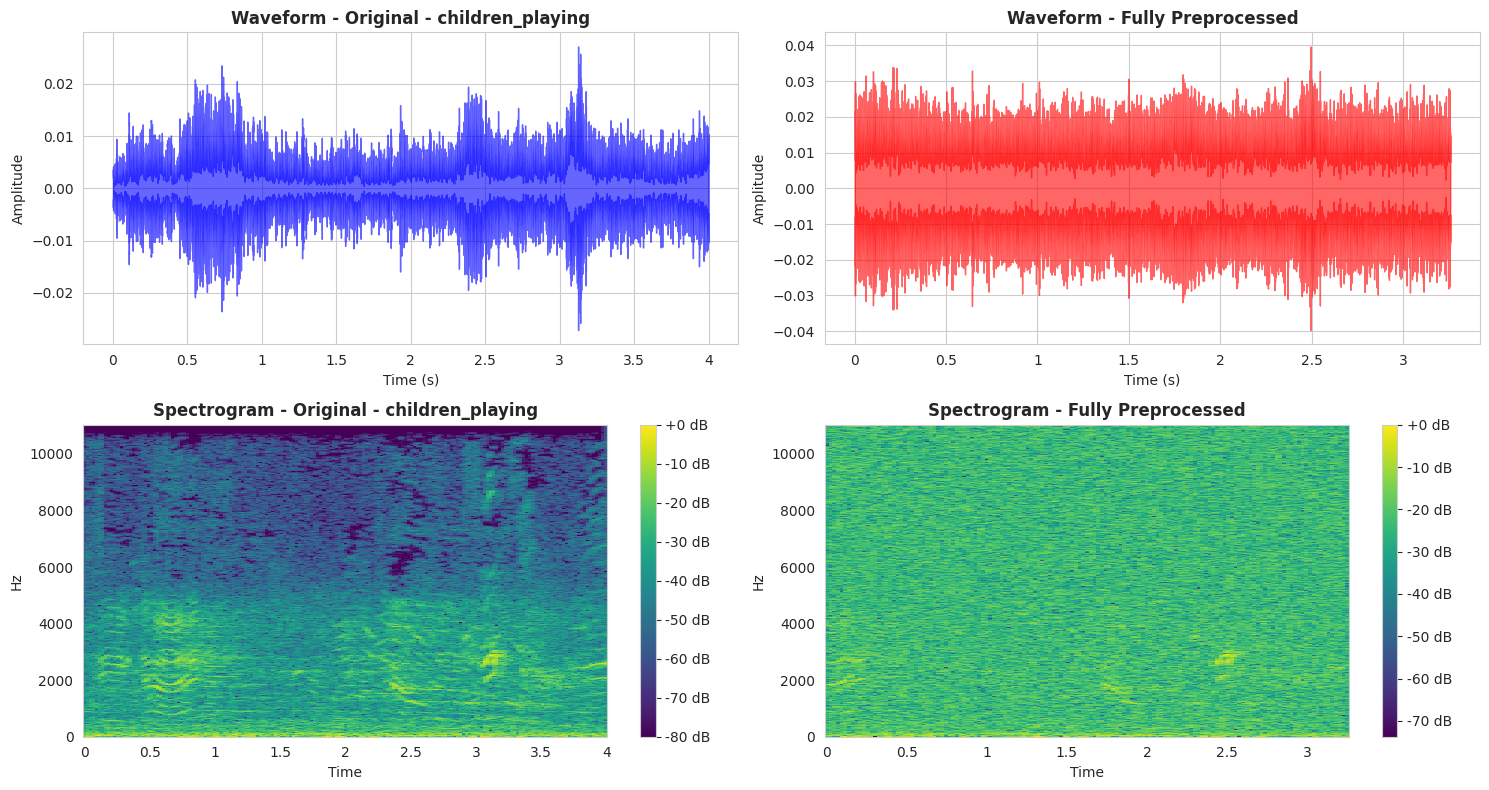


Sample 3: children_playing - 100263-2-0-121.wav
Original shape: (88200,)
Original duration: 4.00s
After noise: shape (88200, 1)
After crop: shape (87950, 1), duration 3.99s
After full pipeline: shape (74377, 1)


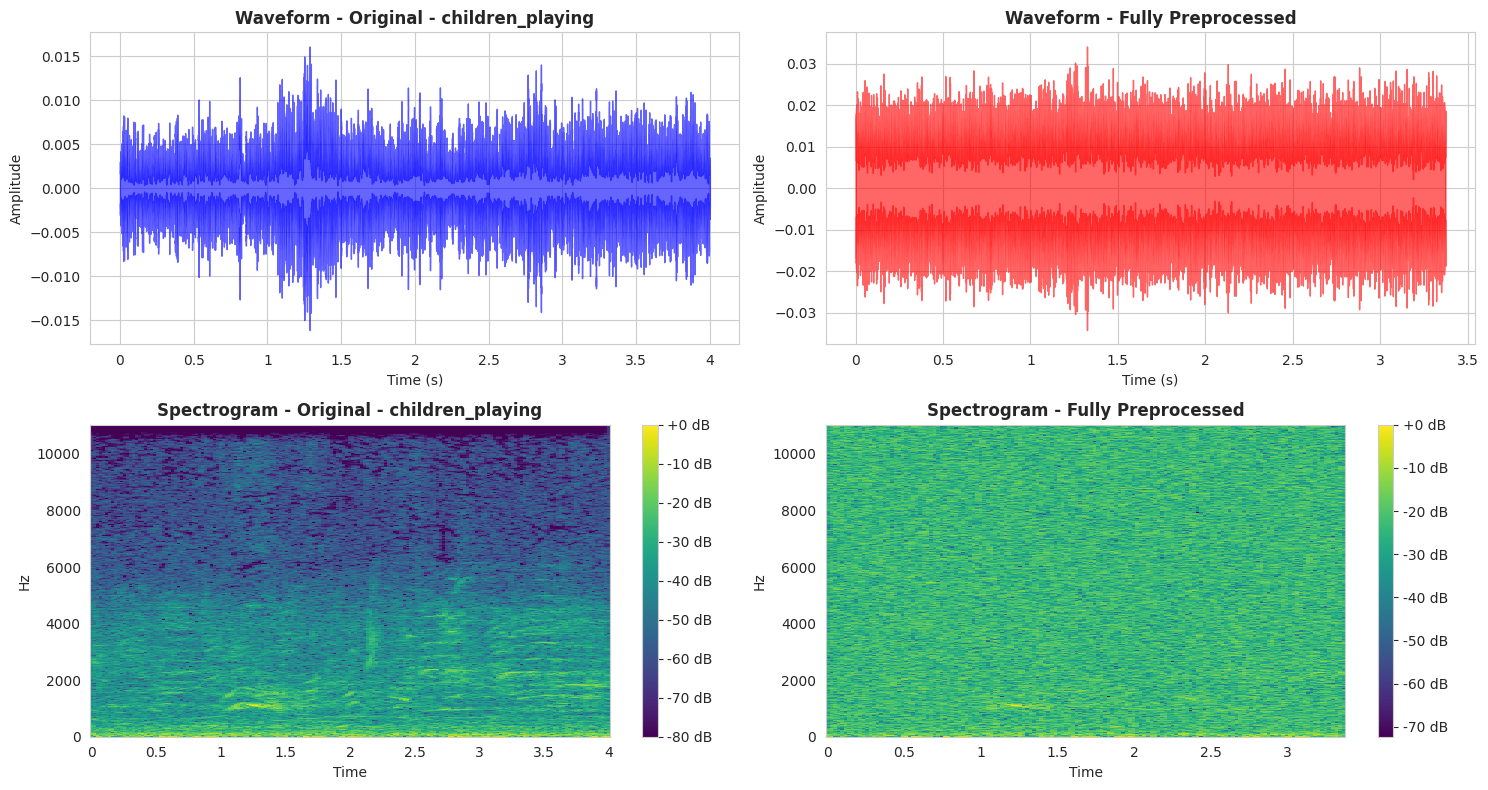

In [45]:
analyze_preprocessing_effects(df, AUDIO_BASE_PATH, num_samples=3, sr=22050)

In [46]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import defaultdict

In [47]:
class AudioDataset(Dataset):
    """
    Dataset class for audio data
    """
    def __init__(self, audio_data, labels, transform=None):
        """
        Parameters:
        -----------
        audio_data : list or np.ndarray
            List of audio arrays
        labels : list or np.ndarray
            Corresponding labels
        transform : callable, optional
            Optional transform to apply
        """
        self.audio_data = audio_data
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.audio_data)
    
    def __getitem__(self, idx):
        audio = self.audio_data[idx]
        label = self.labels[idx]
        
        # Convert to tensor if not already
        if not isinstance(audio, torch.Tensor):
            audio = torch.FloatTensor(audio)
        
        if not isinstance(label, torch.Tensor):
            label = torch.LongTensor([label])[0]
        
        if self.transform:
            audio = self.transform(audio)
        
        return audio, label

In [48]:
def accuracy(output, target):
    """Calculate accuracy"""
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        assert pred.shape[0] == len(target)
        correct = torch.sum(pred == target).item()
    return correct / len(target)

def top_k_accuracy(output, target, k=3):
    """Calculate top-k accuracy"""
    with torch.no_grad():
        pred = torch.topk(output, k, dim=1)[1]
        assert pred.shape[0] == len(target)
        correct = 0
        for i in range(k):
            correct += torch.sum(pred[:, i] == target).item()
    return correct / len(target)

In [49]:
def evaluate_model(model, test_dataset, batch_size=32, device=None, metrics=None):
    """
    Evaluate model on test dataset
    
    Parameters:
    -----------
    model : nn.Module
        Trained model
    test_dataset : Dataset or dict
        Test dataset
    batch_size : int
        Batch size
    device : str or torch.device, optional
        Device to use
    metrics : list of callable, optional
        Metrics to compute
    
    Returns:
    --------
    dict : Evaluation results
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Convert dict to Dataset if needed
    if isinstance(test_dataset, dict):
        test_dataset = AudioDataset(test_dataset['audio'], test_dataset['labels'])
    
    # Create data loader
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    
    # Setup metrics
    if metrics is None:
        metrics = [accuracy]
    
    model.eval()
    total_metrics = np.zeros(len(metrics))
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            
            # Track metrics
            for i, metric in enumerate(metrics):
                total_metrics[i] += metric(output, target)
            
            # Store predictions
            pred = torch.argmax(output, dim=1)
            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Calculate average metrics
    avg_metrics = total_metrics / len(test_loader)
    
    results = {
        'predictions': np.array(all_predictions),
        'targets': np.array(all_targets)
    }
    
    for i, metric in enumerate(metrics):
        metric_name = metric.__name__ if hasattr(metric, '__name__') else f'metric_{i}'
        results[metric_name] = avg_metrics[i]
    
    print("\nEvaluation Results:")
    print("=" * 40)
    for i, metric in enumerate(metrics):
        metric_name = metric.__name__ if hasattr(metric, '__name__') else f'metric_{i}'
        print(f"{metric_name}: {avg_metrics[i]:.4f}")
    print("=" * 40)
    
    return results

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import Spectrogram, MelSpectrogram, TimeStretch, AmplitudeToDB
from torch.distributions import Uniform
from tqdm import tqdm
from collections import defaultdict
from datetime import datetime

In [51]:
def _num_stft_bins(lengths, fft_length, hop_length, pad):
    return (lengths + 2 * pad - fft_length + hop_length) // hop_length

class RandomTimeStretch(TimeStretch):
    def __init__(self, max_perc, hop_length=None, n_freq=201, fixed_rate=None):
        super(RandomTimeStretch, self).__init__(hop_length, n_freq, fixed_rate)
        self._dist = Uniform(1.-max_perc, 1+max_perc)

    def forward(self, x):
        rate = self._dist.sample().item()
        return super(RandomTimeStretch, self).forward(x, rate), rate

class SpecNormalization(nn.Module):
    def __init__(self, norm_type, top_db=80.0):
        super(SpecNormalization, self).__init__()

        if 'db' == norm_type:
            self._norm = AmplitudeToDB(stype='power', top_db=top_db)
        elif 'whiten' == norm_type:
            self._norm = lambda x: self.z_transform(x)
        else:
            self._norm = lambda x: x
        
    def z_transform(self, x):
        # Independent mean, std per batch
        non_batch_inds = [1, 2, 3]
        mean = x.mean(non_batch_inds, keepdim=True)
        std = x.std(non_batch_inds, keepdim=True)
        x = (x - mean)/std 
        return x

    def forward(self, x):
        return self._norm(x)

class MelspectrogramStretch(MelSpectrogram):
    def __init__(self, hop_length=None, 
                       sample_rate=44100, 
                       num_mels=128, 
                       fft_length=2048, 
                       norm='whiten', 
                       stretch_param=[0.4, 0.4]):

        super(MelspectrogramStretch, self).__init__(sample_rate=sample_rate, 
                                                    n_fft=fft_length, 
                                                    hop_length=hop_length, 
                                                    n_mels=num_mels)

        self.stft = Spectrogram(n_fft=self.n_fft, win_length=self.win_length,
                                       hop_length=self.hop_length, pad=self.pad, 
                                       power=None, normalized=False)

        # Augmentation
        self.prob = stretch_param[0]
        self.random_stretch = RandomTimeStretch(stretch_param[1], 
                                                self.hop_length, 
                                                self.n_fft//2+1, 
                                                fixed_rate=None)
        
        # Normalization (post spec processing)
        self.complex_norm = lambda x: torch.abs(x).pow(2.0)
        self.norm = SpecNormalization(norm)

    def forward(self, x, lengths=None):
        x = self.stft(x)

        if lengths is not None:
            lengths = _num_stft_bins(lengths, self.n_fft, self.hop_length, self.n_fft//2)
            lengths = lengths.long()
        
        if torch.rand(1)[0] <= self.prob and self.training:
            # Stretch spectrogram in time using Phase Vocoder
            x, rate = self.random_stretch(x)
            # Modify the rate accordingly
            lengths = (lengths.float()/rate).long()+1
        
        x = self.complex_norm(x)
        x = self.mel_scale(x)

        # Normalize melspectrogram
        x = self.norm(x)

        if lengths is not None:
            return x, lengths        
        return x

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [58]:
class AudioRNN(nn.Module):
    def __init__(self, num_classes=10, config=None):
        super(AudioRNN, self).__init__()
        
        self.num_classes = num_classes
        self.config = config if config else {}
        
        # Spectrogram parameters
        self.sample_rate = self.config.get('sample_rate', 22050)
        self.num_mels = self.config.get('num_mels', 128)
        self.fft_length = self.config.get('fft_length', 2048)
        self.hop_length = self.config.get('hop_length', 512)
        
        # Melspectrogram transform
        self.spec = MelspectrogramStretch(
            hop_length=self.hop_length,
            sample_rate=self.sample_rate,
            num_mels=self.num_mels,
            fft_length=self.fft_length,
            norm=self.config.get('norm', 'whiten'),
            stretch_param=self.config.get('stretch_param', [0.4, 0.4])
        )
        
        # RNN parameters
        self.hidden_size = self.config.get('hidden_size', 64)
        self.num_layers = self.config.get('num_layers', 2)
        self.bidirectional = self.config.get('bidirectional', False)
        self.rnn_dropout = self.config.get('rnn_dropout', 0.1)
        
        # Build LSTM
        self.lstm = nn.LSTM(
            input_size=self.num_mels,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            bidirectional=self.bidirectional,
            dropout=self.rnn_dropout if self.num_layers > 1 else 0.0,
            batch_first=True
        )
        
        # Dense layer parameters
        lstm_output_size = self.hidden_size * (2 if self.bidirectional else 1)
        self.dropout_p = self.config.get('dropout', 0.3)
        
        # Build dense layers
        self.dense = nn.Sequential(
            nn.Dropout(self.dropout_p),
            nn.LayerNorm(lstm_output_size),
            nn.Linear(lstm_output_size, num_classes)
        )
    
    def _many_to_one(self, t, lengths):
        """Extract last relevant output for each sequence"""
        return t[torch.arange(t.size(0)), lengths - 1]
    
    def forward(self, x, lengths=None):
        """
        Args:
            x: (batch, time) audio waveform
            lengths: (batch,) sequence lengths
        """
        # Ensure correct shape
        if x.dim() == 2:
            x = x.unsqueeze(1)  # (batch, 1, time)
        
        # Spectrogram: (batch, channel, freq, time)
        x, lengths = self.spec(x, lengths)
        
        # Transpose to (batch, time, channel, freq)
        x = x.transpose(1, -1)
        batch_size, time = x.size()[:2]
        
        # Flatten: (batch, time, features)
        x = x.reshape(batch_size, time, -1)
        
        # Pack padded sequence
        x_pack = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # LSTM
        x_pack, _ = self.lstm(x_pack)
        
        # Unpack
        x, _ = nn.utils.rnn.pad_packed_sequence(x_pack, batch_first=True)
        
        # Many-to-one
        x = self._many_to_one(x, lengths)
        
        # Dense layers
        x = self.dense(x)
        
        return F.log_softmax(x, dim=1)

class AudioRNNDataset(Dataset):
    def __init__(self, audio_data, labels):
        self.audio_data = audio_data
        self.labels = labels
        
    def __len__(self):
        return len(self.audio_data)
    
    def __getitem__(self, idx):
        audio = self.audio_data[idx]
        label = self.labels[idx]
        
        if not isinstance(audio, torch.Tensor):
            audio = torch.FloatTensor(audio)
        if audio.dim() > 1:
            audio = audio.squeeze()
        
        if not isinstance(label, torch.Tensor):
            label = torch.LongTensor([label])[0]
        
        return audio, label

In [59]:
import json

class TrainingHistory:
    def __init__(self):
        self.history = defaultdict(list)
    
    def add(self, key, value):
        self.history[key].append(value)
    
    def plot(self, save_path=None):
        metrics = list(self.history.keys())
        n_metrics = len(metrics)
        
        fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 4))
        if n_metrics == 1:
            axes = [axes]
        
        for idx, metric in enumerate(metrics):
            values = self.history[metric]
            axes[idx].plot(values, marker='o', linewidth=2)
            axes[idx].set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Epoch', fontsize=10)
            axes[idx].set_ylabel('Value', fontsize=10)
            axes[idx].grid(alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
    
    def get_best(self, metric, mode='max'):
        values = self.history[metric]
        if mode == 'max':
            best_value = max(values)
            best_epoch = values.index(best_value) + 1
        else:
            best_value = min(values)
            best_epoch = values.index(best_value) + 1
        return best_value, best_epoch
    
    def save(self, path):
        """Save history to file"""
        with open(path, 'w') as f:
            json.dump(dict(self.history), f, indent=2)

In [54]:
def collate_fn_rnn(batch):
    """
    Input: List of (audio, label) tuples from dataset
    Output: Padded batch ready for RNN
    """
    audios, labels = zip(*batch)  # Separate audio and labels
    
    # 1. Get actual lengths of each audio
    lengths = torch.LongTensor([len(a) for a in audios])
    # Example: [44100, 88200, 22050]
    
    # 2. Pad all audios to the same length (longest in batch)
    padded_audio = nn.utils.rnn.pad_sequence(audios, batch_first=True)
    # Example shape: (3, 88200) - all padded to longest (88200)
    
    # 3. Stack labels
    labels = torch.stack(labels)
    
    return padded_audio, lengths, labels

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, save_path=None, title='Confusion Matrix', normalize=False):
    """Plot confusion matrix"""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', cbar=True)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def plot_fold_accuracies(accuracies, save_path=None):
    """Plot accuracy across folds"""
    
    plt.figure(figsize=(10, 6))
    folds = list(range(1, len(accuracies) + 1))
    
    plt.plot(folds, accuracies, marker='o', linewidth=2, markersize=8, color='steelblue')
    plt.axhline(y=np.mean(accuracies), color='red', linestyle='--', 
                label=f'Mean: {np.mean(accuracies):.4f}')
    
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('Test Accuracy Across 10 Folds', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.xticks(folds)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    
def plot_all_metrics_across_folds(fold_results, save_path=None):
    """Plot accuracy, precision, recall, and F1-score across folds."""

    # Extract metrics
    accuracies = [fr['test_accuracy'] for fr in fold_results]
    precision_macro = [fr['test_precision_macro'] for fr in fold_results]
    recall_macro = [fr['test_recall_macro'] for fr in fold_results]
    f1_macro = [fr['test_f1_macro'] for fr in fold_results]

    folds = list(range(1, len(fold_results) + 1))

    plt.figure(figsize=(12, 8))

    # Plot each metric
    plt.plot(folds, accuracies, marker='o', linewidth=2, label='Accuracy')
    plt.plot(folds, precision_macro, marker='o', linewidth=2, label='Precision (Macro)')
    plt.plot(folds, recall_macro, marker='o', linewidth=2, label='Recall (Macro)')
    plt.plot(folds, f1_macro, marker='o', linewidth=2, label='F1 Score (Macro)')

    # Add mean horizontal lines
    plt.axhline(np.mean(accuracies), linestyle='--', linewidth=1,
                label=f"Mean Accuracy: {np.mean(accuracies):.4f}")
    plt.axhline(np.mean(precision_macro), linestyle='--', linewidth=1,
                label=f"Mean Precision(M): {np.mean(precision_macro):.4f}")
    plt.axhline(np.mean(recall_macro), linestyle='--', linewidth=1,
                label=f"Mean Recall(M): {np.mean(recall_macro):.4f}")
    plt.axhline(np.mean(f1_macro), linestyle='--', linewidth=1,
                label=f"Mean F1(M): {np.mean(f1_macro):.4f}")

    # Labels and formatting
    plt.xlabel("Fold", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.title("Performance Metrics Across Folds", fontsize=14, fontweight='bold')
    plt.xticks(folds)
    plt.grid(alpha=0.3)
    plt.legend()
    
    # Save and show
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

In [60]:
import json
import numpy as np
import gc

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

def compute_metrics(predictions, targets, num_classes=10):
    """
    Compute comprehensive metrics
    
    Parameters:
    -----------
    predictions : array-like
        Predicted labels
    targets : array-like
        True labels
    num_classes : int
        Number of classes
    
    Returns:
    --------
    dict : Dictionary with all metrics
    """
    # Accuracy
    accuracy = (np.array(predictions) == np.array(targets)).mean()
    
    # Precision, Recall, F1 (macro and weighted)
    precision_macro = precision_score(targets, predictions, average='macro', zero_division=0)
    precision_weighted = precision_score(targets, predictions, average='weighted', zero_division=0)
    
    recall_macro = recall_score(targets, predictions, average='macro', zero_division=0)
    recall_weighted = recall_score(targets, predictions, average='weighted', zero_division=0)
    
    f1_macro = f1_score(targets, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(targets, predictions, average='weighted', zero_division=0)
    
    # Per-class metrics
    precision_per_class = precision_score(targets, predictions, average=None, zero_division=0, labels=range(num_classes))
    recall_per_class = recall_score(targets, predictions, average=None, zero_division=0, labels=range(num_classes))
    f1_per_class = f1_score(targets, predictions, average=None, zero_division=0, labels=range(num_classes))
    
    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_per_class': precision_per_class.tolist(),
        'recall_per_class': recall_per_class.tolist(),
        'f1_per_class': f1_per_class.tolist()
    }

def print_metrics(metrics, prefix=""):
    """Print metrics in a formatted way"""
    print(f"\n{prefix}Metrics:")
    print(f"  Accuracy:          {metrics['accuracy']:.4f}")
    print(f"  Precision (macro): {metrics['precision_macro']:.4f}")
    print(f"  Recall (macro):    {metrics['recall_macro']:.4f}")
    print(f"  F1-Score (macro):  {metrics['f1_macro']:.4f}")
    print(f"  Precision (wtd):   {metrics['precision_weighted']:.4f}")
    print(f"  Recall (wtd):      {metrics['recall_weighted']:.4f}")
    print(f"  F1-Score (wtd):    {metrics['f1_weighted']:.4f}")

def train_audio_rnn_cross_validation(
    df,
    audio_base_path,
    config,
    epochs=20,
    batch_size=32,
    lr=0.001,
    device=None,
    num_classes=10
):
    """
    10-Fold Cross-Validation Pipeline for UrbanSound8K
    
    In each iteration:
    - 1 fold for test
    - 1 fold for validation  
    - 8 folds for training
    
    Parameters:
    -----------
    df : pd.DataFrame
        UrbanSound8K metadata (must have 'fold' column)
    audio_base_path : str
        Path to audio files
    config : dict
        Model configuration
    epochs : int
        Training epochs per fold
    batch_size : int
        Batch size
    lr : float
        Learning rate
    device : str
        'cuda' or 'cpu'
    num_classes : int
        Number of classes
    
    Returns:
    --------
    dict with:
        - fold_results: list of results per fold
        - cumulative_confusion_matrix: confusion matrix summed over all folds
        - mean_accuracy: mean accuracy over 10 folds
        - std_accuracy: standard deviation of accuracy
        - All precision, recall, F1 metrics (mean and std)
        - save_dir: directory where results were saved
    """
    
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create save directory
    timestamp = datetime.now().strftime("%m%d_%H%M%S")
    save_dir = f"saved_cv/{timestamp}"
    os.makedirs(save_dir, exist_ok=True)
    print(f"Save directory: {save_dir}")
    
    # Save configuration
    with open(os.path.join(save_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=2)
    
    # Initialize results storage
    fold_results = []
    all_fold_accuracies = []
    cumulative_confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    print("\n" + "="*60)
    print("10-FOLD CROSS-VALIDATION")
    print("="*60)
    print("Scheme: 1 fold test, 1 fold validation, 8 folds training")
    print("="*60)
    
    # Iterate through 10 folds
    for test_fold in range(1, 11):
        # Determine validation fold (next fold, wrapping around)
        val_fold = (test_fold % 10) + 1
        
        # Training folds are all others
        train_folds = [f for f in range(1, 11) if f != test_fold and f != val_fold]
        
        print(f"\n{'#'*60}")
        print(f"FOLD {test_fold}/10")
        print(f"{'#'*60}")
        print(f"Test fold: {test_fold}")
        print(f"Validation fold: {val_fold}")
        print(f"Training folds: {train_folds}")
        
        # Create fold-specific save directory
        fold_dir = os.path.join(save_dir, f'fold_{test_fold}')
        os.makedirs(fold_dir, exist_ok=True)
        
        # ============================================
        # STEP 1: PREPARE DATA FOR THIS FOLD
        # ============================================
        print("\n" + "="*60)
        print("STEP 1: Preparing Data")
        print("="*60)
        
        # Split dataframe by folds
        train_df = df[df['fold'].isin(train_folds)]
        val_df = df[df['fold'] == val_fold]
        test_df = df[df['fold'] == test_fold]
        
        print(f"Train samples: {len(train_df)}")
        print(f"Val samples: {len(val_df)}")
        print(f"Test samples: {len(test_df)}")
        
        # Preprocess data
        print("Preprocessing training data...")
        train_data = preprocess_dataset(
            train_df, audio_base_path,
            mode='train',
            channel_mode='mono',
            sr=config.get('sample_rate', 22050),
            noise_prob=0.5,
            crop_prob=0.5,
            augment_prob=0.5
        )
        
        print("Preprocessing validation data...")
        val_data = preprocess_dataset(
            val_df, audio_base_path,
            mode='val',
            channel_mode='mono',
            sr=config.get('sample_rate', 22050)
        )
        
        print("Preprocessing test data...")
        test_data = preprocess_dataset(
            test_df, audio_base_path,
            mode='val',
            channel_mode='mono',
            sr=config.get('sample_rate', 22050)
        )
        
        # Create datasets and loaders
        train_dataset = AudioRNNDataset(train_data['audio'], train_data['labels'])
        val_dataset = AudioRNNDataset(val_data['audio'], val_data['labels'])
        test_dataset = AudioRNNDataset(test_data['audio'], test_data['labels'])
        
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True,
            collate_fn=collate_fn_rnn, num_workers=0
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False,
            collate_fn=collate_fn_rnn, num_workers=0
        )
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False,
            collate_fn=collate_fn_rnn, num_workers=0
        )
        
        # ============================================
        # STEP 2: CREATE MODEL
        # ============================================
        print("\n" + "="*60)
        print("STEP 2: Creating Model")
        print("="*60)
        
        model = AudioRNN(num_classes=num_classes, config=config)
        model = model.to(device)
        
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total parameters: {total_params:,}")
        
        # ============================================
        # STEP 3: TRAIN MODEL
        # ============================================
        print("\n" + "="*60)
        print("STEP 3: Training Model")
        print("="*60)
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        history = TrainingHistory()
        
        best_val_loss = float('inf')
        best_val_acc = 0.0
        
        for epoch in range(1, epochs + 1):
            print(f"\nEpoch {epoch}/{epochs}")
            print("-" * 40)
            
            # TRAIN
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            train_pbar = tqdm(train_loader, desc='Training', leave=False)
            for audio, lengths, labels in train_pbar:
                audio = audio.to(device)
                lengths = lengths.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(audio, lengths)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                pred = outputs.argmax(dim=1)
                train_correct += (pred == labels).sum().item()
                train_total += labels.size(0)
                
                train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            avg_train_loss = train_loss / len(train_loader)
            train_acc = train_correct / train_total
            
            # VALIDATE
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                val_pbar = tqdm(val_loader, desc='Validation', leave=False)
                for audio, lengths, labels in val_pbar:
                    audio = audio.to(device)
                    lengths = lengths.to(device)
                    labels = labels.to(device)
                    
                    outputs = model(audio, lengths)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    pred = outputs.argmax(dim=1)
                    val_correct += (pred == labels).sum().item()
                    val_total += labels.size(0)
                    
                    val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            avg_val_loss = val_loss / len(val_loader)
            val_acc = val_correct / val_total
            
            # Log metrics
            history.add('train_loss', avg_train_loss)
            history.add('train_accuracy', train_acc)
            history.add('val_loss', avg_val_loss)
            history.add('val_accuracy', val_acc)
            
            print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            # Save best model for this fold
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_val_acc = val_acc
                torch.save({
                    'fold': test_fold,
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': best_val_loss,
                    'val_acc': best_val_acc,
                    'config': config
                }, os.path.join(fold_dir, 'best_model.pth'))
        
        # ============================================
        # STEP 4: TEST ON HELD-OUT FOLD
        # ============================================
        print("\n" + "="*60)
        print("STEP 4: Testing on Held-Out Fold")
        print("="*60)
        
        # Load best model for this fold
        checkpoint = torch.load(os.path.join(fold_dir, 'best_model.pth'))
        model.load_state_dict(checkpoint['model_state_dict'])
        
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            test_pbar = tqdm(test_loader, desc='Testing')
            for audio, lengths, labels in test_pbar:
                audio = audio.to(device)
                lengths = lengths.to(device)
                labels = labels.to(device)
                
                outputs = model(audio, lengths)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                pred = outputs.argmax(dim=1)
                test_correct += (pred == labels).sum().item()
                test_total += labels.size(0)
                
                all_predictions.extend(pred.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())
                
                test_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_test_loss = test_loss / len(test_loader)
        test_acc = test_correct / test_total
        
        print(f"\nTest Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        
        # Compute all metrics for this fold
        test_metrics = compute_metrics(all_predictions, all_targets, num_classes)
        print_metrics(test_metrics, prefix="Test ")
        
        # Compute confusion matrix for this fold
        fold_confusion_matrix = confusion_matrix(all_targets, all_predictions, labels=range(num_classes))
        
        # Add to cumulative confusion matrix
        cumulative_confusion_matrix += fold_confusion_matrix
        
        # Store results with all metrics
        fold_result = {
            'fold': test_fold,
            'test_fold': test_fold,
            'val_fold': val_fold,
            'train_folds': train_folds,
            'test_loss': avg_test_loss,
            'test_accuracy': test_metrics['accuracy'],
            'test_precision_macro': test_metrics['precision_macro'],
            'test_precision_weighted': test_metrics['precision_weighted'],
            'test_recall_macro': test_metrics['recall_macro'],
            'test_recall_weighted': test_metrics['recall_weighted'],
            'test_f1_macro': test_metrics['f1_macro'],
            'test_f1_weighted': test_metrics['f1_weighted'],
            'test_precision_per_class': test_metrics['precision_per_class'],
            'test_recall_per_class': test_metrics['recall_per_class'],
            'test_f1_per_class': test_metrics['f1_per_class'],
            'best_val_accuracy': best_val_acc,
            'best_val_loss': best_val_loss,
            'confusion_matrix': fold_confusion_matrix.tolist()
        }
        fold_results.append(fold_result)
        all_fold_accuracies.append(test_acc)
        
        # Save fold results
        with open(os.path.join(fold_dir, 'fold_results.json'), 'w') as f:
            json.dump(fold_result, f, indent=2)
        
        # Save classification report
        class_names = [f'Class_{i}' for i in range(num_classes)]
        report = classification_report(all_targets, all_predictions, 
                                      target_names=class_names, 
                                      digits=4)
        with open(os.path.join(fold_dir, 'classification_report.txt'), 'w') as f:
            f.write(f"Classification Report - Fold {test_fold}\n")
            f.write("="*60 + "\n")
            f.write(report)
        
        # Save history and plot
        history.save(os.path.join(fold_dir, 'history.json'))
        history.plot(save_path=os.path.join(fold_dir, 'training_curves.png'))
        
        # Plot confusion matrix for this fold
        plot_confusion_matrix(
            fold_confusion_matrix,
            save_path=os.path.join(fold_dir, 'confusion_matrix.png'),
            title=f'Confusion Matrix - Fold {test_fold}'
        )
        
        print(f"\nFold {test_fold} completed!")
        print(f"Results saved to: {fold_dir}")
        
        del train_data, val_data, test_data
        del train_dataset, val_dataset, test_dataset
        del train_loader, val_loader, test_loader

        del model
        del optimizer

        gc.collect()
        torch.cuda.empty_cache()
        plt.close('all')
    
    # ============================================
    # FINAL RESULTS ACROSS ALL FOLDS
    # ============================================
    print("\n" + "="*60)
    print("CROSS-VALIDATION RESULTS")
    print("="*60)
    
    # Compute aggregate metrics
    mean_accuracy = np.mean([r['test_accuracy'] for r in fold_results])
    std_accuracy = np.std([r['test_accuracy'] for r in fold_results])
    
    mean_precision_macro = np.mean([r['test_precision_macro'] for r in fold_results])
    std_precision_macro = np.std([r['test_precision_macro'] for r in fold_results])
    
    mean_recall_macro = np.mean([r['test_recall_macro'] for r in fold_results])
    std_recall_macro = np.std([r['test_recall_macro'] for r in fold_results])
    
    mean_f1_macro = np.mean([r['test_f1_macro'] for r in fold_results])
    std_f1_macro = np.std([r['test_f1_macro'] for r in fold_results])
    
    mean_precision_weighted = np.mean([r['test_precision_weighted'] for r in fold_results])
    std_precision_weighted = np.std([r['test_precision_weighted'] for r in fold_results])
    
    mean_recall_weighted = np.mean([r['test_recall_weighted'] for r in fold_results])
    std_recall_weighted = np.std([r['test_recall_weighted'] for r in fold_results])
    
    mean_f1_weighted = np.mean([r['test_f1_weighted'] for r in fold_results])
    std_f1_weighted = np.std([r['test_f1_weighted'] for r in fold_results])
    
    # Print summary
    print(f"\nMetrics per fold:")
    print(f"{'Fold':<6} {'Acc':<8} {'Prec(M)':<10} {'Rec(M)':<10} {'F1(M)':<10}")
    print("-" * 50)
    for i, result in enumerate(fold_results, 1):
        print(f"{i:<6} {result['test_accuracy']:<8.4f} "
              f"{result['test_precision_macro']:<10.4f} "
              f"{result['test_recall_macro']:<10.4f} "
              f"{result['test_f1_macro']:<10.4f}")
    
    print("\n" + "="*60)
    print("AGGREGATE RESULTS (Mean ± Std)")
    print("="*60)
    print(f"Accuracy:              {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Precision (macro):     {mean_precision_macro:.4f} ± {std_precision_macro:.4f}")
    print(f"Recall (macro):        {mean_recall_macro:.4f} ± {std_recall_macro:.4f}")
    print(f"F1-Score (macro):      {mean_f1_macro:.4f} ± {std_f1_macro:.4f}")
    print(f"Precision (weighted):  {mean_precision_weighted:.4f} ± {std_precision_weighted:.4f}")
    print(f"Recall (weighted):     {mean_recall_weighted:.4f} ± {std_recall_weighted:.4f}")
    print(f"F1-Score (weighted):   {mean_f1_weighted:.4f} ± {std_f1_weighted:.4f}")
    print("="*60)
    
    # Plot cumulative confusion matrix
    plot_confusion_matrix(
        cumulative_confusion_matrix,
        save_path=os.path.join(save_dir, 'cumulative_confusion_matrix.png'),
        title='Cumulative Confusion Matrix (10 Folds)',
        normalize=False
    )
    
    # Also plot normalized version
    plot_confusion_matrix(
        cumulative_confusion_matrix,
        save_path=os.path.join(save_dir, 'cumulative_confusion_matrix_normalized.png'),
        title='Cumulative Confusion Matrix (Normalized)',
        normalize=True
    )
    
    # Save final summary with all metrics
    final_results = {
        'fold_results': fold_results,
        'mean_accuracy': float(mean_accuracy),
        'std_accuracy': float(std_accuracy),
        'mean_precision_macro': float(mean_precision_macro),
        'std_precision_macro': float(std_precision_macro),
        'mean_recall_macro': float(mean_recall_macro),
        'std_recall_macro': float(std_recall_macro),
        'mean_f1_macro': float(mean_f1_macro),
        'std_f1_macro': float(std_f1_macro),
        'mean_precision_weighted': float(mean_precision_weighted),
        'std_precision_weighted': float(std_precision_weighted),
        'mean_recall_weighted': float(mean_recall_weighted),
        'std_recall_weighted': float(std_recall_weighted),
        'mean_f1_weighted': float(mean_f1_weighted),
        'std_f1_weighted': float(std_f1_weighted),
        'all_fold_accuracies': [float(a) for a in all_fold_accuracies],
        'cumulative_confusion_matrix': cumulative_confusion_matrix.tolist(),
        'config': config
    }
    
    with open(os.path.join(save_dir, 'cross_validation_results.json'), 'w') as f:
        json.dump(final_results, f, indent=2)
    
    # Save summary text report
    with open(os.path.join(save_dir, 'summary_report.txt'), 'w') as f:
        f.write("="*60 + "\n")
        f.write("10-FOLD CROSS-VALIDATION SUMMARY\n")
        f.write("="*60 + "\n\n")
        
        f.write("Aggregate Results (Mean ± Std):\n")
        f.write("-"*60 + "\n")
        f.write(f"Accuracy:              {mean_accuracy:.4f} ± {std_accuracy:.4f}\n")
        f.write(f"Precision (macro):     {mean_precision_macro:.4f} ± {std_precision_macro:.4f}\n")
        f.write(f"Recall (macro):        {mean_recall_macro:.4f} ± {std_recall_macro:.4f}\n")
        f.write(f"F1-Score (macro):      {mean_f1_macro:.4f} ± {std_f1_macro:.4f}\n")
        f.write(f"Precision (weighted):  {mean_precision_weighted:.4f} ± {std_precision_weighted:.4f}\n")
        f.write(f"Recall (weighted):     {mean_recall_weighted:.4f} ± {std_recall_weighted:.4f}\n")
        f.write(f"F1-Score (weighted):   {mean_f1_weighted:.4f} ± {std_f1_weighted:.4f}\n")
        f.write("\n" + "="*60 + "\n\n")
        
        f.write("Per-Fold Results:\n")
        f.write("-"*60 + "\n")
        f.write(f"{'Fold':<6} {'Acc':<8} {'Prec(M)':<10} {'Rec(M)':<10} {'F1(M)':<10}\n")
        f.write("-"*60 + "\n")
        for i, result in enumerate(fold_results, 1):
            f.write(f"{i:<6} {result['test_accuracy']:<8.4f} "
                   f"{result['test_precision_macro']:<10.4f} "
                   f"{result['test_recall_macro']:<10.4f} "
                   f"{result['test_f1_macro']:<10.4f}\n")
    
    # Plot accuracy across folds
    plot_fold_accuracies(
        all_fold_accuracies,
        save_path=os.path.join(save_dir, 'fold_accuracies.png')
    )
    
    # Plot all metrics across folds
    plot_all_metrics_across_folds(
        fold_results,
        save_path=os.path.join(save_dir, 'all_metrics_across_folds.png')
    )
    
    print(f"\nAll results saved to: {save_dir}")
    
    return {
        'fold_results': fold_results,
        'cumulative_confusion_matrix': cumulative_confusion_matrix,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'mean_precision_macro': mean_precision_macro,
        'std_precision_macro': std_precision_macro,
        'mean_recall_macro': mean_recall_macro,
        'std_recall_macro': std_recall_macro,
        'mean_f1_macro': mean_f1_macro,
        'std_f1_macro': std_f1_macro,
        'save_dir': save_dir
    }

Using device: cuda
Save directory: saved_cv/1125_213410

10-FOLD CROSS-VALIDATION
Scheme: 1 fold test, 1 fold validation, 8 folds training

############################################################
FOLD 1/10
############################################################
Test fold: 1
Validation fold: 2
Training folds: [3, 4, 5, 6, 7, 8, 9, 10]

STEP 1: Preparing Data
Train samples: 6971
Val samples: 888
Test samples: 873
Preprocessing training data...
Processing 6971 audio files in train mode...
Processed 100/6971 files
Processed 200/6971 files
Processed 400/6971 files
Processed 500/6971 files
Processed 600/6971 files
Processed 700/6971 files
Processed 800/6971 files
Processed 1000/6971 files
Processed 1100/6971 files
Processed 1200/6971 files
Processed 1300/6971 files
Processed 1600/6971 files
Processed 1700/6971 files
Processed 1800/6971 files
Processed 1900/6971 files
Processed 2100/6971 files
Processed 2200/6971 files
Processed 2300/6971 files
Processed 2400/6971 files
Processed 26

Train Loss: 1.7018, Train Acc: 0.4131
Val Loss: 1.9433, Val Acc: 0.3986

Epoch 2/20
----------------------------------------


Train Loss: 1.2373, Train Acc: 0.5983
Val Loss: 2.1143, Val Acc: 0.3919

Epoch 3/20
----------------------------------------


Train Loss: 1.0329, Train Acc: 0.6639
Val Loss: 2.0970, Val Acc: 0.3727

Epoch 4/20
----------------------------------------


Train Loss: 0.9244, Train Acc: 0.7031
Val Loss: 2.0930, Val Acc: 0.4032

Epoch 5/20
----------------------------------------


Train Loss: 0.8432, Train Acc: 0.7272
Val Loss: 2.1913, Val Acc: 0.4065

Epoch 6/20
----------------------------------------


Train Loss: 0.8028, Train Acc: 0.7373
Val Loss: 2.2184, Val Acc: 0.4392

Epoch 7/20
----------------------------------------


Train Loss: 0.7479, Train Acc: 0.7630
Val Loss: 2.5626, Val Acc: 0.3761

Epoch 8/20
----------------------------------------


Train Loss: 0.7699, Train Acc: 0.7590
Val Loss: 2.4897, Val Acc: 0.4099

Epoch 9/20
----------------------------------------


Train Loss: 0.6654, Train Acc: 0.7976
Val Loss: 2.1417, Val Acc: 0.4527

Epoch 10/20
----------------------------------------


Train Loss: 0.6221, Train Acc: 0.8124
Val Loss: 2.3631, Val Acc: 0.4392

Epoch 11/20
----------------------------------------


Train Loss: 0.6305, Train Acc: 0.8083
Val Loss: 2.4071, Val Acc: 0.4167

Epoch 12/20
----------------------------------------


Train Loss: 0.6992, Train Acc: 0.7794
Val Loss: 2.3648, Val Acc: 0.4482

Epoch 13/20
----------------------------------------


Train Loss: 0.5907, Train Acc: 0.8135
Val Loss: 2.4197, Val Acc: 0.4764

Epoch 14/20
----------------------------------------


Train Loss: 0.5872, Train Acc: 0.8167
Val Loss: 2.6156, Val Acc: 0.4020

Epoch 15/20
----------------------------------------


Train Loss: 0.5362, Train Acc: 0.8340
Val Loss: 2.7756, Val Acc: 0.3840

Epoch 16/20
----------------------------------------


Train Loss: 0.5642, Train Acc: 0.8313
Val Loss: 2.4991, Val Acc: 0.4673

Epoch 17/20
----------------------------------------


Train Loss: 0.5736, Train Acc: 0.8178
Val Loss: 2.7413, Val Acc: 0.4392

Epoch 18/20
----------------------------------------


Train Loss: 0.4730, Train Acc: 0.8541
Val Loss: 2.7999, Val Acc: 0.4381

Epoch 19/20
----------------------------------------


Train Loss: 0.4460, Train Acc: 0.8620
Val Loss: 2.8671, Val Acc: 0.4583

Epoch 20/20
----------------------------------------


Train Loss: 0.4815, Train Acc: 0.8550
Val Loss: 2.7099, Val Acc: 0.4606

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 28/28 [00:00<00:00, 124.27it/s, loss=1.0342]



Test Loss: 1.8794
Test Accuracy: 0.3597

Test Metrics:
  Accuracy:          0.3597
  Precision (macro): 0.3128
  Recall (macro):    0.3556
  F1-Score (macro):  0.3125
  Precision (wtd):   0.3281
  Recall (wtd):      0.3597
  F1-Score (wtd):    0.3170


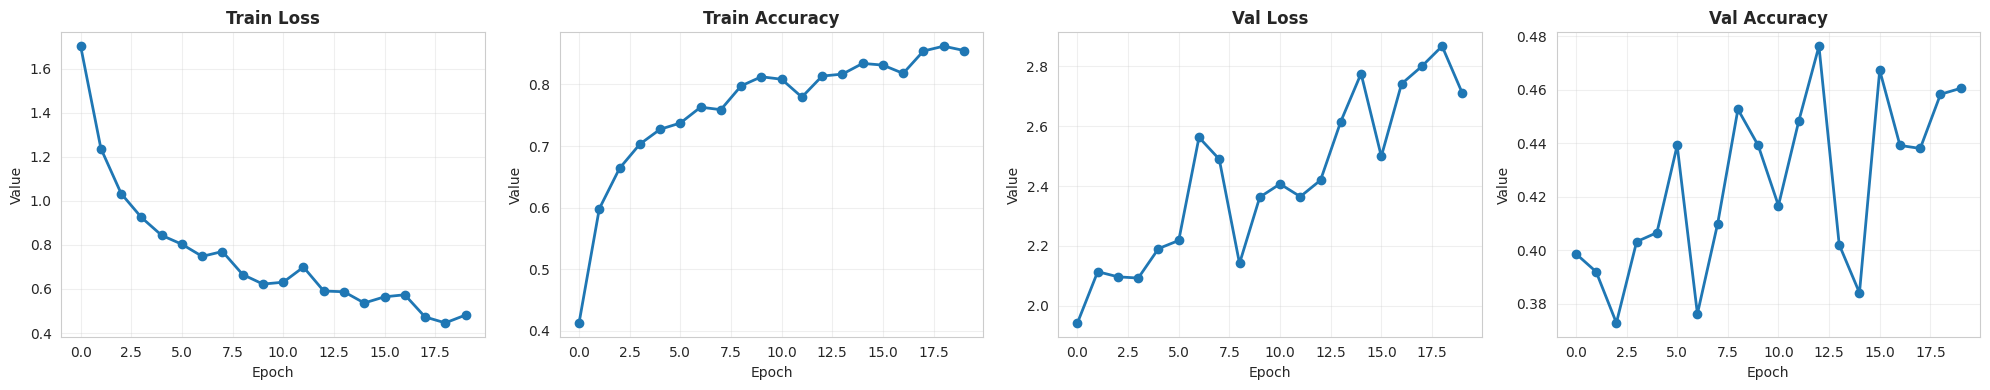

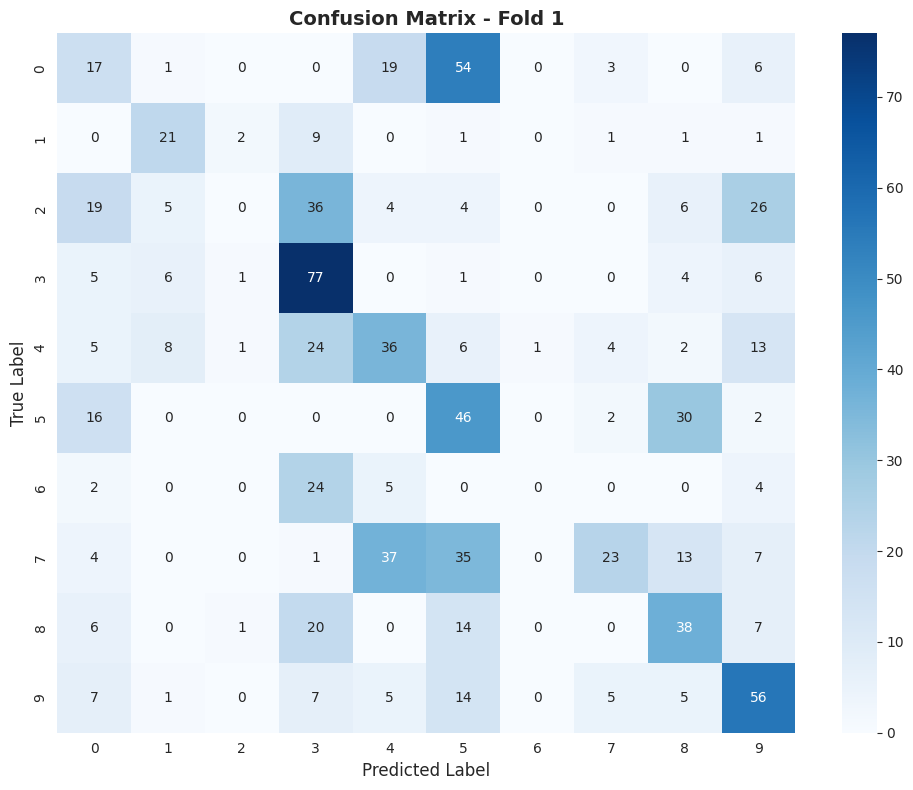


Fold 1 completed!
Results saved to: saved_cv/1125_213410/fold_1

############################################################
FOLD 2/10
############################################################
Test fold: 2
Validation fold: 3
Training folds: [1, 4, 5, 6, 7, 8, 9, 10]

STEP 1: Preparing Data
Train samples: 6919
Val samples: 925
Test samples: 888
Preprocessing training data...
Processing 6919 audio files in train mode...
Processed 100/6919 files
Processed 400/6919 files
Processed 500/6919 files
Processed 600/6919 files
Processed 700/6919 files
Processed 800/6919 files
Processed 900/6919 files
Processed 1000/6919 files
Processed 1100/6919 files
Processed 1200/6919 files
Processed 1300/6919 files
Processed 1400/6919 files
Processed 1500/6919 files
Processed 1600/6919 files
Processed 1700/6919 files
Processed 1800/6919 files
Processed 2100/6919 files
Processed 2200/6919 files
Processed 2300/6919 files
Processed 2400/6919 files
Processed 2500/6919 files
Processed 2600/6919 files
Processe

Train Loss: 1.7022, Train Acc: 0.4178
Val Loss: 2.1298, Val Acc: 0.4000

Epoch 2/20
----------------------------------------


Train Loss: 1.2023, Train Acc: 0.5994
Val Loss: 2.0920, Val Acc: 0.4205

Epoch 3/20
----------------------------------------


Train Loss: 1.0317, Train Acc: 0.6697
Val Loss: 2.1625, Val Acc: 0.4119

Epoch 4/20
----------------------------------------


Train Loss: 0.9336, Train Acc: 0.7011
Val Loss: 2.1166, Val Acc: 0.4454

Epoch 5/20
----------------------------------------


Train Loss: 0.9002, Train Acc: 0.7150
Val Loss: 2.0633, Val Acc: 0.4562

Epoch 6/20
----------------------------------------


Train Loss: 0.8146, Train Acc: 0.7427
Val Loss: 2.3327, Val Acc: 0.4476

Epoch 7/20
----------------------------------------


Train Loss: 0.7094, Train Acc: 0.7783
Val Loss: 2.5839, Val Acc: 0.4465

Epoch 8/20
----------------------------------------


Train Loss: 0.7846, Train Acc: 0.7531
Val Loss: 2.1603, Val Acc: 0.4476

Epoch 9/20
----------------------------------------


Train Loss: 0.7130, Train Acc: 0.7799
Val Loss: 2.2325, Val Acc: 0.4519

Epoch 10/20
----------------------------------------


Train Loss: 0.7029, Train Acc: 0.7851
Val Loss: 2.4877, Val Acc: 0.4411

Epoch 11/20
----------------------------------------


Train Loss: 0.6806, Train Acc: 0.7878
Val Loss: 2.3117, Val Acc: 0.4638

Epoch 12/20
----------------------------------------


Train Loss: 0.6107, Train Acc: 0.8112
Val Loss: 2.2774, Val Acc: 0.4832

Epoch 13/20
----------------------------------------


Train Loss: 0.7488, Train Acc: 0.7698
Val Loss: 2.1171, Val Acc: 0.4984

Epoch 14/20
----------------------------------------


Train Loss: 0.6959, Train Acc: 0.7784
Val Loss: 2.4359, Val Acc: 0.4973

Epoch 15/20
----------------------------------------


Train Loss: 0.6318, Train Acc: 0.8065
Val Loss: 2.2716, Val Acc: 0.5092

Epoch 16/20
----------------------------------------


Train Loss: 0.6152, Train Acc: 0.8099
Val Loss: 2.2460, Val Acc: 0.5222

Epoch 17/20
----------------------------------------


Train Loss: 0.5208, Train Acc: 0.8436
Val Loss: 2.3708, Val Acc: 0.4649

Epoch 18/20
----------------------------------------


Train Loss: 0.5234, Train Acc: 0.8422
Val Loss: 2.2632, Val Acc: 0.5200

Epoch 19/20
----------------------------------------


Train Loss: 0.5514, Train Acc: 0.8335
Val Loss: 2.0007, Val Acc: 0.5319

Epoch 20/20
----------------------------------------


Train Loss: 0.6276, Train Acc: 0.8079
Val Loss: 2.2752, Val Acc: 0.4919

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 28/28 [00:00<00:00, 103.27it/s, loss=0.6801]



Test Loss: 2.4336
Test Accuracy: 0.4493

Test Metrics:
  Accuracy:          0.4493
  Precision (macro): 0.4823
  Recall (macro):    0.4842
  F1-Score (macro):  0.4718
  Precision (wtd):   0.4362
  Recall (wtd):      0.4493
  F1-Score (wtd):    0.4314


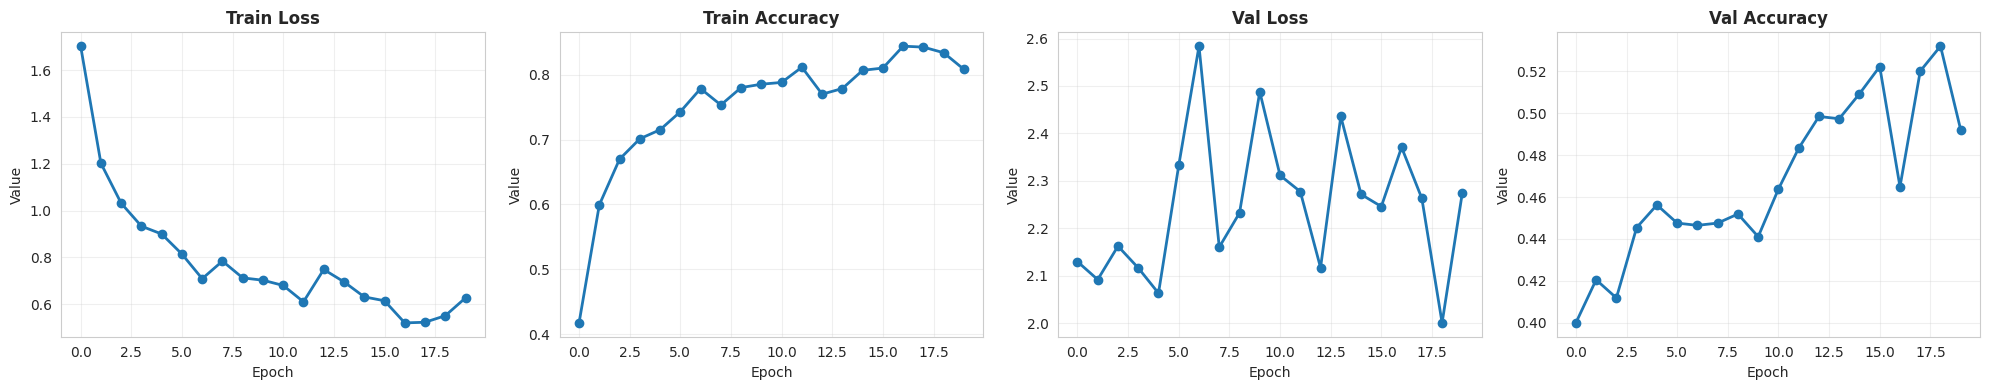

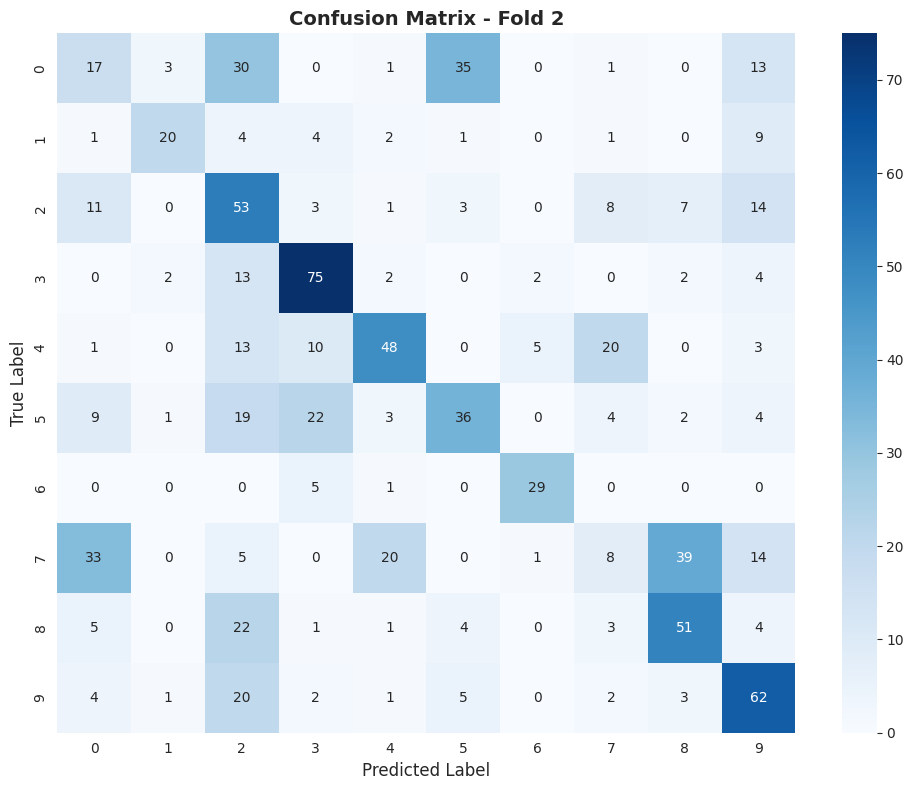


Fold 2 completed!
Results saved to: saved_cv/1125_213410/fold_2

############################################################
FOLD 3/10
############################################################
Test fold: 3
Validation fold: 4
Training folds: [1, 2, 5, 6, 7, 8, 9, 10]

STEP 1: Preparing Data
Train samples: 6817
Val samples: 990
Test samples: 925
Preprocessing training data...
Processing 6817 audio files in train mode...
Processed 100/6817 files
Processed 300/6817 files
Processed 400/6817 files
Processed 500/6817 files
Processed 700/6817 files
Processed 800/6817 files
Processed 900/6817 files
Processed 1000/6817 files
Processed 1100/6817 files
Processed 1200/6817 files
Processed 1300/6817 files
Processed 1400/6817 files
Processed 1500/6817 files
Processed 1600/6817 files
Processed 1800/6817 files
Processed 2000/6817 files
Processed 2200/6817 files
Processed 2300/6817 files
Processed 2400/6817 files
Processed 2500/6817 files
Processed 2600/6817 files
Processed 2700/6817 files
Processe

Train Loss: 1.6773, Train Acc: 0.4279
Val Loss: 1.8326, Val Acc: 0.4253

Epoch 2/20
----------------------------------------


Train Loss: 1.2149, Train Acc: 0.5960
Val Loss: 1.8510, Val Acc: 0.4495

Epoch 3/20
----------------------------------------


Train Loss: 1.0314, Train Acc: 0.6614
Val Loss: 1.8945, Val Acc: 0.4576

Epoch 4/20
----------------------------------------


Train Loss: 1.0103, Train Acc: 0.6713
Val Loss: 1.9752, Val Acc: 0.4455

Epoch 5/20
----------------------------------------


Train Loss: 0.8573, Train Acc: 0.7219
Val Loss: 1.8266, Val Acc: 0.5091

Epoch 6/20
----------------------------------------


Train Loss: 0.8036, Train Acc: 0.7446
Val Loss: 1.9076, Val Acc: 0.4960

Epoch 7/20
----------------------------------------


Train Loss: 0.7681, Train Acc: 0.7588
Val Loss: 1.9589, Val Acc: 0.4949

Epoch 8/20
----------------------------------------


Train Loss: 0.7686, Train Acc: 0.7588
Val Loss: 1.8812, Val Acc: 0.5354

Epoch 9/20
----------------------------------------


Train Loss: 0.6935, Train Acc: 0.7795
Val Loss: 2.0618, Val Acc: 0.5253

Epoch 10/20
----------------------------------------


Train Loss: 0.7416, Train Acc: 0.7632
Val Loss: 2.0438, Val Acc: 0.4848

Epoch 11/20
----------------------------------------


Train Loss: 0.7192, Train Acc: 0.7685
Val Loss: 1.9509, Val Acc: 0.5061

Epoch 12/20
----------------------------------------


Train Loss: 0.6524, Train Acc: 0.7907
Val Loss: 2.1318, Val Acc: 0.4929

Epoch 13/20
----------------------------------------


Train Loss: 0.7057, Train Acc: 0.7753
Val Loss: 2.0001, Val Acc: 0.5414

Epoch 14/20
----------------------------------------


Train Loss: 0.6706, Train Acc: 0.7867
Val Loss: 2.0703, Val Acc: 0.5242

Epoch 15/20
----------------------------------------


Train Loss: 0.5865, Train Acc: 0.8174
Val Loss: 1.9719, Val Acc: 0.5101

Epoch 16/20
----------------------------------------


Train Loss: 0.5681, Train Acc: 0.8246
Val Loss: 1.9922, Val Acc: 0.5414

Epoch 17/20
----------------------------------------


Train Loss: 0.5729, Train Acc: 0.8177
Val Loss: 2.0585, Val Acc: 0.5333

Epoch 18/20
----------------------------------------


Train Loss: 0.4711, Train Acc: 0.8529
Val Loss: 2.3369, Val Acc: 0.5081

Epoch 19/20
----------------------------------------


Train Loss: 0.5237, Train Acc: 0.8379
Val Loss: 2.2117, Val Acc: 0.4505

Epoch 20/20
----------------------------------------


Train Loss: 0.5738, Train Acc: 0.8160
Val Loss: 2.0759, Val Acc: 0.5455

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 29/29 [00:00<00:00, 99.32it/s, loss=2.0089]



Test Loss: 2.2400
Test Accuracy: 0.4465

Test Metrics:
  Accuracy:          0.4465
  Precision (macro): 0.4679
  Recall (macro):    0.4911
  F1-Score (macro):  0.4698
  Precision (wtd):   0.4456
  Recall (wtd):      0.4465
  F1-Score (wtd):    0.4387


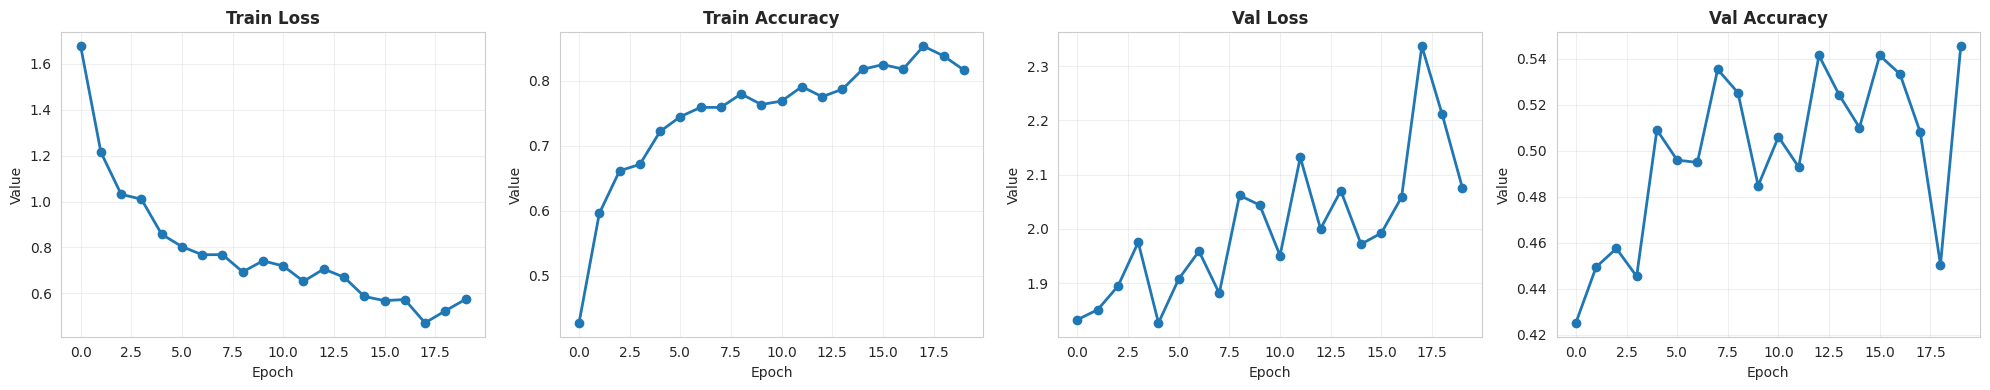

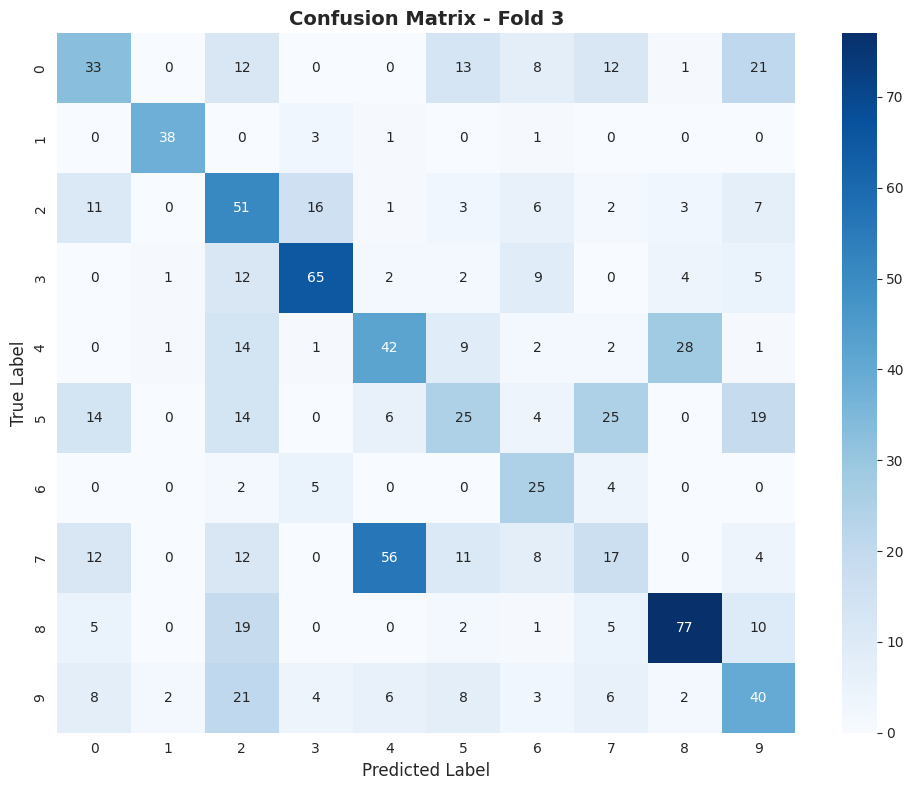


Fold 3 completed!
Results saved to: saved_cv/1125_213410/fold_3

############################################################
FOLD 4/10
############################################################
Test fold: 4
Validation fold: 5
Training folds: [1, 2, 3, 6, 7, 8, 9, 10]

STEP 1: Preparing Data
Train samples: 6806
Val samples: 936
Test samples: 990
Preprocessing training data...
Processing 6806 audio files in train mode...
Processed 100/6806 files
Processed 200/6806 files
Processed 300/6806 files
Processed 400/6806 files
Processed 500/6806 files
Processed 700/6806 files
Processed 800/6806 files
Processed 900/6806 files
Processed 1000/6806 files
Processed 1100/6806 files
Processed 1200/6806 files
Processed 1300/6806 files
Processed 1400/6806 files
Processed 1500/6806 files
Processed 1800/6806 files
Processed 1900/6806 files
Processed 2000/6806 files
Processed 2200/6806 files
Processed 2300/6806 files
Processed 2500/6806 files
Processed 2600/6806 files
Processed 2700/6806 files
Processed

Train Loss: 1.7327, Train Acc: 0.4001
Val Loss: 1.5886, Val Acc: 0.4733

Epoch 2/20
----------------------------------------


Train Loss: 1.2617, Train Acc: 0.5840
Val Loss: 1.6645, Val Acc: 0.4829

Epoch 3/20
----------------------------------------


Train Loss: 1.0616, Train Acc: 0.6528
Val Loss: 1.5757, Val Acc: 0.5299

Epoch 4/20
----------------------------------------


Train Loss: 0.9506, Train Acc: 0.6900
Val Loss: 1.7731, Val Acc: 0.5064

Epoch 5/20
----------------------------------------


Train Loss: 0.8501, Train Acc: 0.7282
Val Loss: 1.7039, Val Acc: 0.5748

Epoch 6/20
----------------------------------------


Train Loss: 0.8496, Train Acc: 0.7327
Val Loss: 1.6603, Val Acc: 0.5406

Epoch 7/20
----------------------------------------


Train Loss: 0.7248, Train Acc: 0.7756
Val Loss: 1.8541, Val Acc: 0.5598

Epoch 8/20
----------------------------------------


Train Loss: 0.7469, Train Acc: 0.7714
Val Loss: 1.4808, Val Acc: 0.6207

Epoch 9/20
----------------------------------------


Train Loss: 0.7206, Train Acc: 0.7758
Val Loss: 1.6524, Val Acc: 0.5994

Epoch 10/20
----------------------------------------


Train Loss: 0.6556, Train Acc: 0.7925
Val Loss: 1.5766, Val Acc: 0.6111

Epoch 11/20
----------------------------------------


Train Loss: 0.6809, Train Acc: 0.7922
Val Loss: 1.6048, Val Acc: 0.6100

Epoch 12/20
----------------------------------------


Train Loss: 0.7909, Train Acc: 0.7535
Val Loss: 1.6530, Val Acc: 0.6004

Epoch 13/20
----------------------------------------


Train Loss: 0.7198, Train Acc: 0.7742
Val Loss: 1.5677, Val Acc: 0.6079

Epoch 14/20
----------------------------------------


Train Loss: 0.6227, Train Acc: 0.8031
Val Loss: 1.7249, Val Acc: 0.5962

Epoch 15/20
----------------------------------------


Train Loss: 0.5218, Train Acc: 0.8388
Val Loss: 1.6035, Val Acc: 0.6229

Epoch 16/20
----------------------------------------


Train Loss: 0.6500, Train Acc: 0.8005
Val Loss: 1.8840, Val Acc: 0.5353

Epoch 17/20
----------------------------------------


Train Loss: 0.6428, Train Acc: 0.7903
Val Loss: 2.2965, Val Acc: 0.5085

Epoch 18/20
----------------------------------------


Train Loss: 0.7127, Train Acc: 0.7777
Val Loss: 1.9105, Val Acc: 0.5203

Epoch 19/20
----------------------------------------


Train Loss: 0.6436, Train Acc: 0.8043
Val Loss: 1.6819, Val Acc: 0.6111

Epoch 20/20
----------------------------------------


Train Loss: 0.5043, Train Acc: 0.8416
Val Loss: 1.8446, Val Acc: 0.5951

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 31/31 [00:00<00:00, 99.45it/s, loss=1.1751]



Test Loss: 1.7184
Test Accuracy: 0.5121

Test Metrics:
  Accuracy:          0.5121
  Precision (macro): 0.5279
  Recall (macro):    0.5105
  F1-Score (macro):  0.5091
  Precision (wtd):   0.5418
  Recall (wtd):      0.5121
  F1-Score (wtd):    0.5159


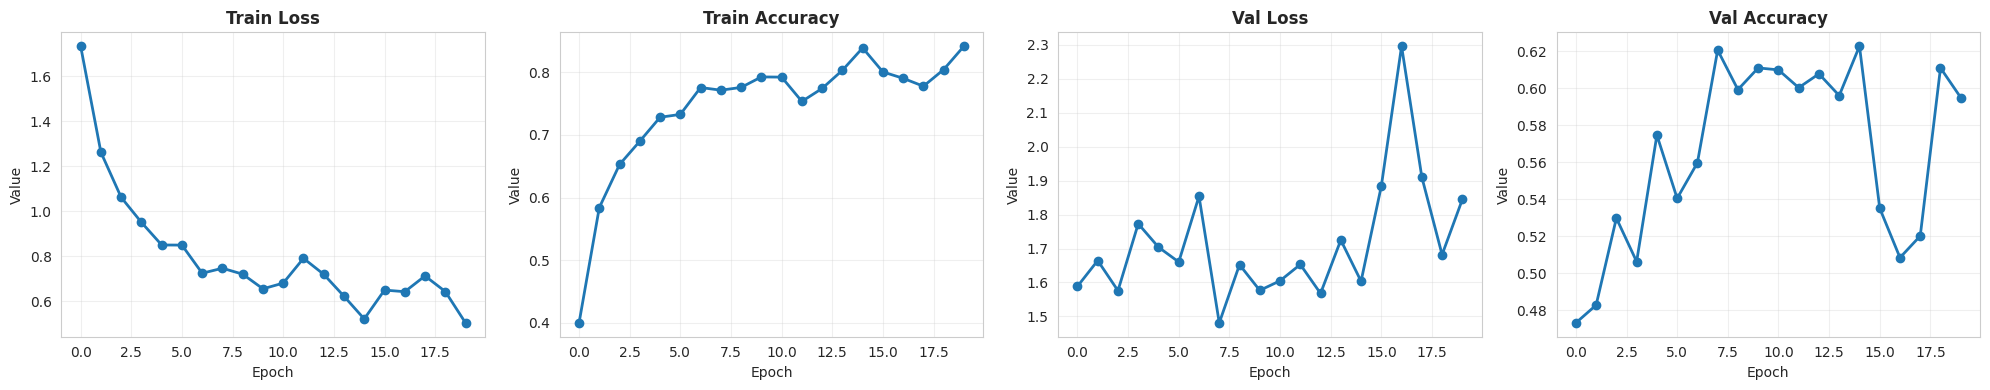

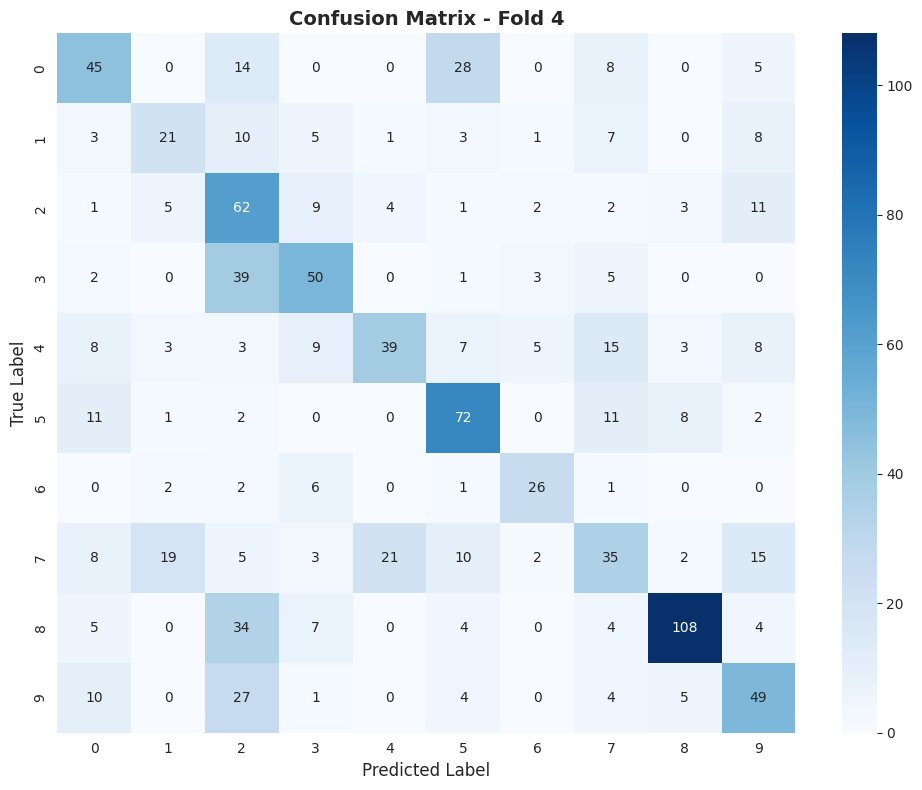


Fold 4 completed!
Results saved to: saved_cv/1125_213410/fold_4

############################################################
FOLD 5/10
############################################################
Test fold: 5
Validation fold: 6
Training folds: [1, 2, 3, 4, 7, 8, 9, 10]

STEP 1: Preparing Data
Train samples: 6973
Val samples: 823
Test samples: 936
Preprocessing training data...
Processing 6973 audio files in train mode...
Processed 100/6973 files
Processed 200/6973 files
Processed 300/6973 files
Processed 400/6973 files
Processed 500/6973 files
Processed 600/6973 files
Processed 700/6973 files
Processed 800/6973 files
Processed 900/6973 files
Processed 1000/6973 files
Processed 1100/6973 files
Processed 1200/6973 files
Processed 1400/6973 files
Processed 1500/6973 files
Processed 1700/6973 files
Processed 1800/6973 files
Processed 1900/6973 files
Processed 2000/6973 files
Processed 2100/6973 files
Processed 2200/6973 files
Processed 2300/6973 files
Processed 2500/6973 files
Processed 

Train Loss: 1.7151, Train Acc: 0.4074
Val Loss: 2.0534, Val Acc: 0.3572

Epoch 2/20
----------------------------------------


Train Loss: 1.2379, Train Acc: 0.5974
Val Loss: 2.3567, Val Acc: 0.3803

Epoch 3/20
----------------------------------------


Train Loss: 1.0770, Train Acc: 0.6537
Val Loss: 2.0999, Val Acc: 0.4204

Epoch 4/20
----------------------------------------


Train Loss: 0.9314, Train Acc: 0.7043
Val Loss: 2.3676, Val Acc: 0.3791

Epoch 5/20
----------------------------------------


Train Loss: 0.9427, Train Acc: 0.6950
Val Loss: 2.1365, Val Acc: 0.4423

Epoch 6/20
----------------------------------------


Train Loss: 0.9975, Train Acc: 0.6811
Val Loss: 2.1740, Val Acc: 0.4168

Epoch 7/20
----------------------------------------


Train Loss: 0.8296, Train Acc: 0.7366
Val Loss: 2.0906, Val Acc: 0.4228

Epoch 8/20
----------------------------------------


Train Loss: 0.9176, Train Acc: 0.7130
Val Loss: 2.4274, Val Acc: 0.3670

Epoch 9/20
----------------------------------------


Train Loss: 0.8889, Train Acc: 0.7203
Val Loss: 2.4451, Val Acc: 0.3864

Epoch 10/20
----------------------------------------


Train Loss: 0.9543, Train Acc: 0.7001
Val Loss: 2.1915, Val Acc: 0.4338

Epoch 11/20
----------------------------------------


Train Loss: 0.8072, Train Acc: 0.7434
Val Loss: 2.0870, Val Acc: 0.4520

Epoch 12/20
----------------------------------------


Train Loss: 0.7190, Train Acc: 0.7690
Val Loss: 2.2832, Val Acc: 0.4654

Epoch 13/20
----------------------------------------


Train Loss: 0.8506, Train Acc: 0.7247
Val Loss: 2.0899, Val Acc: 0.4508

Epoch 14/20
----------------------------------------


Train Loss: 0.7100, Train Acc: 0.7713
Val Loss: 2.1071, Val Acc: 0.4775

Epoch 15/20
----------------------------------------


Train Loss: 0.6697, Train Acc: 0.7869
Val Loss: 2.2562, Val Acc: 0.4775

Epoch 16/20
----------------------------------------


Train Loss: 0.6785, Train Acc: 0.7843
Val Loss: 2.3473, Val Acc: 0.4654

Epoch 17/20
----------------------------------------


Train Loss: 0.6246, Train Acc: 0.8012
Val Loss: 2.2199, Val Acc: 0.4812

Epoch 18/20
----------------------------------------


Train Loss: 0.6037, Train Acc: 0.8143
Val Loss: 2.2524, Val Acc: 0.4557

Epoch 19/20
----------------------------------------


Train Loss: 0.6001, Train Acc: 0.8113
Val Loss: 2.4296, Val Acc: 0.4593

Epoch 20/20
----------------------------------------


Train Loss: 0.5590, Train Acc: 0.8225
Val Loss: 2.4225, Val Acc: 0.4471

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 30/30 [00:00<00:00, 100.19it/s, loss=1.4331]



Test Loss: 1.6399
Test Accuracy: 0.4209

Test Metrics:
  Accuracy:          0.4209
  Precision (macro): 0.4526
  Recall (macro):    0.4101
  F1-Score (macro):  0.4014
  Precision (wtd):   0.4366
  Recall (wtd):      0.4209
  F1-Score (wtd):    0.4076


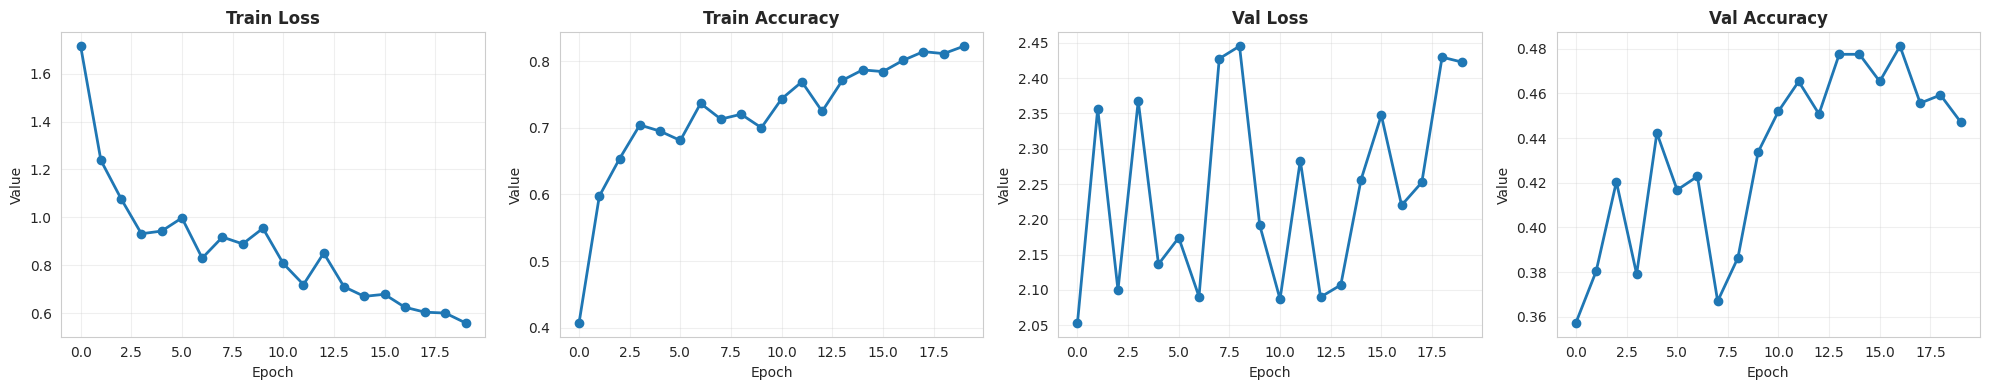

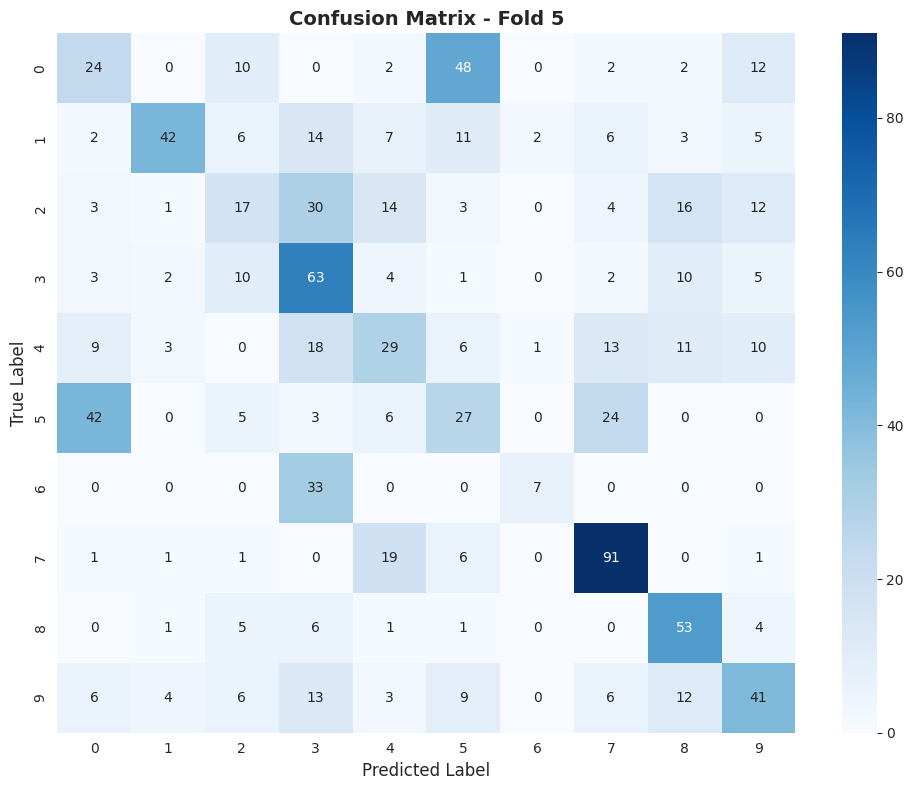


Fold 5 completed!
Results saved to: saved_cv/1125_213410/fold_5

############################################################
FOLD 6/10
############################################################
Test fold: 6
Validation fold: 7
Training folds: [1, 2, 3, 4, 5, 8, 9, 10]

STEP 1: Preparing Data
Train samples: 7071
Val samples: 838
Test samples: 823
Preprocessing training data...
Processing 7071 audio files in train mode...
Processed 200/7071 files
Processed 300/7071 files
Processed 400/7071 files
Processed 500/7071 files
Processed 600/7071 files
Processed 700/7071 files
Processed 900/7071 files
Processed 1000/7071 files
Processed 1100/7071 files
Processed 1200/7071 files
Processed 1400/7071 files
Processed 1500/7071 files
Processed 1600/7071 files
Processed 1700/7071 files
Processed 1800/7071 files
Processed 1900/7071 files
Processed 2000/7071 files
Processed 2100/7071 files
Processed 2200/7071 files
Processed 2400/7071 files
Processed 2500/7071 files
Processed 2700/7071 files
Processe

Train Loss: 1.7157, Train Acc: 0.4159
Val Loss: 1.8587, Val Acc: 0.3974

Epoch 2/20
----------------------------------------


Train Loss: 1.2431, Train Acc: 0.5947
Val Loss: 1.7701, Val Acc: 0.4749

Epoch 3/20
----------------------------------------


Train Loss: 1.0656, Train Acc: 0.6510
Val Loss: 1.8653, Val Acc: 0.4475

Epoch 4/20
----------------------------------------


Train Loss: 1.0433, Train Acc: 0.6566
Val Loss: 1.8481, Val Acc: 0.4642

Epoch 5/20
----------------------------------------


Train Loss: 0.9625, Train Acc: 0.6947
Val Loss: 1.8808, Val Acc: 0.4654

Epoch 6/20
----------------------------------------


Train Loss: 0.8696, Train Acc: 0.7213
Val Loss: 1.7735, Val Acc: 0.5167

Epoch 7/20
----------------------------------------


Train Loss: 0.7823, Train Acc: 0.7562
Val Loss: 1.7949, Val Acc: 0.4833

Epoch 8/20
----------------------------------------


Train Loss: 0.7537, Train Acc: 0.7676
Val Loss: 1.9476, Val Acc: 0.4988

Epoch 9/20
----------------------------------------


Train Loss: 0.6850, Train Acc: 0.7924
Val Loss: 1.9496, Val Acc: 0.5095

Epoch 10/20
----------------------------------------


Train Loss: 0.7212, Train Acc: 0.7763
Val Loss: 1.8458, Val Acc: 0.5167

Epoch 11/20
----------------------------------------


Train Loss: 0.6367, Train Acc: 0.8020
Val Loss: 1.8981, Val Acc: 0.5239

Epoch 12/20
----------------------------------------


Train Loss: 0.6054, Train Acc: 0.8116
Val Loss: 1.8414, Val Acc: 0.5465

Epoch 13/20
----------------------------------------


Train Loss: 0.6388, Train Acc: 0.7978
Val Loss: 1.8796, Val Acc: 0.5084

Epoch 14/20
----------------------------------------


Train Loss: 0.6458, Train Acc: 0.7948
Val Loss: 2.1547, Val Acc: 0.4403

Epoch 15/20
----------------------------------------


Train Loss: 0.6300, Train Acc: 0.8092
Val Loss: 2.1349, Val Acc: 0.4594

Epoch 16/20
----------------------------------------


Train Loss: 0.5989, Train Acc: 0.8143
Val Loss: 1.9684, Val Acc: 0.5072

Epoch 17/20
----------------------------------------


Train Loss: 0.6409, Train Acc: 0.8009
Val Loss: 1.8896, Val Acc: 0.4964

Epoch 18/20
----------------------------------------


Train Loss: 0.6361, Train Acc: 0.8017
Val Loss: 1.8743, Val Acc: 0.4940

Epoch 19/20
----------------------------------------


Train Loss: 0.5786, Train Acc: 0.8262
Val Loss: 2.0876, Val Acc: 0.4893

Epoch 20/20
----------------------------------------


Train Loss: 0.5464, Train Acc: 0.8364
Val Loss: 1.8460, Val Acc: 0.5119

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 26/26 [00:00<00:00, 98.27it/s, loss=2.4689]



Test Loss: 1.9385
Test Accuracy: 0.4192

Test Metrics:
  Accuracy:          0.4192
  Precision (macro): 0.4185
  Recall (macro):    0.4156
  F1-Score (macro):  0.4079
  Precision (wtd):   0.4080
  Recall (wtd):      0.4192
  F1-Score (wtd):    0.4057


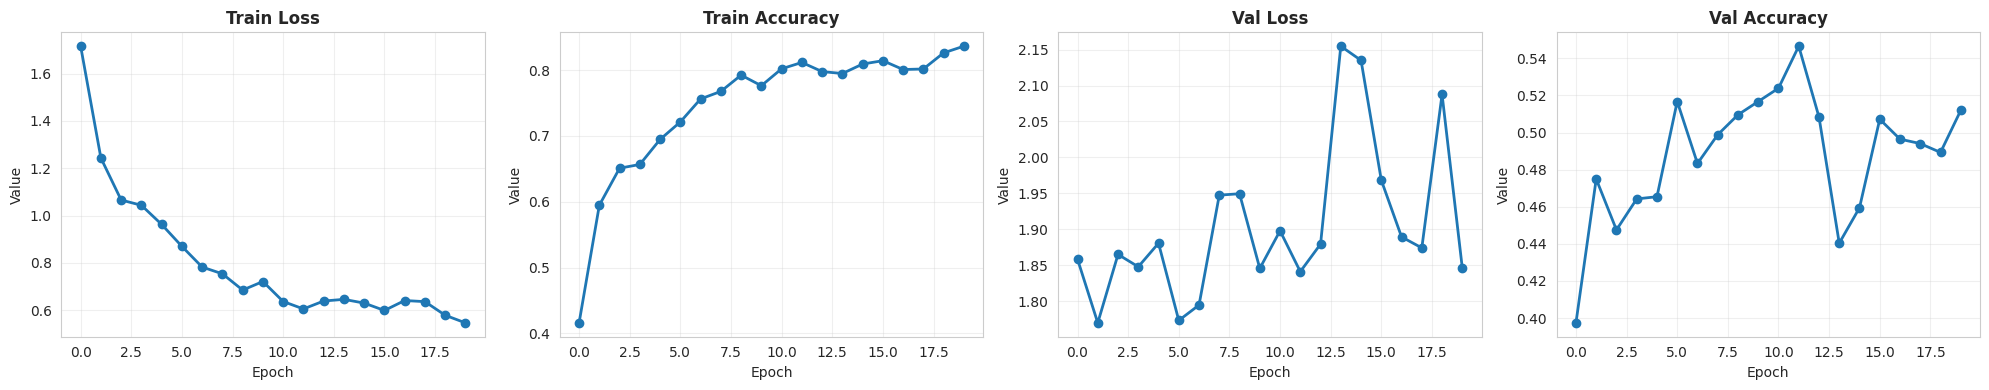

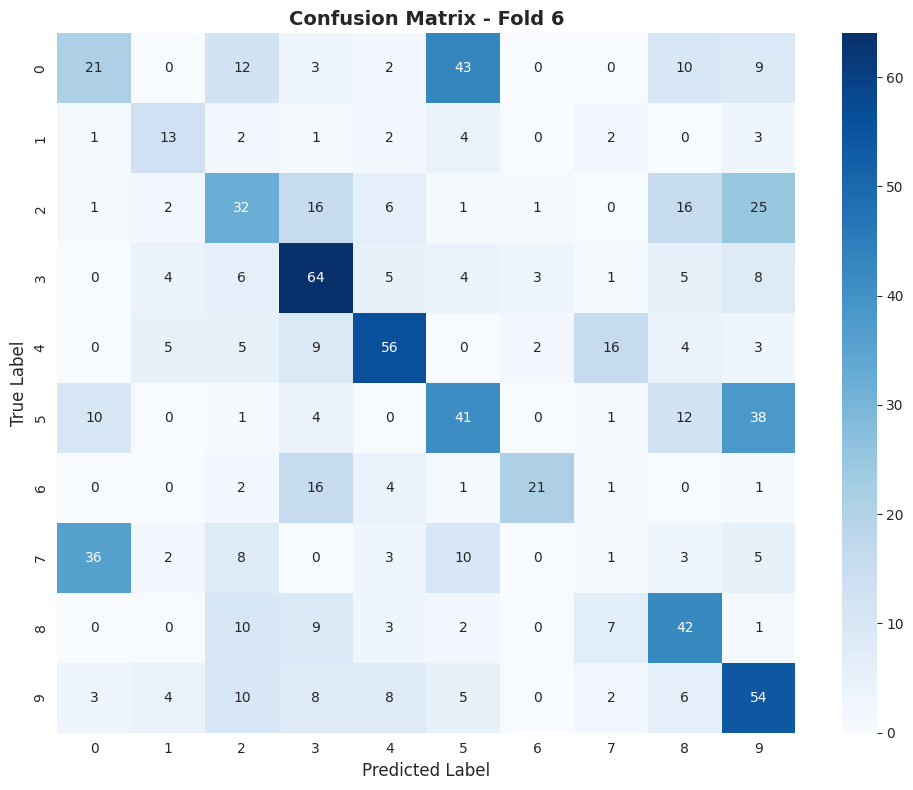


Fold 6 completed!
Results saved to: saved_cv/1125_213410/fold_6

############################################################
FOLD 7/10
############################################################
Test fold: 7
Validation fold: 8
Training folds: [1, 2, 3, 4, 5, 6, 9, 10]

STEP 1: Preparing Data
Train samples: 7088
Val samples: 806
Test samples: 838
Preprocessing training data...
Processing 7088 audio files in train mode...
Processed 200/7088 files
Processed 300/7088 files
Processed 400/7088 files
Processed 600/7088 files
Processed 900/7088 files
Processed 1200/7088 files
Processed 1300/7088 files
Processed 1400/7088 files
Processed 1500/7088 files
Processed 1600/7088 files
Processed 1700/7088 files
Processed 1800/7088 files
Processed 1900/7088 files
Processed 2000/7088 files
Processed 2100/7088 files
Processed 2200/7088 files
Processed 2400/7088 files
Processed 2500/7088 files
Processed 2700/7088 files
Processed 2800/7088 files
Processed 3000/7088 files
Processed 3100/7088 files
Proces

Train Loss: 1.7233, Train Acc: 0.4093
Val Loss: 1.6397, Val Acc: 0.4119

Epoch 2/20
----------------------------------------


Train Loss: 1.2172, Train Acc: 0.6017
Val Loss: 1.6812, Val Acc: 0.5050

Epoch 3/20
----------------------------------------


Train Loss: 1.0244, Train Acc: 0.6727
Val Loss: 1.7717, Val Acc: 0.5099

Epoch 4/20
----------------------------------------


Train Loss: 0.9020, Train Acc: 0.7129
Val Loss: 1.8018, Val Acc: 0.5223

Epoch 5/20
----------------------------------------


Train Loss: 0.8503, Train Acc: 0.7255
Val Loss: 2.1062, Val Acc: 0.4330

Epoch 6/20
----------------------------------------


Train Loss: 0.7801, Train Acc: 0.7532
Val Loss: 1.9671, Val Acc: 0.5025

Epoch 7/20
----------------------------------------


Train Loss: 0.8005, Train Acc: 0.7520
Val Loss: 1.8958, Val Acc: 0.4839

Epoch 8/20
----------------------------------------


Train Loss: 0.9819, Train Acc: 0.6891
Val Loss: 1.8686, Val Acc: 0.5372

Epoch 9/20
----------------------------------------


Train Loss: 0.7847, Train Acc: 0.7552
Val Loss: 1.9612, Val Acc: 0.5273

Epoch 10/20
----------------------------------------


Train Loss: 0.7202, Train Acc: 0.7839
Val Loss: 1.8969, Val Acc: 0.5409

Epoch 11/20
----------------------------------------


Train Loss: 0.6770, Train Acc: 0.7925
Val Loss: 1.9102, Val Acc: 0.5471

Epoch 12/20
----------------------------------------


Train Loss: 0.6907, Train Acc: 0.7791
Val Loss: 1.9650, Val Acc: 0.5434

Epoch 13/20
----------------------------------------


Train Loss: 0.5915, Train Acc: 0.8138
Val Loss: 2.1180, Val Acc: 0.5025

Epoch 14/20
----------------------------------------


Train Loss: 0.5549, Train Acc: 0.8313
Val Loss: 1.8688, Val Acc: 0.5124

Epoch 15/20
----------------------------------------


Train Loss: 0.5928, Train Acc: 0.8184
Val Loss: 1.8549, Val Acc: 0.5509

Epoch 16/20
----------------------------------------


Train Loss: 0.6739, Train Acc: 0.7949
Val Loss: 1.9097, Val Acc: 0.5819

Epoch 17/20
----------------------------------------


Train Loss: 0.5232, Train Acc: 0.8393
Val Loss: 2.0765, Val Acc: 0.5533

Epoch 18/20
----------------------------------------


Train Loss: 0.5273, Train Acc: 0.8426
Val Loss: 1.9552, Val Acc: 0.5509

Epoch 19/20
----------------------------------------


Train Loss: 0.4728, Train Acc: 0.8545
Val Loss: 1.9635, Val Acc: 0.5509

Epoch 20/20
----------------------------------------


Train Loss: 0.4542, Train Acc: 0.8658
Val Loss: 2.0008, Val Acc: 0.5782

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 27/27 [00:00<00:00, 109.70it/s, loss=3.3358]



Test Loss: 1.8708
Test Accuracy: 0.4487

Test Metrics:
  Accuracy:          0.4487
  Precision (macro): 0.4507
  Recall (macro):    0.4114
  F1-Score (macro):  0.3894
  Precision (wtd):   0.4506
  Recall (wtd):      0.4487
  F1-Score (wtd):    0.4128


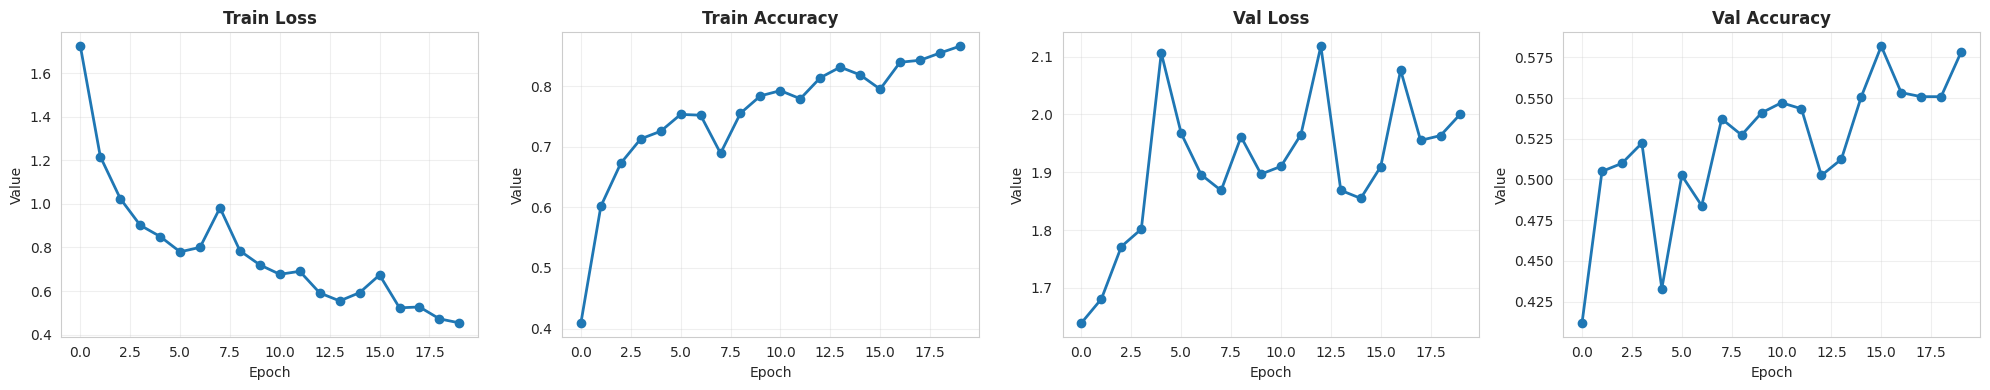

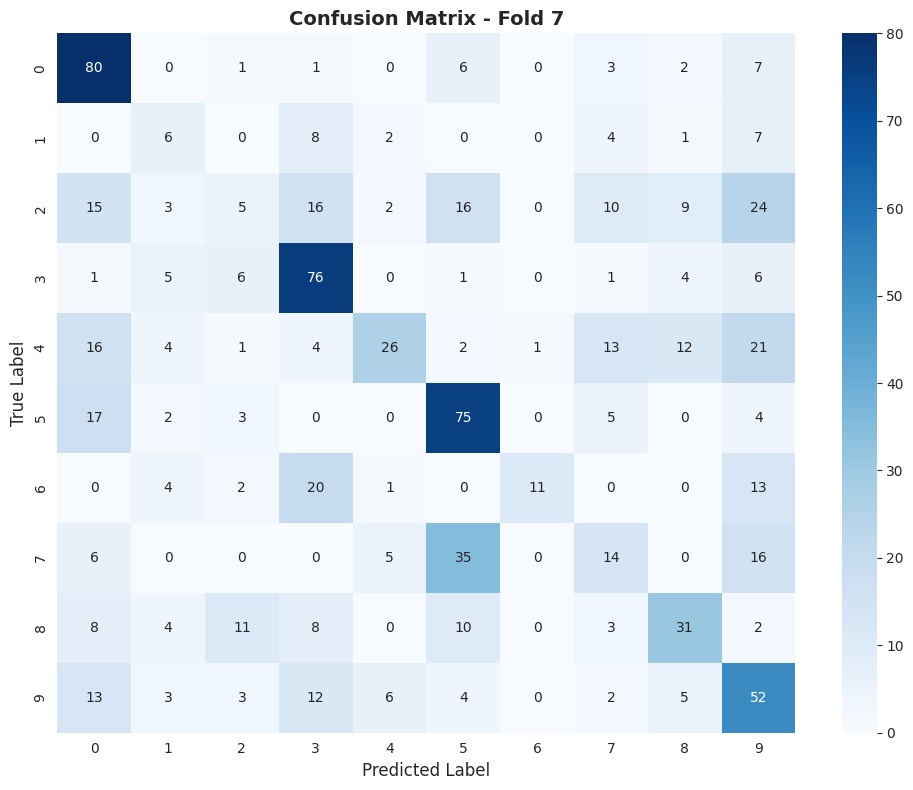


Fold 7 completed!
Results saved to: saved_cv/1125_213410/fold_7

############################################################
FOLD 8/10
############################################################
Test fold: 8
Validation fold: 9
Training folds: [1, 2, 3, 4, 5, 6, 7, 10]

STEP 1: Preparing Data
Train samples: 7110
Val samples: 816
Test samples: 806
Preprocessing training data...
Processing 7110 audio files in train mode...
Processed 100/7110 files
Processed 200/7110 files
Processed 300/7110 files
Processed 600/7110 files
Processed 800/7110 files
Processed 900/7110 files
Processed 1200/7110 files
Processed 1300/7110 files
Processed 1400/7110 files
Processed 1500/7110 files
Processed 1600/7110 files
Processed 1700/7110 files
Processed 1900/7110 files
Processed 2000/7110 files
Processed 2100/7110 files
Processed 2300/7110 files
Processed 2400/7110 files
Processed 2500/7110 files
Processed 2600/7110 files
Processed 2700/7110 files
Processed 2800/7110 files
Processed 3000/7110 files
Process

Train Loss: 1.6915, Train Acc: 0.4224
Val Loss: 1.6733, Val Acc: 0.4816

Epoch 2/20
----------------------------------------


Train Loss: 1.2210, Train Acc: 0.6021
Val Loss: 1.6368, Val Acc: 0.5539

Epoch 3/20
----------------------------------------


Train Loss: 1.1362, Train Acc: 0.6336
Val Loss: 1.7907, Val Acc: 0.5123

Epoch 4/20
----------------------------------------


Train Loss: 1.0286, Train Acc: 0.6653
Val Loss: 1.8116, Val Acc: 0.5306

Epoch 5/20
----------------------------------------


Train Loss: 0.9725, Train Acc: 0.6837
Val Loss: 1.6950, Val Acc: 0.5392

Epoch 6/20
----------------------------------------


Train Loss: 0.8847, Train Acc: 0.7117
Val Loss: 1.6965, Val Acc: 0.5662

Epoch 7/20
----------------------------------------


Train Loss: 0.7818, Train Acc: 0.7505
Val Loss: 1.6777, Val Acc: 0.5711

Epoch 8/20
----------------------------------------


Train Loss: 0.7482, Train Acc: 0.7682
Val Loss: 1.5728, Val Acc: 0.5833

Epoch 9/20
----------------------------------------


Train Loss: 0.8915, Train Acc: 0.7135
Val Loss: 1.7044, Val Acc: 0.5331

Epoch 10/20
----------------------------------------


Train Loss: 0.8475, Train Acc: 0.7322
Val Loss: 1.4471, Val Acc: 0.6140

Epoch 11/20
----------------------------------------


Train Loss: 0.7838, Train Acc: 0.7513
Val Loss: 1.5770, Val Acc: 0.6017

Epoch 12/20
----------------------------------------


Train Loss: 0.7085, Train Acc: 0.7707
Val Loss: 1.8116, Val Acc: 0.5772

Epoch 13/20
----------------------------------------


Train Loss: 0.6850, Train Acc: 0.7831
Val Loss: 1.6149, Val Acc: 0.5980

Epoch 14/20
----------------------------------------


Train Loss: 0.7013, Train Acc: 0.7750
Val Loss: 1.8564, Val Acc: 0.5600

Epoch 15/20
----------------------------------------


Train Loss: 0.6308, Train Acc: 0.7955
Val Loss: 1.8831, Val Acc: 0.5551

Epoch 16/20
----------------------------------------


Train Loss: 0.5762, Train Acc: 0.8153
Val Loss: 1.6461, Val Acc: 0.5527

Epoch 17/20
----------------------------------------


Train Loss: 0.5697, Train Acc: 0.8186
Val Loss: 1.7533, Val Acc: 0.5907

Epoch 18/20
----------------------------------------


Train Loss: 0.5983, Train Acc: 0.8124
Val Loss: 1.6406, Val Acc: 0.6409

Epoch 19/20
----------------------------------------


Train Loss: 0.5217, Train Acc: 0.8385
Val Loss: 2.0357, Val Acc: 0.5993

Epoch 20/20
----------------------------------------


Train Loss: 0.5400, Train Acc: 0.8339
Val Loss: 1.8641, Val Acc: 0.6213

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 26/26 [00:00<00:00, 103.21it/s, loss=1.1724]



Test Loss: 1.9644
Test Accuracy: 0.4901

Test Metrics:
  Accuracy:          0.4901
  Precision (macro): 0.5084
  Recall (macro):    0.5359
  F1-Score (macro):  0.5129
  Precision (wtd):   0.4744
  Recall (wtd):      0.4901
  F1-Score (wtd):    0.4736


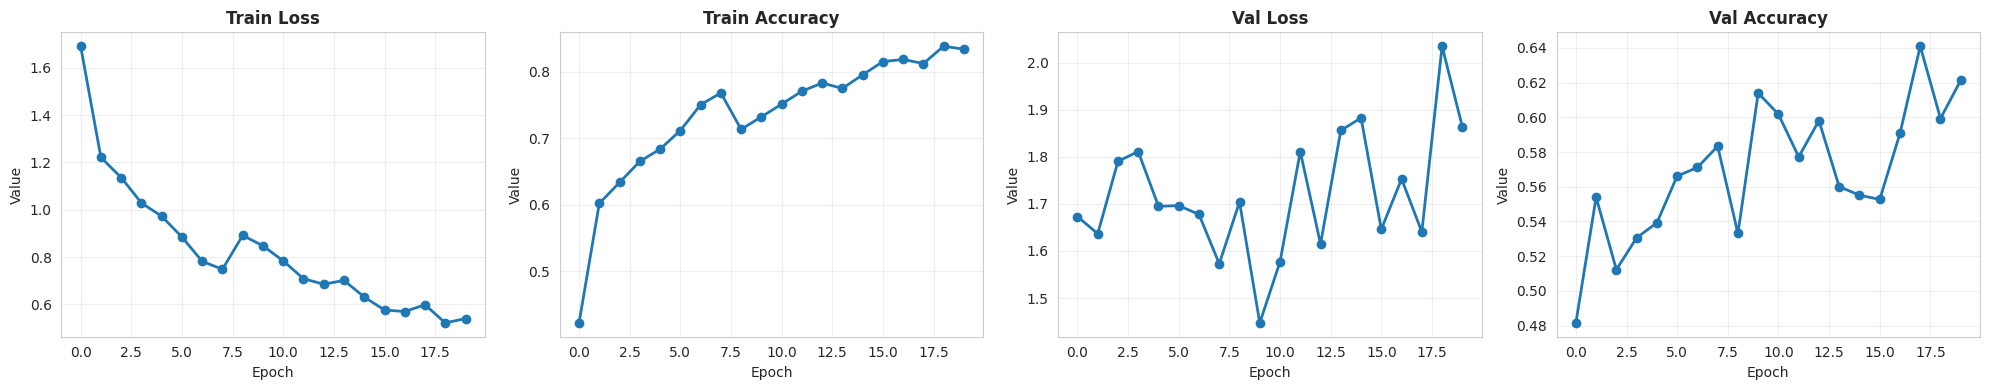

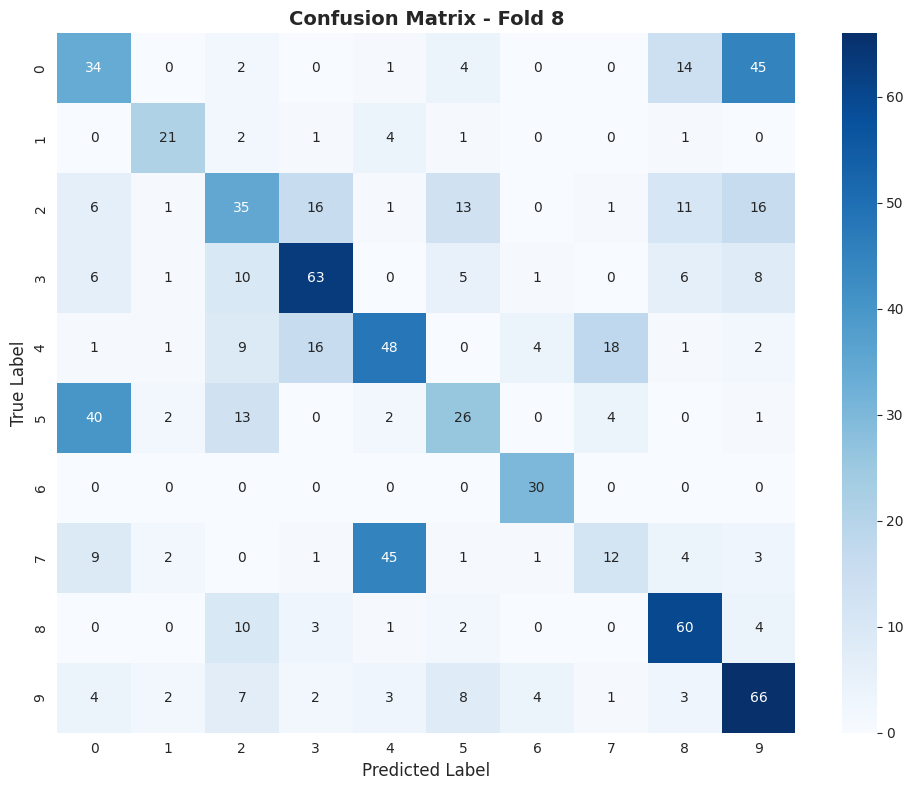


Fold 8 completed!
Results saved to: saved_cv/1125_213410/fold_8

############################################################
FOLD 9/10
############################################################
Test fold: 9
Validation fold: 10
Training folds: [1, 2, 3, 4, 5, 6, 7, 8]

STEP 1: Preparing Data
Train samples: 7079
Val samples: 837
Test samples: 816
Preprocessing training data...
Processing 7079 audio files in train mode...
Processed 100/7079 files
Processed 200/7079 files
Processed 300/7079 files
Processed 500/7079 files
Processed 600/7079 files
Processed 700/7079 files
Processed 800/7079 files
Processed 900/7079 files
Processed 1000/7079 files
Processed 1100/7079 files
Processed 1300/7079 files
Processed 1400/7079 files
Processed 1500/7079 files
Processed 1600/7079 files
Processed 1700/7079 files
Processed 1900/7079 files
Processed 2000/7079 files
Processed 2100/7079 files
Processed 2300/7079 files
Processed 2400/7079 files
Processed 2500/7079 files
Processed 2600/7079 files
Processed

Train Loss: 1.7284, Train Acc: 0.4068
Val Loss: 1.7409, Val Acc: 0.4146

Epoch 2/20
----------------------------------------


Train Loss: 1.2622, Train Acc: 0.5857
Val Loss: 1.8781, Val Acc: 0.3728

Epoch 3/20
----------------------------------------


Train Loss: 1.0856, Train Acc: 0.6485
Val Loss: 1.8633, Val Acc: 0.4253

Epoch 4/20
----------------------------------------


Train Loss: 0.9770, Train Acc: 0.6892
Val Loss: 1.8635, Val Acc: 0.4839

Epoch 5/20
----------------------------------------


Train Loss: 0.9362, Train Acc: 0.7134
Val Loss: 1.9323, Val Acc: 0.4839

Epoch 6/20
----------------------------------------


Train Loss: 0.8488, Train Acc: 0.7292
Val Loss: 1.8184, Val Acc: 0.5006

Epoch 7/20
----------------------------------------


Train Loss: 0.7777, Train Acc: 0.7517
Val Loss: 1.9558, Val Acc: 0.4803

Epoch 8/20
----------------------------------------


Train Loss: 0.7102, Train Acc: 0.7813
Val Loss: 1.8804, Val Acc: 0.5269

Epoch 9/20
----------------------------------------


Train Loss: 0.6576, Train Acc: 0.7966
Val Loss: 1.9537, Val Acc: 0.5376

Epoch 10/20
----------------------------------------


Train Loss: 0.7165, Train Acc: 0.7709
Val Loss: 2.0422, Val Acc: 0.4898

Epoch 11/20
----------------------------------------


Train Loss: 0.7305, Train Acc: 0.7779
Val Loss: 2.0183, Val Acc: 0.4994

Epoch 12/20
----------------------------------------


Train Loss: 0.5946, Train Acc: 0.8193
Val Loss: 2.0738, Val Acc: 0.5137

Epoch 13/20
----------------------------------------


Train Loss: 0.5571, Train Acc: 0.8274
Val Loss: 2.0000, Val Acc: 0.4839

Epoch 14/20
----------------------------------------


Train Loss: 0.6050, Train Acc: 0.8144
Val Loss: 2.2242, Val Acc: 0.4480

Epoch 15/20
----------------------------------------


Train Loss: 0.6831, Train Acc: 0.7819
Val Loss: 1.9428, Val Acc: 0.5329

Epoch 16/20
----------------------------------------


Train Loss: 0.6584, Train Acc: 0.7932
Val Loss: 1.9074, Val Acc: 0.5388

Epoch 17/20
----------------------------------------


Train Loss: 0.5494, Train Acc: 0.8257
Val Loss: 2.1109, Val Acc: 0.5317

Epoch 18/20
----------------------------------------


Train Loss: 0.4874, Train Acc: 0.8459
Val Loss: 2.0014, Val Acc: 0.5639

Epoch 19/20
----------------------------------------


Train Loss: 0.4680, Train Acc: 0.8568
Val Loss: 2.1976, Val Acc: 0.5663

Epoch 20/20
----------------------------------------


Train Loss: 0.4267, Train Acc: 0.8618
Val Loss: 2.2712, Val Acc: 0.5627

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 26/26 [00:00<00:00, 110.00it/s, loss=2.3167]



Test Loss: 1.7761
Test Accuracy: 0.3995

Test Metrics:
  Accuracy:          0.3995
  Precision (macro): 0.4556
  Recall (macro):    0.4199
  F1-Score (macro):  0.3928
  Precision (wtd):   0.4163
  Recall (wtd):      0.3995
  F1-Score (wtd):    0.3739


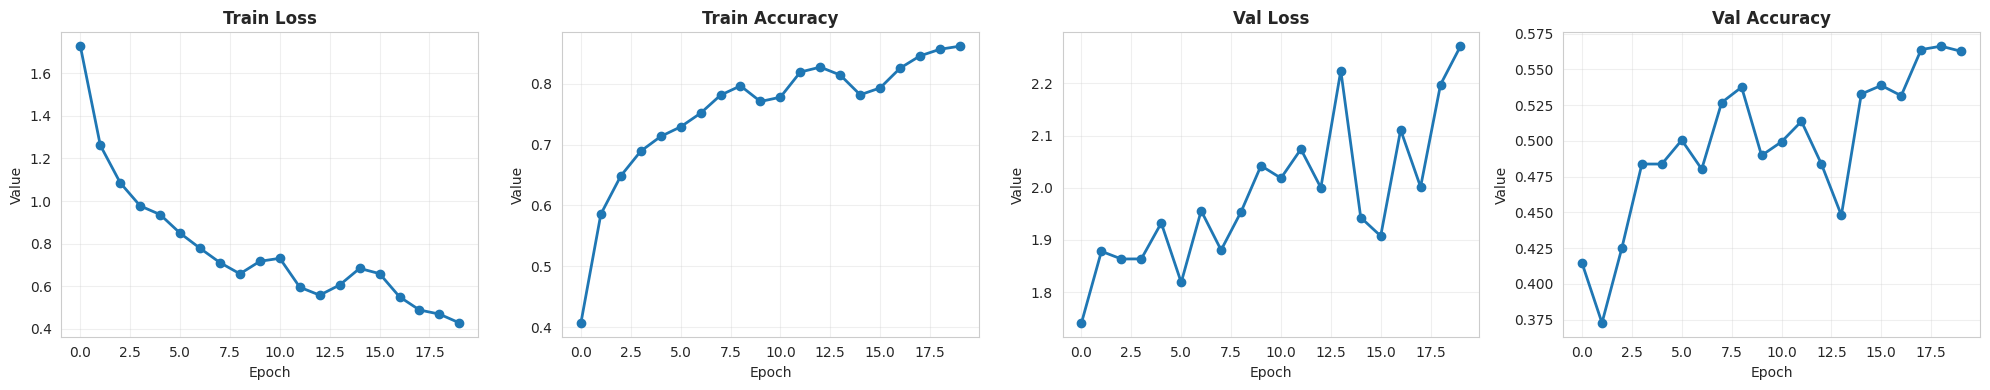

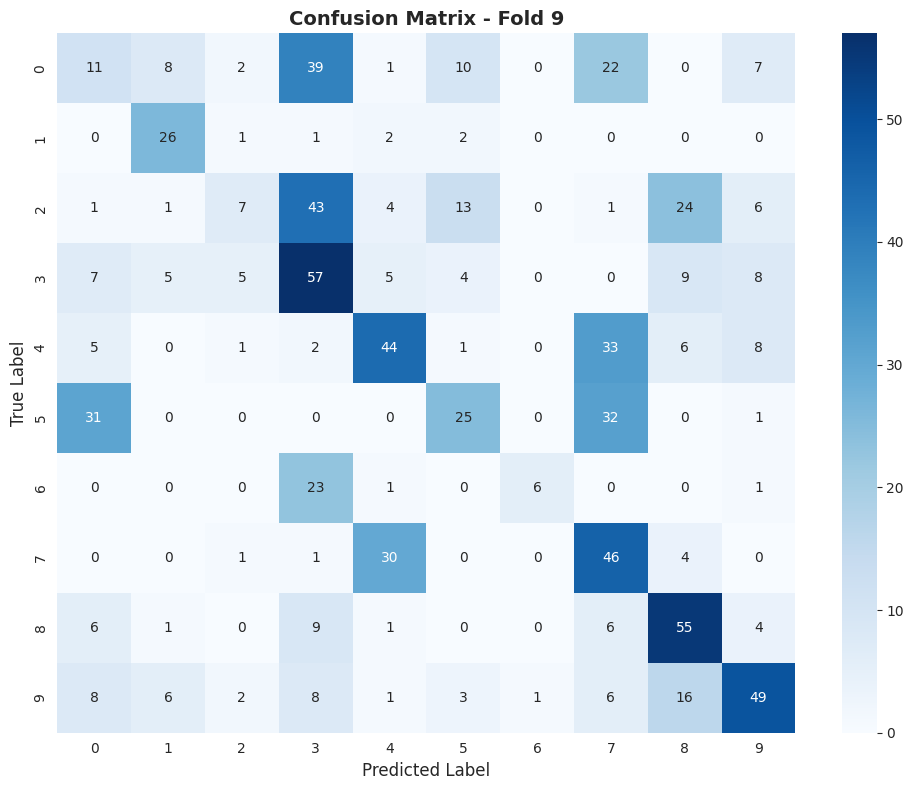


Fold 9 completed!
Results saved to: saved_cv/1125_213410/fold_9

############################################################
FOLD 10/10
############################################################
Test fold: 10
Validation fold: 1
Training folds: [2, 3, 4, 5, 6, 7, 8, 9]

STEP 1: Preparing Data
Train samples: 7022
Val samples: 873
Test samples: 837
Preprocessing training data...
Processing 7022 audio files in train mode...
Processed 100/7022 files
Processed 200/7022 files
Processed 300/7022 files
Processed 400/7022 files
Processed 500/7022 files
Processed 600/7022 files
Processed 700/7022 files
Processed 800/7022 files
Processed 1000/7022 files
Processed 1100/7022 files
Processed 1300/7022 files
Processed 1600/7022 files
Processed 1700/7022 files
Processed 1800/7022 files
Processed 1900/7022 files
Processed 2000/7022 files
Processed 2100/7022 files
Processed 2200/7022 files
Processed 2300/7022 files
Processed 2400/7022 files
Processed 2600/7022 files
Processed 2700/7022 files
Processe

Train Loss: 1.6902, Train Acc: 0.4205
Val Loss: 1.7137, Val Acc: 0.3860

Epoch 2/20
----------------------------------------


Train Loss: 1.2332, Train Acc: 0.5944
Val Loss: 1.8979, Val Acc: 0.3814

Epoch 3/20
----------------------------------------


Train Loss: 1.0426, Train Acc: 0.6709
Val Loss: 2.0071, Val Acc: 0.3517

Epoch 4/20
----------------------------------------


Train Loss: 1.0131, Train Acc: 0.6834
Val Loss: 1.9440, Val Acc: 0.4490

Epoch 5/20
----------------------------------------


Train Loss: 0.8599, Train Acc: 0.7320
Val Loss: 2.0636, Val Acc: 0.4490

Epoch 6/20
----------------------------------------


Train Loss: 0.7874, Train Acc: 0.7598
Val Loss: 2.2375, Val Acc: 0.4158

Epoch 7/20
----------------------------------------


Train Loss: 0.7466, Train Acc: 0.7643
Val Loss: 2.0260, Val Acc: 0.4616

Epoch 8/20
----------------------------------------


Train Loss: 0.6684, Train Acc: 0.7988
Val Loss: 2.3228, Val Acc: 0.4261

Epoch 9/20
----------------------------------------


Train Loss: 0.8703, Train Acc: 0.7259
Val Loss: 2.2493, Val Acc: 0.3608

Epoch 10/20
----------------------------------------


Train Loss: 0.8239, Train Acc: 0.7363
Val Loss: 2.2971, Val Acc: 0.3860

Epoch 11/20
----------------------------------------


Train Loss: 0.6671, Train Acc: 0.7881
Val Loss: 2.4902, Val Acc: 0.4250

Epoch 12/20
----------------------------------------


Train Loss: 0.6620, Train Acc: 0.7929
Val Loss: 2.7039, Val Acc: 0.3288

Epoch 13/20
----------------------------------------


Train Loss: 0.7539, Train Acc: 0.7603
Val Loss: 2.2066, Val Acc: 0.4227

Epoch 14/20
----------------------------------------


Train Loss: 0.6270, Train Acc: 0.8028
Val Loss: 2.3118, Val Acc: 0.4399

Epoch 15/20
----------------------------------------


Train Loss: 0.6237, Train Acc: 0.8003
Val Loss: 2.3650, Val Acc: 0.4376

Epoch 16/20
----------------------------------------


Train Loss: 0.5758, Train Acc: 0.8186
Val Loss: 2.3610, Val Acc: 0.4135

Epoch 17/20
----------------------------------------


Train Loss: 0.6681, Train Acc: 0.7931
Val Loss: 2.2752, Val Acc: 0.4422

Epoch 18/20
----------------------------------------


Train Loss: 0.6051, Train Acc: 0.8114
Val Loss: 2.4922, Val Acc: 0.3986

Epoch 19/20
----------------------------------------


Train Loss: 0.5777, Train Acc: 0.8275
Val Loss: 2.3206, Val Acc: 0.4674

Epoch 20/20
----------------------------------------


Train Loss: 0.5757, Train Acc: 0.8293
Val Loss: 2.3546, Val Acc: 0.4399

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 27/27 [00:00<00:00, 107.18it/s, loss=1.8385]



Test Loss: 1.7652
Test Accuracy: 0.4110

Test Metrics:
  Accuracy:          0.4110
  Precision (macro): 0.3971
  Recall (macro):    0.3761
  F1-Score (macro):  0.3756
  Precision (wtd):   0.4128
  Recall (wtd):      0.4110
  F1-Score (wtd):    0.4016


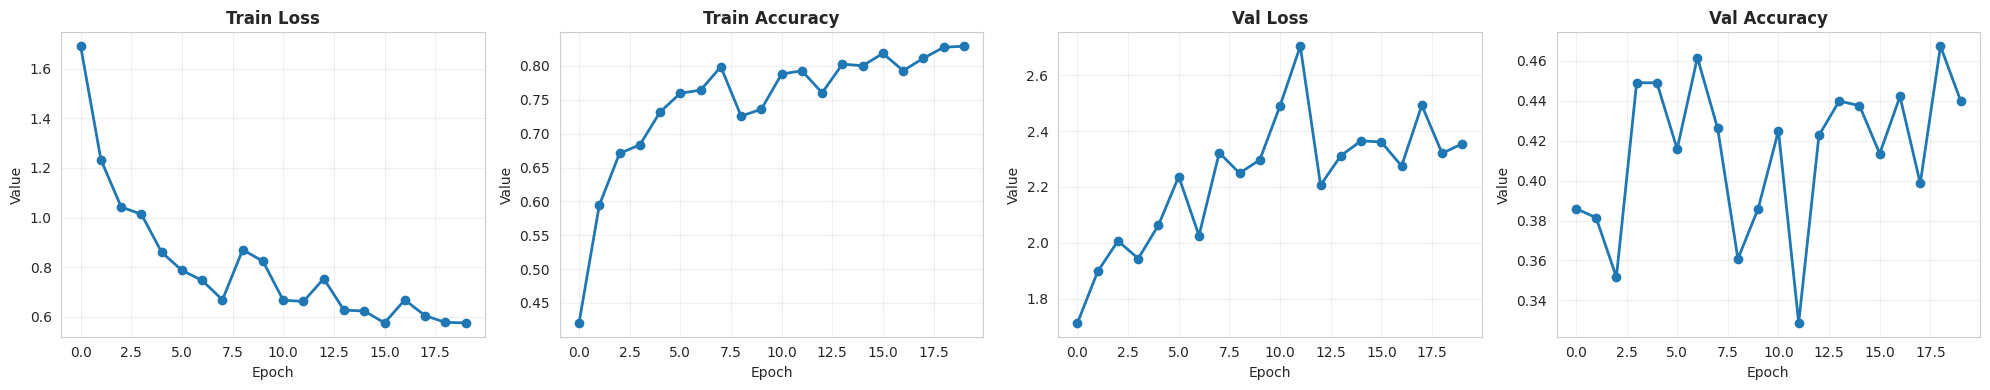

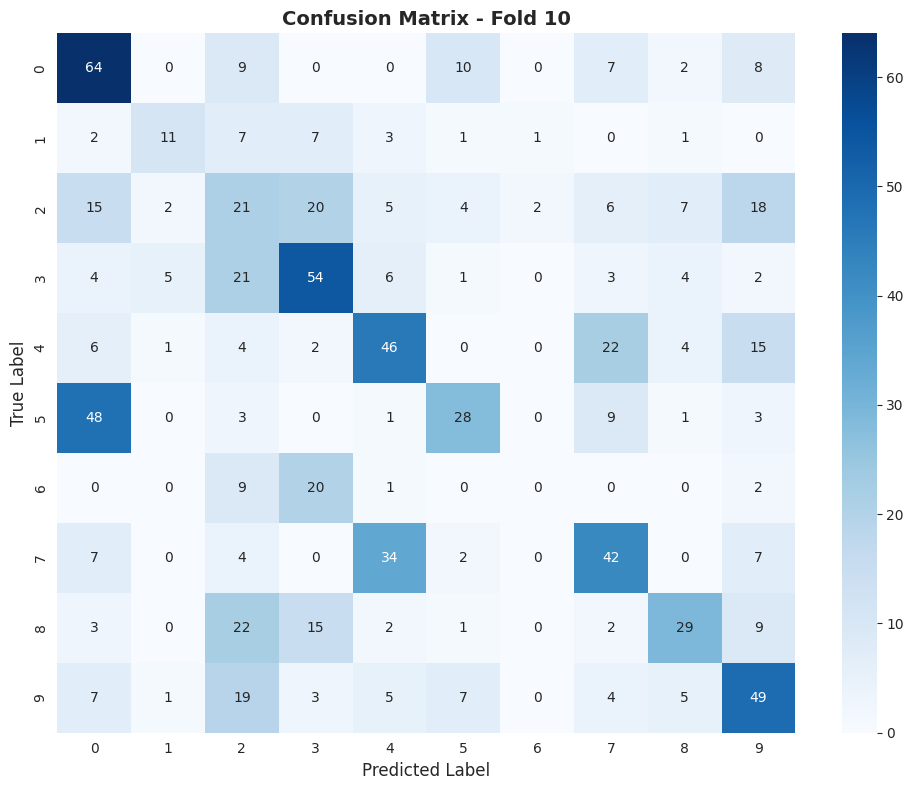


Fold 10 completed!
Results saved to: saved_cv/1125_213410/fold_10

CROSS-VALIDATION RESULTS

Metrics per fold:
Fold   Acc      Prec(M)    Rec(M)     F1(M)     
--------------------------------------------------
1      0.3597   0.3128     0.3556     0.3125    
2      0.4493   0.4823     0.4842     0.4718    
3      0.4465   0.4679     0.4911     0.4698    
4      0.5121   0.5279     0.5105     0.5091    
5      0.4209   0.4526     0.4101     0.4014    
6      0.4192   0.4185     0.4156     0.4079    
7      0.4487   0.4507     0.4114     0.3894    
8      0.4901   0.5084     0.5359     0.5129    
9      0.3995   0.4556     0.4199     0.3928    
10     0.4110   0.3971     0.3761     0.3756    

AGGREGATE RESULTS (Mean ± Std)
Accuracy:              0.4357 ± 0.0418
Precision (macro):     0.4474 ± 0.0578
Recall (macro):        0.4410 ± 0.0571
F1-Score (macro):      0.4243 ± 0.0610
Precision (weighted):  0.4351 ± 0.0513
Recall (weighted):     0.4357 ± 0.0418
F1-Score (weighted):   0.4178 ± 

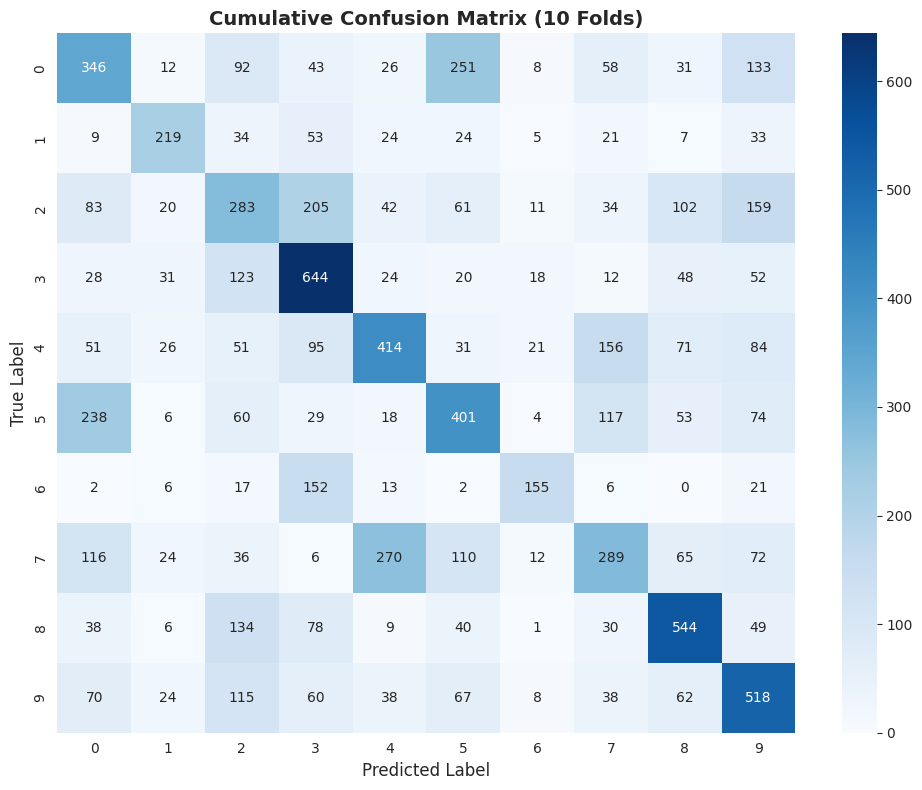

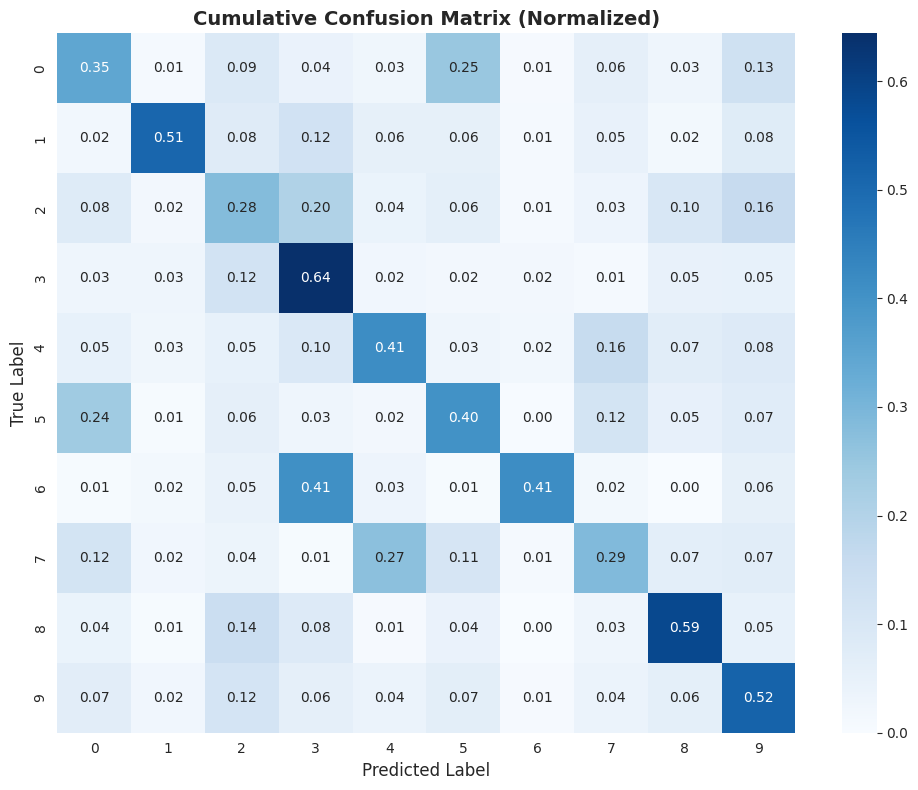

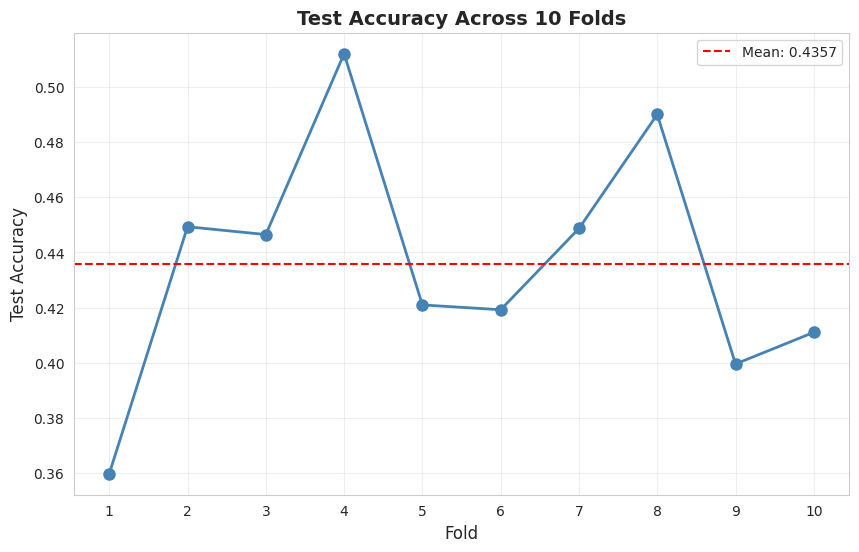

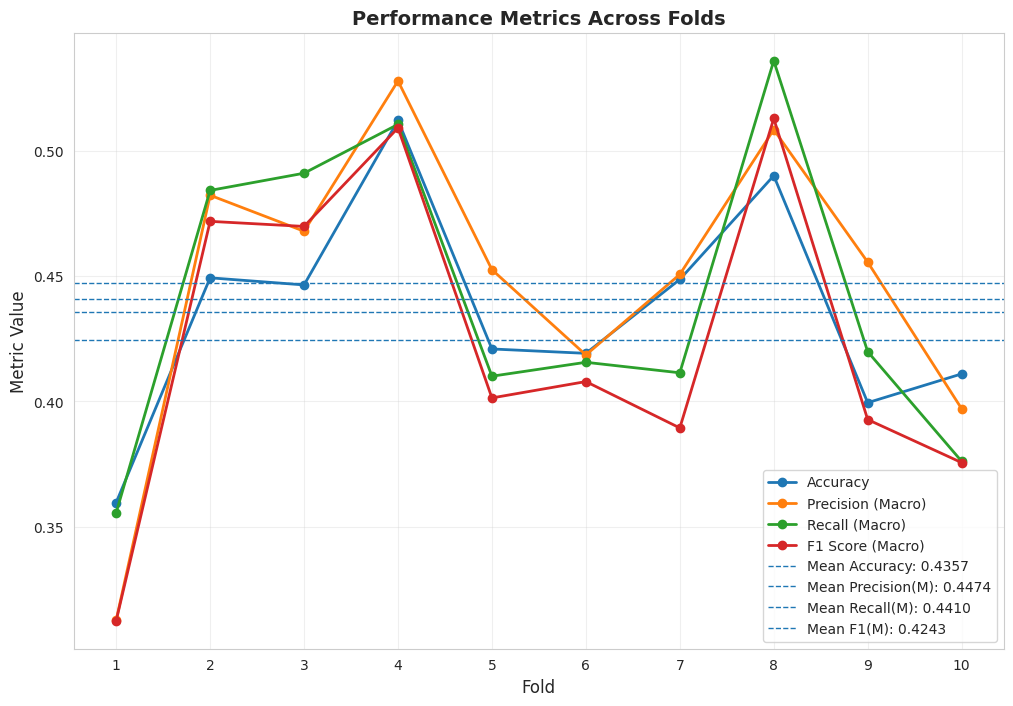


All results saved to: saved_cv/1125_213410
Model saved to: saved_cv/1125_213410


KeyError: 'best_val_acc'

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
audio_base_path = 'UrbanSound8K/audio'

# Define configuration
config = {
    # Spectrogram settings
    'sample_rate': 22050,
    'num_mels': 128,
    'fft_length': 2048,
    'hop_length': 512,
    'norm': 'whiten',
    'stretch_param': [0.4, 0.4],
    
    # RNN settings
    'hidden_size': 64,
    'num_layers': 2,
    'bidirectional': False,
    'rnn_dropout': 0.1,
    
    # Dense layer settings
    'dropout': 0.3
}

# Run complete pipeline
results = train_audio_rnn_cross_validation(
    df=df,
    audio_base_path=audio_base_path,
    config=config,
    epochs=20,
    batch_size=32,
    lr=0.001,
    num_classes=10
)

print(f"Model saved to: {results['save_dir']}")